In [1]:
!pip install requests pandas tqdm
!pip install requests beautifulsoup4 pandas tqdm
!pip install webdriver_manager
!pip install selenium

In [7]:
pip install pymupdf

  Obtaining dependency information for pymupdf from https://files.pythonhosted.org/packages/71/c2/a9059607f80dcaf2392f991748cfc53456820392c0220cff02572653512a/pymupdf-1.25.5-cp39-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.6 MB 435.7 kB/s eta 0:00:38
   ---------------------------------------- 0.1/16.6 MB 880.9 kB/s eta 0:00:19
    --------------------------------------- 0.2/16.6 MB 1.7 MB/s eta 0:00:10
    --------------------------------------- 0.3/16.6 MB 1.5 MB/s eta 0:00:11
   - -------------------------------------- 0.5/16.6 MB 2.3 MB/s eta 0:00:07
   - -------------------------------------- 0.7/16.6 MB 2.8 MB/s eta 0:00:06
   -- ------------------------------------- 0.9/16.6 MB 3.1 MB/s eta 0:00:06
   -- ------------------------------------- 1.2/16.6 MB 3.8 MB/s eta 0:00:05
   --- --------------------------

In [1]:
import logging
from selenium import webdriver
from selenium.webdriver.edge.service import Service as EdgeService
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, \
    StaleElementReferenceException
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
from time import sleep
import random
from datetime import datetime
import os
import requests
from tqdm import tqdm
from datetime import datetime, timedelta
import time
from bs4 import BeautifulSoup
from selenium.webdriver.edge.options import Options
import tempfile
import fitz
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax
import undetected_chromedriver as uc
from selenium.common.exceptions import (
    NoSuchElementException, TimeoutException,
    ElementClickInterceptedException
)
import matplotlib.pyplot as plt
import optuna
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pandas.tseries.offsets import BDay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GRU, Dense, Dropout, Bidirectional, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# PRICE CRAWLING

In [14]:
# Cấu hình
consumer_id = "dfe34cf59187473db8d719138d525791"
consumer_secret = "a1703f3842244b5d907c45dffd20e471"
from_date = "01/01/2015"
to_date = datetime.today().strftime("%d/%m/%Y")
output_dir_price = r"C:\Users\admin\OneDrive - vnu.edu.vn\Price_update"
os.makedirs(output_dir_price, exist_ok=True)
print(f"🕐 Lấy dữ liệu từ {from_date} đến {to_date}")

🕐 Lấy dữ liệu từ 01/01/2015 đến 08/06/2025


In [15]:
# Access token
def get_access_token(consumer_id, consumer_secret):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    payload = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret
    }
    response = requests.post(url, json=payload)
    response.raise_for_status()
    token = response.json()['data']['accessToken']
    print("✅ Access Token lấy thành công.")
    return token
access_token = get_access_token(consumer_id, consumer_secret)

✅ Access Token lấy thành công.


In [16]:
def get_vn30_symbols(access_token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IndexComponents"
    headers = {"Authorization": f"Bearer {access_token}"}
    payload = {"indexCode": "VN30", "pageIndex": 1, "pageSize": 50}
    
    response = requests.get(url, headers=headers, params=payload)
    response.raise_for_status()
    
    full_data = response.json()['data']
    index_components = full_data[0]['IndexComponent']
    symbols = [item['StockSymbol'] for item in index_components]
    
    print(f"📦 Lấy được {len(symbols)} mã VN30: {symbols}")
    return symbols

In [9]:
def get_daily_ohlc_with_retry(access_token, symbol, from_date, to_date, max_retry=3, wait_time=3):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyOhlc"
    headers = {"Authorization": f"Bearer {access_token}"}
    all_data = []
    page_index = 1

    for attempt in range(max_retry):
        try:
            while True:
                payload = {
                    "symbol": symbol,
                    "fromDate": from_date,
                    "toDate": to_date,
                    "pageIndex": page_index,
                    "pageSize": 100,
                    "ascending": False
                }
                response = requests.get(url, headers=headers, params=payload, timeout=10)
                response.raise_for_status()
                data = response.json().get('data', [])
                if not data:
                    break
                all_data.extend(data)
                if len(data) < 100:
                    break
                page_index += 1

            if all_data:
                return all_data
            else:
                time.sleep(wait_time)
        except Exception as e:
            tqdm.write(f"❌ {symbol} attempt {attempt+1} lỗi: {e}")
            time.sleep(wait_time)
    return []

# ====================== HÀM CHÍNH ======================
def crawl_vn30_prices(get_access_token, get_vn30_symbols,
                      consumer_id, consumer_secret,
                      output_dir_price, from_date, to_date):
    os.makedirs(output_dir_price, exist_ok=True)
    token = get_access_token(consumer_id, consumer_secret)
    symbols = get_vn30_symbols(token)

    for symbol in tqdm(symbols, desc="Crawl VN30 symbols"):
        fname = os.path.join(output_dir_price, f"{symbol}_price.csv")

        # Bước 1: Xác định ngày
        if os.path.exists(fname):
            df_old = pd.read_csv(fname)
            df_old['TradingDate'] = pd.to_datetime(df_old['TradingDate'], format='%d/%m/%Y', dayfirst=True, errors='coerce')
            df_old = df_old.dropna(subset=['TradingDate'])
            latest_date = df_old['TradingDate'].max()
            from_date_dynamic = (latest_date + pd.Timedelta(days=1)).strftime('%d/%m/%Y')
        else:
            df_old = None
            from_date_dynamic = from_date

        tqdm.write(f"📅 {symbol}: crawl từ {from_date_dynamic} → {to_date}")

        # Bước 2: Gọi API
        data = get_daily_ohlc_with_retry(token, symbol, from_date_dynamic, to_date)

        if not data:
            tqdm.write(f"⚠️ {symbol}: không có dữ liệu mới.")
            with open("missing_symbols_log.csv", "a") as logf:
                logf.write(f"{symbol},{from_date_dynamic},{to_date}\n")
            continue
        else:
            tqdm.write(f"📊 {symbol}: Lấy được {len(data)} dòng mới từ API.")

        # Bước 3: Xử lý DataFrame
        df = pd.DataFrame(data)
        df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%d/%m/%Y', dayfirst=True, errors='coerce')
        df = df.dropna(subset=['TradingDate'])
        if 'Volume' not in df.columns:
            df['Volume'] = 0

        # Bước 4: Merge với dữ liệu cũ
        if df_old is not None:
            df_combined = pd.concat([df_old, df], ignore_index=True)
            df_combined['TradingDate'] = pd.to_datetime(df_combined['TradingDate'], format='%d/%m/%Y', dayfirst=True, errors='coerce')
            df_combined = df_combined.dropna(subset=['TradingDate'])
            df_combined = df_combined.sort_values(['TradingDate', 'Volume'], ascending=[False, False])
            df_combined = df_combined.drop_duplicates(subset='TradingDate', keep='first')
            df_combined['TradingDate'] = df_combined['TradingDate'].dt.strftime('%d/%m/%Y')
        else:
            df['TradingDate'] = df['TradingDate'].dt.strftime('%d/%m/%Y')
            df_combined = df

        # Bước 5: Ghi ra file
        df_combined.to_csv(fname, index=False)
        tqdm.write(f"✅ {symbol}: tổng {len(df_combined)} dòng → {fname}")

    print("\n🎉 Hoàn tất cập nhật dữ liệu VN30!")

# ====================== CHẠY ======================
if __name__ == "__main__":
    crawl_vn30_prices(get_access_token, get_vn30_symbols, consumer_id, consumer_secret, output_dir_price, from_date, to_date)


✅ Access Token lấy thành công.
📦 Lấy được 30 mã VN30: ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']


Crawl VN30 symbols:   0%|                                                                       | 0/30 [00:00<?, ?it/s]

📅 ACB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:   3%|██                                                             | 1/30 [00:09<04:46,  9.87s/it]

⚠️ ACB: không có dữ liệu mới.
📅 BCM: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:   7%|████▏                                                          | 2/30 [00:19<04:36,  9.87s/it]

⚠️ BCM: không có dữ liệu mới.
📅 BID: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  10%|██████▎                                                        | 3/30 [00:29<04:28,  9.94s/it]

⚠️ BID: không có dữ liệu mới.
📅 BVH: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  13%|████████▍                                                      | 4/30 [00:39<04:18,  9.95s/it]

⚠️ BVH: không có dữ liệu mới.
📅 CTG: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  17%|██████████▌                                                    | 5/30 [00:49<04:09,  9.96s/it]

⚠️ CTG: không có dữ liệu mới.
📅 FPT: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  20%|████████████▌                                                  | 6/30 [00:59<03:59,  9.97s/it]

⚠️ FPT: không có dữ liệu mới.
📅 GAS: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  23%|██████████████▋                                                | 7/30 [01:09<03:49,  9.96s/it]

⚠️ GAS: không có dữ liệu mới.
📅 GVR: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  27%|████████████████▊                                              | 8/30 [01:19<03:38,  9.95s/it]

⚠️ GVR: không có dữ liệu mới.
📅 HDB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  30%|██████████████████▉                                            | 9/30 [01:29<03:29,  9.96s/it]

⚠️ HDB: không có dữ liệu mới.
📅 HPG: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  33%|████████████████████▋                                         | 10/30 [01:39<03:19,  9.99s/it]

⚠️ HPG: không có dữ liệu mới.
📅 LPB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  37%|██████████████████████▋                                       | 11/30 [01:49<03:09,  9.97s/it]

⚠️ LPB: không có dữ liệu mới.
📅 MBB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  40%|████████████████████████▊                                     | 12/30 [01:59<02:59,  9.99s/it]

⚠️ MBB: không có dữ liệu mới.
📅 MSN: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  43%|██████████████████████████▊                                   | 13/30 [02:09<02:49, 10.00s/it]

⚠️ MSN: không có dữ liệu mới.
📅 MWG: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  47%|████████████████████████████▉                                 | 14/30 [02:19<02:39,  9.99s/it]

⚠️ MWG: không có dữ liệu mới.
📅 PLX: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  50%|███████████████████████████████                               | 15/30 [02:29<02:29,  9.99s/it]

⚠️ PLX: không có dữ liệu mới.
📅 SAB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  53%|█████████████████████████████████                             | 16/30 [02:39<02:19,  9.98s/it]

⚠️ SAB: không có dữ liệu mới.
📅 SHB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  57%|███████████████████████████████████▏                          | 17/30 [02:49<02:09,  9.93s/it]

⚠️ SHB: không có dữ liệu mới.
📅 SSB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  60%|█████████████████████████████████████▏                        | 18/30 [02:59<01:59,  9.95s/it]

⚠️ SSB: không có dữ liệu mới.
📅 SSI: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  63%|███████████████████████████████████████▎                      | 19/30 [03:09<01:49,  9.98s/it]

⚠️ SSI: không có dữ liệu mới.
📅 STB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  67%|█████████████████████████████████████████▎                    | 20/30 [03:19<01:40, 10.01s/it]

⚠️ STB: không có dữ liệu mới.
📅 TCB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  70%|███████████████████████████████████████████▍                  | 21/30 [03:29<01:30, 10.02s/it]

⚠️ TCB: không có dữ liệu mới.
📅 TPB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  73%|█████████████████████████████████████████████▍                | 22/30 [03:39<01:20, 10.02s/it]

⚠️ TPB: không có dữ liệu mới.
📅 VCB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  77%|███████████████████████████████████████████████▌              | 23/30 [03:49<01:10, 10.03s/it]

⚠️ VCB: không có dữ liệu mới.
📅 VHM: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  80%|█████████████████████████████████████████████████▌            | 24/30 [03:59<01:00, 10.02s/it]

⚠️ VHM: không có dữ liệu mới.
📅 VIB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  83%|███████████████████████████████████████████████████▋          | 25/30 [04:09<00:49,  9.98s/it]

⚠️ VIB: không có dữ liệu mới.
📅 VIC: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  87%|█████████████████████████████████████████████████████▋        | 26/30 [04:19<00:39,  9.99s/it]

⚠️ VIC: không có dữ liệu mới.
📅 VJC: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  90%|███████████████████████████████████████████████████████▊      | 27/30 [04:29<00:30, 10.03s/it]

⚠️ VJC: không có dữ liệu mới.
📅 VNM: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  93%|█████████████████████████████████████████████████████████▊    | 28/30 [04:39<00:20, 10.03s/it]

⚠️ VNM: không có dữ liệu mới.
📅 VPB: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [04:49<00:10, 10.05s/it]

⚠️ VPB: không có dữ liệu mới.
📅 VRE: crawl từ 07/06/2025 → 08/06/2025


Crawl VN30 symbols: 100%|██████████████████████████████████████████████████████████████| 30/30 [04:59<00:00,  9.99s/it]

⚠️ VRE: không có dữ liệu mới.

🎉 Hoàn tất cập nhật dữ liệu VN30!


# NEWS CRAWLING

In [12]:
# ========== CONFIG ==========
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
SAVE_FOLDER = r"C:\Users\Admin\OneDrive - vnu.edu.vn\News_update"
os.makedirs(SAVE_FOLDER, exist_ok=True)

# ========== DRIVER ==========
def setup_driver():
    options = uc.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    driver = uc.Chrome(options=options)
    driver.set_page_load_timeout(120)
    driver.implicitly_wait(10)
    return driver

# ========== GET ARTICLE CONTENT ==========
def get_article_content(driver):
    try:
        table_xpath = "/html/body/form/div[3]/div[2]/div[1]/table/tbody/tr[1]/td/table/tbody/tr[2]/td/table/tbody/tr[3]/td/table/tbody"
        table_elem = driver.find_element(By.XPATH, table_xpath)
        if table_elem.text.strip():
            return table_elem.text.strip()
    except NoSuchElementException:
        pass

    try:
        paras = driver.find_elements(By.CSS_SELECTOR, "div.detail-content p")
        text = "\n".join(p.text for p in paras if p.text.strip())
        if text.strip():
            return text
    except:
        pass

    try:
        body_text = driver.find_element(By.TAG_NAME, "body").text.strip()
        lines = body_text.splitlines()
        return "\n".join([line for line in lines if len(line.strip()) > 30])
    except:
        return ""

# ========== SCRAPE TIN TỨC CHO 1 MÃ ==========
def scrape_news_for_stock(driver, stock):
    driver.get(f"https://s.cafef.vn/tin-doanh-nghiep/{stock}/event.chn")
    sleep(random.uniform(5, 8))

    time_list, title_list, link_list, content_list = [], [], [], []
    prev_links = set()

    save_path = os.path.join(SAVE_FOLDER, f"{stock}_news.csv")
    if os.path.exists(save_path):
        news_old = pd.read_csv(save_path)
        existing_links = set(news_old['Link'])

        try:
            news_old['Time'] = pd.to_datetime(news_old['Time'], errors='coerce')
            latest_time = news_old.iloc[0]['Time']  # dòng đầu là mới nhất
        except:
            latest_time = pd.Timestamp("2000-01-01")
    else:
        news_old = pd.DataFrame(columns=['Time', 'Title', 'Link', 'Content'])
        existing_links = set()
        latest_time = pd.Timestamp("2000-01-01")

    while True:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.docnhanhTitle"))
            )
            title_elems = driver.find_elements(By.CSS_SELECTOR, "a.docnhanhTitle")
            time_elems = driver.find_elements(By.CSS_SELECTOR, ".timeTitle")

            titles = [e.text.strip() for e in title_elems]
            links = [e.get_attribute("href") for e in title_elems]
            times = [e.text.strip() for e in time_elems]

            if not links or set(links).issubset(prev_links):
                logging.info("🛑 Không còn bài mới, kết thúc.")
                break

            prev_links.update(links)

            for i in range(len(times)):
                try:
                    time_obj = pd.to_datetime(times[i], format="%d/%m/%Y %H:%M", errors='coerce')
                except:
                    time_obj = pd.NaT

                if links[i] not in existing_links and not pd.isna(time_obj) and time_obj > latest_time:
                    time_list.append(times[i])
                    title_list.append(titles[i])
                    link_list.append(links[i])

            try:
                next_btn = driver.find_element(By.ID, "aNext")
                driver.execute_script("arguments[0].click();", next_btn)
                sleep(random.uniform(2, 4))
            except (NoSuchElementException, TimeoutException, ElementClickInterceptedException):
                logging.info("⛔ Không tìm thấy nút chuyển trang.")
                break

        except Exception as e:
            logging.error(f"❌ Lỗi xử lý trang của {stock}: {e}")
            break

    for link in tqdm(link_list, desc=f"📄 {stock} - Crawling", unit="bài", leave=False):
        for attempt in range(3):
            try:
                driver.get(link)
                WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
                content = get_article_content(driver)
                content_list.append(content)
                break
            except:
                if attempt == 2:
                    content_list.append("")
                sleep(random.uniform(1, 2))

    news_df = pd.DataFrame({
        'Time': time_list,
        'Title': title_list,
        'Link': link_list,
        'Content': content_list
    })

    try:
        news_df['Time'] = pd.to_datetime(news_df['Time'], format="%d/%m/%Y %H:%M", errors='coerce')
    except:
        logging.warning("⚠️ Không thể parse thời gian tin mới.")

    news_all = pd.concat([news_old, news_df], ignore_index=True).drop_duplicates(subset=['Link'])

    # Đảm bảo dòng đầu tiên vẫn là bài mới nhất
    try:
        news_all['Time_tmp'] = pd.to_datetime(news_all['Time'], errors='coerce')
        news_all = news_all.sort_values('Time_tmp', ascending=False).drop(columns='Time_tmp')
    except:
        logging.warning("⚠️ Không thể sắp xếp theo thời gian.")

    news_all.to_csv(save_path, index=False, encoding='utf-8-sig')
    logging.info(f"✅ {stock}: Lưu {len(news_all)} bài viết tại {save_path}")

# ========== MAIN ==========
def main():
    list_stocks = get_vn30_symbols(access_token)
    driver = setup_driver()
    try:
        logging.info("📋 Danh sách cổ phiếu: %s", list_stocks)
        for stock in list_stocks:
            logging.info(f"📰 Crawling news for {stock}")
            scrape_news_for_stock(driver, stock)
    finally:
        driver.quit()

if __name__ == "__main__":
    main()


📦 Lấy được 30 mã VN30: ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']


2025-06-07 22:31:04,892 - INFO - patching driver executable C:\Users\Admin\appdata\roaming\undetected_chromedriver\undetected_chromedriver.exe
2025-06-07 22:31:15,254 - INFO - 📋 Danh sách cổ phiếu: ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']
2025-06-07 22:31:15,255 - INFO - 📰 Crawling news for ACB
2025-06-07 22:33:58,499 - ERROR - ❌ Lỗi xử lý trang của ACB: Message: 

2025-06-07 22:33:58,568 - INFO - ✅ ACB: Lưu 1153 bài viết tại ./News_update\ACB_news.csv
2025-06-07 22:33:58,569 - INFO - 📰 Crawling news for BCM
2025-06-07 22:35:10,233 - ERROR - ❌ Lỗi xử lý trang của BCM: Message: 

2025-06-07 22:35:10,259 - INFO - ✅ BCM: Lưu 475 bài viết tại ./News_update\BCM_news.csv
2025-06-07 22:35:10,260 - INFO - 📰 Crawling news for BID
2025-06-07 22:38:04,351 - ERROR - ❌ Lỗi xử lý trang của BID: Message: 

2025-06-07 22:38:04,419 - I

# SENTIMENT SCORING

In [2]:
# Load model/tokenizer
model_name = "phong02468/phobert-Vietnamese-newspaper-title-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
id2label = model.config.id2label

In [12]:
input_dir = r"C:\Users\Admin\OneDrive - vnu.edu.vn\News_update"
output_dir = r"C:\Users\Admin\OneDrive - vnu.edu.vn\sentiment_results"
os.makedirs(output_dir, exist_ok=True)

In [15]:
# === 3. Hàm dự đoán sentiment cho văn bản dài ===
def predict_sentiment_long(text, max_chunk_tokens=256):
    if not isinstance(text, str) or text.strip() == "":
        return "unknown", 0.0

    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i+max_chunk_tokens] for i in range(0, len(tokens), max_chunk_tokens)]

    results = []
    for chunk in chunks:
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        inputs = tokenizer(chunk_text, return_tensors="pt", truncation=True, max_length=max_chunk_tokens)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)
        label_id = torch.argmax(probs, dim=1).item()
        label = id2label[label_id]
        confidence = probs[0][label_id].item()
        results.append((label, confidence))

    if not results:
        return "unknown", 0.0

    labels = [r[0] for r in results]
    majority_label = max(set(labels), key=labels.count)
    avg_conf = sum([r[1] for r in results if r[0] == majority_label]) / labels.count(majority_label)
    return majority_label, round(avg_conf, 4)


# === MAIN LOOP ===
for filename in os.listdir(input_dir):
    if filename.endswith("_news.csv"):
        symbol = filename.replace("_news.csv", "")
        file_path = os.path.join(input_dir, filename)
        output_file = os.path.join(output_dir, f"{symbol}_sentiment.csv")

        try:
            df_news = pd.read_csv(file_path)
            df_news["Content"] = df_news["Content"].astype(str).str.strip()
            df_news["Link"] = df_news["Link"].astype(str).str.strip()

            # Parse Time nếu có cột Time
            if "Time" in df_news.columns:
                df_news["Time"] = pd.to_datetime(df_news["Time"], errors='coerce')

            # Load dữ liệu sentiment nếu có
            if os.path.exists(output_file):
                df_sentiment = pd.read_csv(output_file)
                df_sentiment["Link"] = df_sentiment["Link"].astype(str).str.strip()
                if "Time" in df_sentiment.columns:
                    df_sentiment["Time"] = pd.to_datetime(df_sentiment["Time"], errors='coerce')
                    latest_time = df_sentiment.iloc[0]["Time"]
                else:
                    latest_time = pd.Timestamp("2000-01-01")
            else:
                df_sentiment = pd.DataFrame(columns=list(df_news.columns) + ["Sentiment", "Confidence", "SentimentScore"])
                latest_time = pd.Timestamp("2000-01-01")

            # Lọc ra các bài chưa xử lý, và mới hơn latest_time
            existing_links = set(df_sentiment["Link"])
            df_new = df_news[~df_news["Link"].isin(existing_links)].copy()
            df_new = df_new[df_new["Time"] > latest_time]

            print(f"🆕 {symbol}: Có {len(df_new)} bài mới cần xử lý (sau {latest_time.strftime('%d/%m/%Y %H:%M')})")

            # Nếu có bài mới thì xử lý
            if not df_new.empty:
                sentiments, confidences, scores = [], [], []

                for content in tqdm(df_new["Content"], desc=f"🔍 Phân tích cảm xúc: {symbol}", leave=False):
                    label, score = predict_sentiment_long(content)

                    if label.upper() == "POS":
                        sentiment_score = score
                    elif label.upper() == "NEG":
                        sentiment_score = -score
                    else:
                        sentiment_score = 0.0

                    sentiments.append(label)
                    confidences.append(score)
                    scores.append(sentiment_score)

                # Gán kết quả vào df_new
                df_new["Sentiment"] = sentiments
                df_new["Confidence"] = confidences
                df_new["SentimentScore"] = scores

                # Gộp lại với dữ liệu cũ
                df_sentiment = pd.concat([df_sentiment, df_new], ignore_index=True)
                df_sentiment.drop_duplicates(subset="Link", keep="first", inplace=True)

            # Sắp xếp bài mới nhất lên đầu nếu có cột Time
            if "Time" in df_sentiment.columns:
                df_sentiment.sort_values(by="Time", ascending=False, inplace=True)

            # Lưu lại
            df_sentiment.to_csv(output_file, index=False)
            print(f"✅ {symbol}: Đã lưu kết quả tại {output_file}")

        except Exception as e:
            print(f"❌ Lỗi xử lý file {filename}: {e}")

🆕 ACB: Có 0 bài mới cần xử lý (sau 02/06/2025 00:00)
✅ ACB: Đã lưu kết quả tại sentiment_results\ACB_sentiment.csv
🆕 BCM: Có 0 bài mới cần xử lý (sau 04/06/2025 00:00)
✅ BCM: Đã lưu kết quả tại sentiment_results\BCM_sentiment.csv
🆕 BID: Có 0 bài mới cần xử lý (sau 03/06/2025 11:18)
✅ BID: Đã lưu kết quả tại sentiment_results\BID_sentiment.csv
🆕 BVH: Có 0 bài mới cần xử lý (sau 27/05/2025 00:00)
✅ BVH: Đã lưu kết quả tại sentiment_results\BVH_sentiment.csv
🆕 CTG: Có 1 bài mới cần xử lý (sau 29/05/2025 00:00)


✅ CTG: Đã lưu kết quả tại sentiment_results\CTG_sentiment.csv
🆕 FPT: Có 2 bài mới cần xử lý (sau 30/05/2025 08:45)


✅ FPT: Đã lưu kết quả tại sentiment_results\FPT_sentiment.csv
🆕 GAS: Có 1 bài mới cần xử lý (sau 03/06/2025 00:00)


✅ GAS: Đã lưu kết quả tại sentiment_results\GAS_sentiment.csv
🆕 GVR: Có 0 bài mới cần xử lý (sau 28/05/2025 10:32)
✅ GVR: Đã lưu kết quả tại sentiment_results\GVR_sentiment.csv
🆕 HDB: Có 3 bài mới cần xử lý (sau 30/05/2025 00:00)


✅ HDB: Đã lưu kết quả tại sentiment_results\HDB_sentiment.csv
🆕 HPG: Có 1 bài mới cần xử lý (sau 03/06/2025 06:01)


✅ HPG: Đã lưu kết quả tại sentiment_results\HPG_sentiment.csv
🆕 LPB: Có 0 bài mới cần xử lý (sau 02/06/2025 00:00)
✅ LPB: Đã lưu kết quả tại sentiment_results\LPB_sentiment.csv
🆕 MBB: Có 2 bài mới cần xử lý (sau 02/06/2025 18:11)


✅ MBB: Đã lưu kết quả tại sentiment_results\MBB_sentiment.csv
🆕 MSN: Có 0 bài mới cần xử lý (sau 03/05/2025 00:05)
✅ MSN: Đã lưu kết quả tại sentiment_results\MSN_sentiment.csv
🆕 MWG: Có 0 bài mới cần xử lý (sau 31/05/2025 15:23)
✅ MWG: Đã lưu kết quả tại sentiment_results\MWG_sentiment.csv
🆕 PLX: Có 2 bài mới cần xử lý (sau 02/06/2025 21:08)


✅ PLX: Đã lưu kết quả tại sentiment_results\PLX_sentiment.csv
🆕 SAB: Có 0 bài mới cần xử lý (sau 08/05/2025 00:00)
✅ SAB: Đã lưu kết quả tại sentiment_results\SAB_sentiment.csv
🆕 SHB: Có 0 bài mới cần xử lý (sau 30/05/2025 00:00)
✅ SHB: Đã lưu kết quả tại sentiment_results\SHB_sentiment.csv
🆕 SSB: Có 1 bài mới cần xử lý (sau 04/06/2025 00:00)


✅ SSB: Đã lưu kết quả tại sentiment_results\SSB_sentiment.csv
🆕 SSI: Có 3 bài mới cần xử lý (sau 04/06/2025 00:00)


✅ SSI: Đã lưu kết quả tại sentiment_results\SSI_sentiment.csv
🆕 STB: Có 0 bài mới cần xử lý (sau 26/05/2025 00:00)
✅ STB: Đã lưu kết quả tại sentiment_results\STB_sentiment.csv
🆕 TCB: Có 5 bài mới cần xử lý (sau 04/06/2025 00:00)


✅ TCB: Đã lưu kết quả tại sentiment_results\TCB_sentiment.csv
🆕 TPB: Có 1 bài mới cần xử lý (sau 23/05/2025 17:04)


✅ TPB: Đã lưu kết quả tại sentiment_results\TPB_sentiment.csv
🆕 VCB: Có 0 bài mới cần xử lý (sau 29/05/2025 00:00)
✅ VCB: Đã lưu kết quả tại sentiment_results\VCB_sentiment.csv
🆕 VHM: Có 0 bài mới cần xử lý (sau 05/06/2025 00:10)
✅ VHM: Đã lưu kết quả tại sentiment_results\VHM_sentiment.csv
🆕 VIB: Có 0 bài mới cần xử lý (sau 03/06/2025 00:00)
✅ VIB: Đã lưu kết quả tại sentiment_results\VIB_sentiment.csv
🆕 VIC: Có 2 bài mới cần xử lý (sau 02/06/2025 00:01)


✅ VIC: Đã lưu kết quả tại sentiment_results\VIC_sentiment.csv
🆕 VJC: Có 3 bài mới cần xử lý (sau 02/06/2025 00:00)


✅ VJC: Đã lưu kết quả tại sentiment_results\VJC_sentiment.csv
🆕 VNM: Có 1 bài mới cần xử lý (sau 27/05/2025 00:00)


✅ VNM: Đã lưu kết quả tại sentiment_results\VNM_sentiment.csv
🆕 VPB: Có 2 bài mới cần xử lý (sau 30/05/2025 00:00)


✅ VPB: Đã lưu kết quả tại sentiment_results\VPB_sentiment.csv
🆕 VRE: Có 2 bài mới cần xử lý (sau 30/05/2025 00:00)


✅ VRE: Đã lưu kết quả tại sentiment_results\VRE_sentiment.csv


## Data Mapping

In [13]:
price_dir = r"C:\Users\Admin\OneDrive - vnu.edu.vn\Price_update"
sentiment_dir = r"C:\Users\Admin\OneDrive - vnu.edu.vn\sentiment_results"
output_dir = r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_data"

In [17]:
# --- 1. Thư mục ---
os.makedirs(output_dir, exist_ok=True)

# --- 2. Duyệt qua từng file price ---
for fn in os.listdir(price_dir):
    if not fn.endswith("_price.csv"):
        continue

    symbol         = fn.replace("_price.csv","")
    price_path     = os.path.join(price_dir, fn)
    sentiment_path = os.path.join(sentiment_dir, f"{symbol}_sentiment.csv")
    output_path    = os.path.join(output_dir,   f"{symbol}_data.csv")

    if not os.path.exists(sentiment_path):
        print(f"⚠️  Bỏ qua {symbol}: không tìm thấy {symbol}_sentiment.csv")
        continue

    # --- 3. Đọc data ---
    price_df     = pd.read_csv(price_path)
    sentiment_df = pd.read_csv(sentiment_path)

    # --- 4. Parse ngày tháng ---
    # Giá: TradingDate là 'dd/mm/YYYY'
    price_df['TradingDate'] = pd.to_datetime(
        price_df['TradingDate'],
        format='%d/%m/%Y',
        dayfirst=True
    ).dt.date

    # Sentiment: Time là 'YYYY-mm-dd HH:MM:SS'
    sentiment_df['Time'] = pd.to_datetime(
        sentiment_df['Time'],
        format='%Y-%m-%d %H:%M:%S',
        errors='coerce'
    ).dt.date

    # --- 5. Tính trung bình SentimentScore mỗi ngày ---
    daily_sentiment = (
        sentiment_df
        .groupby('Time', as_index=False)['SentimentScore']
        .mean()
        .rename(
            columns={
                'Time': 'TradingDate',
                'SentimentScore': 'AvgSentimentScore'
            }
        )
    )

    # --- 6. Shift +1 ngày để tránh look-ahead bias ---
    daily_sentiment['TradingDate'] = (
        pd.to_datetime(daily_sentiment['TradingDate'])
        + pd.Timedelta(days=1)
    ).dt.date

    # --- 7. Merge vào giá, fillna 0, sort giảm dần ---
    merged_df = price_df.merge(
        daily_sentiment,
        on='TradingDate',
        how='left'
    )
    merged_df['AvgSentimentScore'] = merged_df['AvgSentimentScore'].fillna(0)
    merged_df = merged_df.sort_values(
        'TradingDate',
        ascending=False
    ).reset_index(drop=True)

    # --- 8. Lưu file kết quả ---
    merged_df.to_csv(output_path, index=False)
    print(f"✅ {symbol}: đã tạo {symbol}_data.csv ({len(merged_df)} dòng)")

print("🎉 Đã xử lý toàn bộ các mã!")


✅ ACB: đã tạo ACB_data.csv (2597 dòng)
✅ BCM: đã tạo BCM_data.csv (1799 dòng)
✅ BID: đã tạo BID_data.csv (2600 dòng)
✅ BVH: đã tạo BVH_data.csv (2600 dòng)
✅ CTG: đã tạo CTG_data.csv (2600 dòng)
✅ FPT: đã tạo FPT_data.csv (2600 dòng)
✅ GAS: đã tạo GAS_data.csv (2600 dòng)
✅ GVR: đã tạo GVR_data.csv (1795 dòng)
✅ HDB: đã tạo HDB_data.csv (1848 dòng)
✅ HPG: đã tạo HPG_data.csv (2600 dòng)
✅ LPB: đã tạo LPB_data.csv (1904 dòng)
✅ MBB: đã tạo MBB_data.csv (2600 dòng)
✅ MSN: đã tạo MSN_data.csv (2600 dòng)
✅ MWG: đã tạo MWG_data.csv (2600 dòng)
✅ PLX: đã tạo PLX_data.csv (2029 dòng)
✅ SAB: đã tạo SAB_data.csv (2120 dòng)
✅ SHB: đã tạo SHB_data.csv (2599 dòng)
✅ SSB: đã tạo SSB_data.csv (1049 dòng)
✅ SSI: đã tạo SSI_data.csv (2600 dòng)
✅ STB: đã tạo STB_data.csv (2600 dòng)
✅ TCB: đã tạo TCB_data.csv (1752 dòng)
✅ TPB: đã tạo TPB_data.csv (1779 dòng)
✅ VCB: đã tạo VCB_data.csv (2598 dòng)
✅ VHM: đã tạo VHM_data.csv (1760 dòng)
✅ VIB: đã tạo VIB_data.csv (2089 dòng)
✅ VIC: đã tạo VIC_data.cs

In [2]:
# === 1. Đường dẫn chứa các file dữ liệu ===
data_folder = r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_data"

# === 2. Tìm tất cả các file có đuôi _data.csv ===
files = [f for f in os.listdir(data_folder) if f.endswith("_data.csv")]

# === 3. Gộp dữ liệu từ tất cả các file ===
all_data = []
for file in files:
    symbol = file.replace("_data.csv", "")
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df["Symbol"] = symbol  # Thêm cột định danh mã cổ phiếu
    all_data.append(df)

# === 4. Kết hợp thành 1 DataFrame duy nhất ===
fact_df = pd.concat(all_data, ignore_index=True)

# === 5. Chuẩn hoá định dạng ngày (nếu cần) ===
fact_df["TradingDate"] = pd.to_datetime(fact_df["TradingDate"])

# === 6. Tạo cột datekey dạng số yyyymmdd để join với bảng dim_date ===
fact_df["DateKey"] = fact_df["TradingDate"].dt.strftime("%Y%m%d").astype(int)

# === 7. Lưu ra file CSV để import vào Power BI ===
fact_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\fact_vn30_data.csv", index=False)
print("✅ Đã tạo thành công bảng fact vn30 data!")

✅ Đã tạo thành công bảng fact vn30 data!


In [19]:
# === Cấu hình thư mục chứa các file ===
folder_path = r"C:\Users\Admin\OneDrive - vnu.edu.vn\sentiment_results"
output_file = r"C:\Users\Admin\OneDrive - vnu.edu.vn\fact_vn30_news.csv"

# === Tìm tất cả các file sentiment ===
files = [f for f in os.listdir(folder_path) if f.endswith("_sentiment.csv")]

dfs = []

for file in files:
    symbol = file.split("_")[0]
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Đổi tên cột Time về đúng định dạng datetime
    df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
    df["Date"] = df["Time"].dt.date
    df["DateKey"] = df["Time"].dt.strftime("%Y%m%d").astype("Int64")  # giữ định dạng số nguyên

    # Thêm mã cổ phiếu
    df["Symbol"] = symbol

    dfs.append(df)

# === Gộp tất cả các file lại thành 1 bảng ===
fact_news_df = pd.concat(dfs, ignore_index=True)

# === Xuất ra file CSV ===
fact_news_df.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"✅ Đã lưu bảng 'fact_vn30_news.csv' với {len(fact_news_df)} dòng.")


✅ Đã lưu bảng 'fact_vn30_news.csv' với 40786 dòng.


# Model

In [19]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install keras_tuner

  Obtaining dependency information for keras_tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 660.6 kB/s eta 0:00:01
   ---------------------------------- ----- 112.6/129.1 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/d9/dd/0b593d1a5ee431b33a1fdf4ddb5911c312ed3bb598ef9e17457af2ee7b34/optuna-4.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/31/59/565286efff3692c5716c212202af61466480f6357c4ae3089d4453bff1f3/alembic-1.16.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/87/fb/99f81ac72ae23375f22b7afdb7642aba97c00a713c217124420147681a2f/mako-1.3.10-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   --- ------------------------------------ 30.7/386.6 kB 1.4 MB/s eta 0:00:01
   ---- ---------------------------------- 41.0/386

In [23]:
pip install optuna optuna-integration[tfkeras]

  Obtaining dependency information for optuna-integration[tfkeras] from https://files.pythonhosted.org/packages/c6/9b/70808bac453d37fc630e4dbdcb2d4d543673438b8a7b15146e936b89bcce/optuna_integration-4.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/98.5 kB ? eta -:--:--
   ------------ --------------------------- 30.7/98.5 kB ? eta -:--:--
   ---------------- ----------------------- 41.0/98.5 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 98.5/98.5 kB 938.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Ridge

In [19]:
forecast_all_df = pd.DataFrame(columns=["Date", "Symbol", "Forecasted_Price"])
evaluation_df = pd.DataFrame(columns=["No", "Symbol", "R2", "RMSE", "MAE", "MAPE"])

def train_and_predict_for_symbol(symbol, data_folder="vn30_data"):
    global forecast_all_df, evaluation_df
    file_path = os.path.join(data_folder, f"{symbol}_data.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Không có file dữ liệu cho {symbol}")
        return

    df = pd.read_csv(file_path)
    df["TradingDate"] = pd.to_datetime(df["TradingDate"])
    df.sort_values("TradingDate", inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["PriceChange"] = df["Close"] - df["Open"]
    df["High_Low_Spread"] = df["High"] - df["Low"]
    df["RollingMean_5"] = df["Close"].rolling(5).mean()
    df["Momentum_10"] = df["Close"] - df["Close"].shift(10)
    df["VolumeChange"] = df["Volume"].pct_change()
    df["Lag_1"] = df["Close"].shift(1)
    df["RollingStd_5"] = df["Close"].rolling(5).std()
    df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["EMA_12"] - df["EMA_26"]

    features = [
        "Open", "High", "Low", "Close", "Volume", "Value", "AvgSentimentScore",
        "PriceChange", "High_Low_Spread", "RollingMean_5", "Momentum_10", "VolumeChange",
        "Lag_1", "RollingStd_5", "EMA_12", "EMA_26", "MACD"
    ]

    df_features = df[features].dropna().copy()
    df_dates = df.loc[df_features.index, "TradingDate"].reset_index(drop=True)

    standard_scaler = StandardScaler()
    standard_scaled = standard_scaler.fit_transform(df_features)
    minmax_scaler = MinMaxScaler()
    scaled_features = minmax_scaler.fit_transform(standard_scaled)
    close_index = df_features.columns.get_loc("Close")

    def inverse_target(scaled_values):
        padded = np.zeros((scaled_values.shape[0], scaled_features.shape[1]))
        padded[:, close_index] = scaled_values.flatten()
        return standard_scaler.inverse_transform(minmax_scaler.inverse_transform(padded))[:, close_index]

    def build_data(horizon):
        SEQ_LEN = 60
        X, y, dates = [], [], []
        for i in range(SEQ_LEN, len(scaled_features) - horizon - 2):
            X.append(scaled_features[i - SEQ_LEN:i].flatten())
            avg_target = np.mean([scaled_features[i + horizon + j, close_index] for j in range(-2, 3)])
            y.append(avg_target)
            dates.append(df_dates[i + horizon])
        return np.array(X), np.array(y), np.array(dates)

    def objective(trial, X, y):
        alpha = trial.suggest_float("alpha", 1e-5, 10.0, log=True)
        model = Pipeline([("model", Ridge(alpha=alpha))])
        tscv = TimeSeriesSplit(n_splits=5)
        scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_root_mean_squared_error")
        return -np.mean(scores)

    def train_and_forecast_ridge(horizon=1):
        global forecast_all_df, evaluation_df
        X, y, dates = build_data(horizon)
        if len(X) < 300:
            print(f"⏭️ {symbol} - Không đủ dữ liệu.")
            return

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(lambda trial: objective(trial, X, y), n_trials=20)
        best_alpha = study.best_params["alpha"]

        model = Ridge(alpha=best_alpha)
        model.fit(X, y)

        tscv = TimeSeriesSplit(n_splits=5)
        y_true_all, y_pred_all, test_dates_all = [], [], []
        for train_index, test_index in tscv.split(X):
            model.fit(X[train_index], y[train_index])
            y_pred = model.predict(X[test_index])
            y_pred_real = inverse_target(y_pred.reshape(-1, 1))
            y_true_real = inverse_target(y[test_index].reshape(-1, 1))
            y_pred_all.extend(y_pred_real)
            y_true_all.extend(y_true_real)
            test_dates_all.extend(dates[test_index])

        r2 = r2_score(y_true_all, y_pred_all)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        mae = mean_absolute_error(y_true_all, y_pred_all)
        mape = np.mean(np.abs((np.array(y_true_all) - np.array(y_pred_all)) / y_true_all)) * 100

        print(f"\n🔧 Best alpha for {symbol}: {best_alpha:.6f}")
        print(f"📊 R²: {r2:.4f} | RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | MAPE: {mape:.2f}%")

        evaluation_df.loc[len(evaluation_df)] = {
            "No": len(evaluation_df) + 1,
            "Symbol": symbol,
            "R2": round(r2, 4),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "MAPE": round(mape, 2)
        }

        last_seq = scaled_features[-60:].copy()
        forecast_prices = []
        forecast_dates = pd.bdate_range(start=df["TradingDate"].max() + pd.Timedelta(days=1), periods=30)

        for _ in range(30):
            input_seq = last_seq.flatten().reshape(1, -1)
            pred_scaled = model.predict(input_seq)
            pred_real = float(inverse_target(pred_scaled.reshape(-1, 1))[0])
            forecast_prices.append(pred_real)
            next_row = last_seq[-1].copy()
            next_row[close_index] = pred_scaled[0]
            last_seq = np.vstack([last_seq[1:], next_row])

        print(f"\n📅 Dự báo 30 phiên tới cho {symbol}:")
        for date, price in zip(forecast_dates, forecast_prices):
            print(f"{date.strftime('%Y-%m-%d')}: {round(price):,} VND")

        forecast_df = pd.DataFrame({
            "Date": forecast_dates,
            "Symbol": symbol,
            "Forecasted_Price": forecast_prices
        })

        forecast_all_df = pd.concat([forecast_all_df, forecast_df], ignore_index=True)

    train_and_forecast_ridge(horizon=1)

symbols = get_vn30_symbols(access_token)

for symbol in symbols:
    train_and_predict_for_symbol(symbol)

forecast_all_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_forecast_next30days.csv", index=False)
evaluation_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_ridge_evaluation.csv", index=False)
print("\n✅ Đã lưu dự báo 30 phiên vào 'vn30_forecast_next30days.csv'")
print("📈 Đã lưu bảng đánh giá mô hình vào 'vn30_ridge_evaluation.csv'")


[I 2025-06-08 13:42:04,966] A new study created in memory with name: no-name-1a78ae43-5fb1-4de7-9b07-1cd74b34d4ae


📦 Lấy được 30 mã VN30: ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']


[I 2025-06-08 13:42:05,701] Trial 0 finished with value: 0.05146003358452805 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.05146003358452805.
[I 2025-06-08 13:42:06,309] Trial 1 finished with value: 0.035924086511392526 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.035924086511392526.
[I 2025-06-08 13:42:06,859] Trial 2 finished with value: 0.03404062135885066 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.03404062135885066.
[I 2025-06-08 13:42:07,460] Trial 3 finished with value: 0.038390403054253175 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.03404062135885066.
[I 2025-06-08 13:42:08,029] Trial 4 finished with value: 0.06112291740435214 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.03404062135885066.
[I 2025-06-08 13:42:08,568] Trial 5 finished with value: 0.061123374113731074 and parameters: {'alpha': 8.629132190071849e-0


🔧 Best alpha for ACB: 0.962097
📊 R²: 0.9793 | RMSE: 564.21 | MAE: 410.02 | MAPE: 3.20%

📅 Dự báo 30 phiên tới cho ACB:
2025-06-09: 21,319 VND
2025-06-10: 21,496 VND
2025-06-11: 21,363 VND
2025-06-12: 21,328 VND
2025-06-13: 21,019 VND
2025-06-16: 20,817 VND
2025-06-17: 20,450 VND
2025-06-18: 20,300 VND
2025-06-19: 20,502 VND
2025-06-20: 20,724 VND
2025-06-23: 21,066 VND
2025-06-24: 21,233 VND
2025-06-25: 21,276 VND
2025-06-26: 21,137 VND
2025-06-27: 20,965 VND
2025-06-30: 20,778 VND
2025-07-01: 20,656 VND
2025-07-02: 20,411 VND
2025-07-03: 20,411 VND
2025-07-04: 20,543 VND
2025-07-07: 20,600 VND
2025-07-08: 20,642 VND
2025-07-09: 20,565 VND
2025-07-10: 20,522 VND
2025-07-11: 20,296 VND
2025-07-14: 20,127 VND
2025-07-15: 19,833 VND
2025-07-16: 19,685 VND
2025-07-17: 19,735 VND
2025-07-18: 19,727 VND


[I 2025-06-08 13:42:18,184] Trial 0 finished with value: 0.07063599498780126 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.07063599498780126.
[I 2025-06-08 13:42:18,469] Trial 1 finished with value: 0.04235879486989024 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.04235879486989024.
[I 2025-06-08 13:42:18,785] Trial 2 finished with value: 0.05133687165068568 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.04235879486989024.
[I 2025-06-08 13:42:19,090] Trial 3 finished with value: 0.06014344407203822 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.04235879486989024.
[I 2025-06-08 13:42:19,345] Trial 4 finished with value: 0.07530242004313695 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.04235879486989024.
[I 2025-06-08 13:42:19,683] Trial 5 finished with value: 0.07530301580246848 and parameters: {'alpha': 8.629132190071849e-05}. 


🔧 Best alpha for BCM: 5.061577
📊 R²: 0.9613 | RMSE: 3,568.83 | MAE: 2,725.98 | MAPE: 5.75%

📅 Dự báo 30 phiên tới cho BCM:
2025-06-09: 63,105 VND
2025-06-10: 63,244 VND
2025-06-11: 62,839 VND
2025-06-12: 62,535 VND
2025-06-13: 62,410 VND
2025-06-16: 62,446 VND
2025-06-17: 62,521 VND
2025-06-18: 62,388 VND
2025-06-19: 62,216 VND
2025-06-20: 61,740 VND
2025-06-23: 61,192 VND
2025-06-24: 60,896 VND
2025-06-25: 61,412 VND
2025-06-26: 62,199 VND
2025-06-27: 62,755 VND
2025-06-30: 63,655 VND
2025-07-01: 64,227 VND
2025-07-02: 64,888 VND
2025-07-03: 64,687 VND
2025-07-04: 64,387 VND
2025-07-07: 64,017 VND
2025-07-08: 63,738 VND
2025-07-09: 63,927 VND
2025-07-10: 64,405 VND
2025-07-11: 64,979 VND
2025-07-14: 64,604 VND
2025-07-15: 64,168 VND
2025-07-16: 63,967 VND
2025-07-17: 63,603 VND
2025-07-18: 63,493 VND


[I 2025-06-08 13:42:25,082] Trial 0 finished with value: 0.04545372066720772 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04545372066720772.
[I 2025-06-08 13:42:25,640] Trial 1 finished with value: 0.036403489473137166 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.036403489473137166.
[I 2025-06-08 13:42:26,192] Trial 2 finished with value: 0.036072831429916144 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.036072831429916144.
[I 2025-06-08 13:42:26,744] Trial 3 finished with value: 0.038903304045483304 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.036072831429916144.
[I 2025-06-08 13:42:27,313] Trial 4 finished with value: 0.05298233908387813 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.036072831429916144.
[I 2025-06-08 13:42:27,852] Trial 5 finished with value: 0.05298275916294657 and parameters: {'alpha': 8.629132190071849


🔧 Best alpha for BID: 0.962097
📊 R²: 0.9726 | RMSE: 1,431.50 | MAE: 1,053.51 | MAPE: 4.88%

📅 Dự báo 30 phiên tới cho BID:
2025-06-09: 35,135 VND
2025-06-10: 35,059 VND
2025-06-11: 35,802 VND
2025-06-12: 35,574 VND
2025-06-13: 35,360 VND
2025-06-16: 35,553 VND
2025-06-17: 35,386 VND
2025-06-18: 35,505 VND
2025-06-19: 35,226 VND
2025-06-20: 35,218 VND
2025-06-23: 35,533 VND
2025-06-24: 35,697 VND
2025-06-25: 35,819 VND
2025-06-26: 35,941 VND
2025-06-27: 35,650 VND
2025-06-30: 35,272 VND
2025-07-01: 34,961 VND
2025-07-02: 34,776 VND
2025-07-03: 34,715 VND
2025-07-04: 34,669 VND
2025-07-07: 34,432 VND
2025-07-08: 33,896 VND
2025-07-09: 34,078 VND
2025-07-10: 34,015 VND
2025-07-11: 34,690 VND
2025-07-14: 35,409 VND
2025-07-15: 35,277 VND
2025-07-16: 35,324 VND
2025-07-17: 34,973 VND
2025-07-18: 34,513 VND


[I 2025-06-08 13:42:37,041] Trial 0 finished with value: 0.07741935873863522 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.07741935873863522.
[I 2025-06-08 13:42:37,590] Trial 1 finished with value: 0.05354946518126029 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.05354946518126029.
[I 2025-06-08 13:42:38,131] Trial 2 finished with value: 0.066027513179314 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.05354946518126029.
[I 2025-06-08 13:42:38,700] Trial 3 finished with value: 0.07333314818934604 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.05354946518126029.
[I 2025-06-08 13:42:39,221] Trial 4 finished with value: 0.07877208327618881 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.05354946518126029.
[I 2025-06-08 13:42:39,769] Trial 5 finished with value: 0.07877212728209836 and parameters: {'alpha': 8.629132190071849e-05}. Be


🔧 Best alpha for BVH: 9.691415
📊 R²: 0.8992 | RMSE: 4,371.05 | MAE: 2,765.11 | MAPE: 4.73%

📅 Dự báo 30 phiên tới cho BVH:
2025-06-09: 51,318 VND
2025-06-10: 51,331 VND
2025-06-11: 51,309 VND
2025-06-12: 51,440 VND
2025-06-13: 51,299 VND
2025-06-16: 51,422 VND
2025-06-17: 52,109 VND
2025-06-18: 52,597 VND
2025-06-19: 52,966 VND
2025-06-20: 53,159 VND
2025-06-23: 53,057 VND
2025-06-24: 52,722 VND
2025-06-25: 52,845 VND
2025-06-26: 53,026 VND
2025-06-27: 53,644 VND
2025-06-30: 53,390 VND
2025-07-01: 53,325 VND
2025-07-02: 52,752 VND
2025-07-03: 52,091 VND
2025-07-04: 51,784 VND
2025-07-07: 51,097 VND
2025-07-08: 50,596 VND
2025-07-09: 49,996 VND
2025-07-10: 49,761 VND
2025-07-11: 49,466 VND
2025-07-14: 49,485 VND
2025-07-15: 49,725 VND
2025-07-16: 49,951 VND
2025-07-17: 50,371 VND
2025-07-18: 50,584 VND


[I 2025-06-08 13:42:49,027] Trial 0 finished with value: 0.06868014799240973 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.06868014799240973.
[I 2025-06-08 13:42:49,546] Trial 1 finished with value: 0.03374401543677071 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.03374401543677071.
[I 2025-06-08 13:42:50,096] Trial 2 finished with value: 0.0387593822026225 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.03374401543677071.
[I 2025-06-08 13:42:50,656] Trial 3 finished with value: 0.04890725595892696 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.03374401543677071.
[I 2025-06-08 13:42:51,197] Trial 4 finished with value: 0.07870213937076534 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.03374401543677071.
[I 2025-06-08 13:42:51,748] Trial 5 finished with value: 0.07870265801506285 and parameters: {'alpha': 8.629132190071849e-05}. B


🔧 Best alpha for CTG: 1.670944
📊 R²: 0.9793 | RMSE: 1,175.63 | MAE: 869.46 | MAPE: 4.11%

📅 Dự báo 30 phiên tới cho CTG:
2025-06-09: 37,714 VND
2025-06-10: 37,844 VND
2025-06-11: 38,061 VND
2025-06-12: 38,274 VND
2025-06-13: 38,182 VND
2025-06-16: 38,407 VND
2025-06-17: 38,640 VND
2025-06-18: 38,923 VND
2025-06-19: 39,100 VND
2025-06-20: 39,490 VND
2025-06-23: 39,543 VND
2025-06-24: 39,503 VND
2025-06-25: 39,208 VND
2025-06-26: 39,072 VND
2025-06-27: 39,188 VND
2025-06-30: 39,651 VND
2025-07-01: 39,609 VND
2025-07-02: 39,769 VND
2025-07-03: 39,823 VND
2025-07-04: 39,696 VND
2025-07-07: 39,459 VND
2025-07-08: 39,186 VND
2025-07-09: 38,977 VND
2025-07-10: 38,836 VND
2025-07-11: 38,939 VND
2025-07-14: 39,124 VND
2025-07-15: 39,489 VND
2025-07-16: 39,289 VND
2025-07-17: 38,834 VND
2025-07-18: 39,056 VND


[I 2025-06-08 13:43:01,036] Trial 0 finished with value: 0.016491558753373946 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.016491558753373946.
[I 2025-06-08 13:43:01,585] Trial 1 finished with value: 0.019809187469663297 and parameters: {'alpha': 5.061576888752303}. Best is trial 0 with value: 0.016491558753373946.
[I 2025-06-08 13:43:02,124] Trial 2 finished with value: 0.013430967758965434 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.013430967758965434.
[I 2025-06-08 13:43:02,703] Trial 3 finished with value: 0.013735791332299926 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.013430967758965434.
[I 2025-06-08 13:43:03,235] Trial 4 finished with value: 0.01881117427654988 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.013430967758965434.
[I 2025-06-08 13:43:03,782] Trial 5 finished with value: 0.01881156402784903 and parameters: {'alpha': 8.6291321900718


🔧 Best alpha for FPT: 0.150213
📊 R²: 0.9970 | RMSE: 2,110.14 | MAE: 1,499.26 | MAPE: 3.96%

📅 Dự báo 30 phiên tới cho FPT:
2025-06-09: 114,345 VND
2025-06-10: 117,928 VND
2025-06-11: 117,484 VND
2025-06-12: 118,466 VND
2025-06-13: 113,321 VND
2025-06-16: 110,720 VND
2025-06-17: 110,089 VND
2025-06-18: 109,841 VND
2025-06-19: 109,831 VND
2025-06-20: 111,989 VND
2025-06-23: 112,276 VND
2025-06-24: 112,452 VND
2025-06-25: 113,767 VND
2025-06-26: 112,679 VND
2025-06-27: 112,350 VND
2025-06-30: 112,666 VND
2025-07-01: 114,542 VND
2025-07-02: 113,249 VND
2025-07-03: 109,667 VND
2025-07-04: 108,988 VND
2025-07-07: 108,514 VND
2025-07-08: 111,940 VND
2025-07-09: 113,079 VND
2025-07-10: 112,783 VND
2025-07-11: 113,147 VND
2025-07-14: 111,894 VND
2025-07-15: 108,552 VND
2025-07-16: 108,930 VND
2025-07-17: 110,333 VND
2025-07-18: 110,422 VND


[I 2025-06-08 13:43:13,164] Trial 0 finished with value: 0.0687178285694715 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.0687178285694715.
[I 2025-06-08 13:43:13,703] Trial 1 finished with value: 0.05051558405478949 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.05051558405478949.
[I 2025-06-08 13:43:14,252] Trial 2 finished with value: 0.05593157136114402 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.05051558405478949.
[I 2025-06-08 13:43:14,802] Trial 3 finished with value: 0.06049115066472811 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.05051558405478949.
[I 2025-06-08 13:43:15,343] Trial 4 finished with value: 0.07514971470744461 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.05051558405478949.
[I 2025-06-08 13:43:15,920] Trial 5 finished with value: 0.075150022925079 and parameters: {'alpha': 8.629132190071849e-05}. Best


🔧 Best alpha for GAS: 7.533019
📊 R²: 0.8386 | RMSE: 5,023.86 | MAE: 3,083.37 | MAPE: 5.00%

📅 Dự báo 30 phiên tới cho GAS:
2025-06-09: 63,347 VND
2025-06-10: 63,230 VND
2025-06-11: 63,652 VND
2025-06-12: 63,844 VND
2025-06-13: 64,230 VND
2025-06-16: 64,443 VND
2025-06-17: 65,115 VND
2025-06-18: 65,343 VND
2025-06-19: 65,242 VND
2025-06-20: 65,445 VND
2025-06-23: 65,218 VND
2025-06-24: 65,358 VND
2025-06-25: 65,797 VND
2025-06-26: 65,698 VND
2025-06-27: 65,672 VND
2025-06-30: 65,264 VND
2025-07-01: 65,050 VND
2025-07-02: 64,773 VND
2025-07-03: 64,023 VND
2025-07-04: 64,218 VND
2025-07-07: 64,547 VND
2025-07-08: 64,638 VND
2025-07-09: 65,030 VND
2025-07-10: 65,043 VND
2025-07-11: 64,387 VND
2025-07-14: 63,727 VND
2025-07-15: 63,469 VND
2025-07-16: 63,463 VND
2025-07-17: 63,849 VND
2025-07-18: 64,532 VND


[I 2025-06-08 13:43:24,839] Trial 0 finished with value: 0.07562317049975759 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.07562317049975759.
[I 2025-06-08 13:43:25,114] Trial 1 finished with value: 0.051445487169172924 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.051445487169172924.
[I 2025-06-08 13:43:25,389] Trial 2 finished with value: 0.05948893279200029 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.051445487169172924.
[I 2025-06-08 13:43:25,663] Trial 3 finished with value: 0.0665783217797076 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.051445487169172924.
[I 2025-06-08 13:43:25,949] Trial 4 finished with value: 0.08448362791695124 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.051445487169172924.
[I 2025-06-08 13:43:26,224] Trial 5 finished with value: 0.08448535973885608 and parameters: {'alpha': 8.629132190071849e-0


🔧 Best alpha for GVR: 3.955232
📊 R²: 0.9546 | RMSE: 1,862.84 | MAE: 1,274.86 | MAPE: 5.88%

📅 Dự báo 30 phiên tới cho GVR:
2025-06-09: 29,879 VND
2025-06-10: 29,477 VND
2025-06-11: 29,479 VND
2025-06-12: 29,059 VND
2025-06-13: 28,559 VND
2025-06-16: 28,103 VND
2025-06-17: 28,116 VND
2025-06-18: 28,469 VND
2025-06-19: 28,653 VND
2025-06-20: 28,983 VND
2025-06-23: 29,241 VND
2025-06-24: 29,020 VND
2025-06-25: 28,977 VND
2025-06-26: 28,768 VND
2025-06-27: 28,850 VND
2025-06-30: 28,968 VND
2025-07-01: 28,986 VND
2025-07-02: 28,607 VND
2025-07-03: 28,020 VND
2025-07-04: 27,650 VND
2025-07-07: 27,534 VND
2025-07-08: 27,654 VND
2025-07-09: 28,228 VND
2025-07-10: 28,368 VND
2025-07-11: 28,424 VND
2025-07-14: 28,446 VND
2025-07-15: 28,063 VND
2025-07-16: 27,993 VND
2025-07-17: 27,822 VND
2025-07-18: 27,490 VND


[I 2025-06-08 13:43:30,903] Trial 0 finished with value: 0.04726273994203302 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04726273994203302.
[I 2025-06-08 13:43:31,199] Trial 1 finished with value: 0.033032570968534965 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.033032570968534965.
[I 2025-06-08 13:43:31,474] Trial 2 finished with value: 0.03166053848313653 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.03166053848313653.
[I 2025-06-08 13:43:31,756] Trial 3 finished with value: 0.036754972207152334 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.03166053848313653.
[I 2025-06-08 13:43:32,050] Trial 4 finished with value: 0.06412504329725251 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.03166053848313653.
[I 2025-06-08 13:43:32,336] Trial 5 finished with value: 0.06412839783737401 and parameters: {'alpha': 8.629132190071849e-05


🔧 Best alpha for HDB: 0.962097
📊 R²: 0.9799 | RMSE: 705.15 | MAE: 533.10 | MAPE: 4.53%

📅 Dự báo 30 phiên tới cho HDB:
2025-06-09: 21,948 VND
2025-06-10: 22,002 VND
2025-06-11: 22,035 VND
2025-06-12: 22,070 VND
2025-06-13: 22,088 VND
2025-06-16: 22,224 VND
2025-06-17: 22,470 VND
2025-06-18: 22,296 VND
2025-06-19: 21,912 VND
2025-06-20: 21,865 VND
2025-06-23: 21,707 VND
2025-06-24: 21,849 VND
2025-06-25: 21,850 VND
2025-06-26: 22,139 VND
2025-06-27: 22,187 VND
2025-06-30: 22,161 VND
2025-07-01: 21,878 VND
2025-07-02: 21,832 VND
2025-07-03: 22,123 VND
2025-07-04: 22,115 VND
2025-07-07: 21,881 VND
2025-07-08: 21,667 VND
2025-07-09: 21,686 VND
2025-07-10: 21,436 VND
2025-07-11: 21,586 VND
2025-07-14: 21,671 VND
2025-07-15: 21,773 VND
2025-07-16: 21,968 VND
2025-07-17: 21,758 VND
2025-07-18: 21,002 VND


[I 2025-06-08 13:43:37,590] Trial 0 finished with value: 0.034479072428746746 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.034479072428746746.
[I 2025-06-08 13:43:38,140] Trial 1 finished with value: 0.02799010317291169 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.02799010317291169.
[I 2025-06-08 13:43:38,713] Trial 2 finished with value: 0.026299449784633066 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.026299449784633066.
[I 2025-06-08 13:43:39,273] Trial 3 finished with value: 0.028819436447869513 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.026299449784633066.
[I 2025-06-08 13:43:39,833] Trial 4 finished with value: 0.03944624843170203 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.026299449784633066.
[I 2025-06-08 13:43:40,354] Trial 5 finished with value: 0.039446756675006814 and parameters: {'alpha': 8.62913219007184


🔧 Best alpha for HPG: 0.378923
📊 R²: 0.9850 | RMSE: 1,070.59 | MAE: 778.81 | MAPE: 5.19%

📅 Dự báo 30 phiên tới cho HPG:
2025-06-09: 26,071 VND
2025-06-10: 26,224 VND
2025-06-11: 26,655 VND
2025-06-12: 27,210 VND
2025-06-13: 27,499 VND
2025-06-16: 27,482 VND
2025-06-17: 27,424 VND
2025-06-18: 27,491 VND
2025-06-19: 27,637 VND
2025-06-20: 28,183 VND
2025-06-23: 28,471 VND
2025-06-24: 28,751 VND
2025-06-25: 29,509 VND
2025-06-26: 29,635 VND
2025-06-27: 29,908 VND
2025-06-30: 30,051 VND
2025-07-01: 29,562 VND
2025-07-02: 28,959 VND
2025-07-03: 28,729 VND
2025-07-04: 28,352 VND
2025-07-07: 28,059 VND
2025-07-08: 27,998 VND
2025-07-09: 27,904 VND
2025-07-10: 27,977 VND
2025-07-11: 28,344 VND
2025-07-14: 28,583 VND
2025-07-15: 28,836 VND
2025-07-16: 28,870 VND
2025-07-17: 28,327 VND
2025-07-18: 27,869 VND


[I 2025-06-08 13:43:49,454] Trial 0 finished with value: 0.027958529844685387 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.027958529844685387.
[I 2025-06-08 13:43:49,771] Trial 1 finished with value: 0.03899440527991777 and parameters: {'alpha': 5.061576888752303}. Best is trial 0 with value: 0.027958529844685387.
[I 2025-06-08 13:43:50,067] Trial 2 finished with value: 0.029041598441450118 and parameters: {'alpha': 0.24658329458549094}. Best is trial 0 with value: 0.027958529844685387.
[I 2025-06-08 13:43:50,363] Trial 3 finished with value: 0.02820680678869745 and parameters: {'alpha': 0.039079671568228794}. Best is trial 0 with value: 0.027958529844685387.
[I 2025-06-08 13:43:50,657] Trial 4 finished with value: 0.03005201649993361 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 0 with value: 0.027958529844685387.
[I 2025-06-08 13:43:50,992] Trial 5 finished with value: 0.030052274785905907 and parameters: {'alpha': 8.62913219007184


🔧 Best alpha for LPB: 0.005232
📊 R²: 0.9859 | RMSE: 985.98 | MAE: 738.43 | MAPE: 7.26%

📅 Dự báo 30 phiên tới cho LPB:
2025-06-09: 31,319 VND
2025-06-10: 31,997 VND
2025-06-11: 30,391 VND
2025-06-12: 28,029 VND
2025-06-13: 26,900 VND
2025-06-16: 27,384 VND
2025-06-17: 28,291 VND
2025-06-18: 28,536 VND
2025-06-19: 29,509 VND
2025-06-20: 29,430 VND
2025-06-23: 29,809 VND
2025-06-24: 29,213 VND
2025-06-25: 29,950 VND
2025-06-26: 29,937 VND
2025-06-27: 31,596 VND
2025-06-30: 32,381 VND
2025-07-01: 32,034 VND
2025-07-02: 31,938 VND
2025-07-03: 32,446 VND
2025-07-04: 32,464 VND
2025-07-07: 33,386 VND
2025-07-08: 33,974 VND
2025-07-09: 33,884 VND
2025-07-10: 33,030 VND
2025-07-11: 32,536 VND
2025-07-14: 33,124 VND
2025-07-15: 32,840 VND
2025-07-16: 33,381 VND
2025-07-17: 33,213 VND
2025-07-18: 33,297 VND


[I 2025-06-08 13:43:56,419] Trial 0 finished with value: 0.04378821004560733 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04378821004560733.
[I 2025-06-08 13:43:56,988] Trial 1 finished with value: 0.04718989608446486 and parameters: {'alpha': 5.061576888752303}. Best is trial 0 with value: 0.04378821004560733.
[I 2025-06-08 13:43:57,536] Trial 2 finished with value: 0.03265177993709326 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.03265177993709326.
[I 2025-06-08 13:43:58,098] Trial 3 finished with value: 0.03489734115066613 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.03265177993709326.
[I 2025-06-08 13:43:58,688] Trial 4 finished with value: 0.05499140354409272 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.03265177993709326.
[I 2025-06-08 13:43:59,229] Trial 5 finished with value: 0.054992224243440156 and parameters: {'alpha': 8.629132190071849e-05}.


🔧 Best alpha for MBB: 0.177188
📊 R²: 0.9784 | RMSE: 810.85 | MAE: 602.20 | MAPE: 5.99%

📅 Dự báo 30 phiên tới cho MBB:
2025-06-09: 23,980 VND
2025-06-10: 23,822 VND
2025-06-11: 23,581 VND
2025-06-12: 23,631 VND
2025-06-13: 23,272 VND
2025-06-16: 23,562 VND
2025-06-17: 24,344 VND
2025-06-18: 24,703 VND
2025-06-19: 24,729 VND
2025-06-20: 24,282 VND
2025-06-23: 24,073 VND
2025-06-24: 23,770 VND
2025-06-25: 23,255 VND
2025-06-26: 23,483 VND
2025-06-27: 23,538 VND
2025-06-30: 23,608 VND
2025-07-01: 23,509 VND
2025-07-02: 23,398 VND
2025-07-03: 23,285 VND
2025-07-04: 23,205 VND
2025-07-07: 23,316 VND
2025-07-08: 23,361 VND
2025-07-09: 23,660 VND
2025-07-10: 23,109 VND
2025-07-11: 22,610 VND
2025-07-14: 22,448 VND
2025-07-15: 22,668 VND
2025-07-16: 23,407 VND
2025-07-17: 23,491 VND
2025-07-18: 23,726 VND


[I 2025-06-08 13:44:08,624] Trial 0 finished with value: 0.06189509673419028 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.06189509673419028.
[I 2025-06-08 13:44:09,203] Trial 1 finished with value: 0.04552687215576941 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.04552687215576941.
[I 2025-06-08 13:44:09,781] Trial 2 finished with value: 0.040101322326527265 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.040101322326527265.
[I 2025-06-08 13:44:10,325] Trial 3 finished with value: 0.04478002779280433 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.040101322326527265.
[I 2025-06-08 13:44:10,915] Trial 4 finished with value: 0.07914090488155053 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.040101322326527265.
[I 2025-06-08 13:44:11,496] Trial 5 finished with value: 0.07914170880785205 and parameters: {'alpha': 8.629132190071849e-0


🔧 Best alpha for MSN: 0.763063
📊 R²: 0.9516 | RMSE: 5,039.05 | MAE: 3,460.40 | MAPE: 4.74%

📅 Dự báo 30 phiên tới cho MSN:
2025-06-09: 63,211 VND
2025-06-10: 63,036 VND
2025-06-11: 61,416 VND
2025-06-12: 60,298 VND
2025-06-13: 59,487 VND
2025-06-16: 58,417 VND
2025-06-17: 58,580 VND
2025-06-18: 59,727 VND
2025-06-19: 60,456 VND
2025-06-20: 62,476 VND
2025-06-23: 62,420 VND
2025-06-24: 62,199 VND
2025-06-25: 62,687 VND
2025-06-26: 62,693 VND
2025-06-27: 63,454 VND
2025-06-30: 64,547 VND
2025-07-01: 63,627 VND
2025-07-02: 62,494 VND
2025-07-03: 63,224 VND
2025-07-04: 62,048 VND
2025-07-07: 61,050 VND
2025-07-08: 59,677 VND
2025-07-09: 59,929 VND
2025-07-10: 61,130 VND
2025-07-11: 61,094 VND
2025-07-14: 61,774 VND
2025-07-15: 60,589 VND
2025-07-16: 61,456 VND
2025-07-17: 62,475 VND
2025-07-18: 63,581 VND


[I 2025-06-08 13:44:20,912] Trial 0 finished with value: 0.04501774518568038 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04501774518568038.
[I 2025-06-08 13:44:21,473] Trial 1 finished with value: 0.025878741838413166 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.025878741838413166.
[I 2025-06-08 13:44:22,062] Trial 2 finished with value: 0.028816247832824965 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.025878741838413166.
[I 2025-06-08 13:44:22,602] Trial 3 finished with value: 0.03414827072378843 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.025878741838413166.
[I 2025-06-08 13:44:23,183] Trial 4 finished with value: 0.0524644589214476 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.025878741838413166.
[I 2025-06-08 13:44:23,721] Trial 5 finished with value: 0.05246499844589449 and parameters: {'alpha': 8.629132190071849e-


🔧 Best alpha for MWG: 1.670944
📊 R²: 0.9847 | RMSE: 1,890.14 | MAE: 1,434.18 | MAPE: 3.61%

📅 Dự báo 30 phiên tới cho MWG:
2025-06-09: 60,590 VND
2025-06-10: 60,853 VND
2025-06-11: 61,676 VND
2025-06-12: 62,698 VND
2025-06-13: 63,056 VND
2025-06-16: 61,804 VND
2025-06-17: 61,626 VND
2025-06-18: 61,586 VND
2025-06-19: 60,793 VND
2025-06-20: 60,339 VND
2025-06-23: 60,475 VND
2025-06-24: 60,483 VND
2025-06-25: 60,212 VND
2025-06-26: 60,950 VND
2025-06-27: 61,982 VND
2025-06-30: 62,071 VND
2025-07-01: 62,102 VND
2025-07-02: 61,749 VND
2025-07-03: 61,337 VND
2025-07-04: 61,113 VND
2025-07-07: 60,678 VND
2025-07-08: 59,901 VND
2025-07-09: 60,053 VND
2025-07-10: 60,176 VND
2025-07-11: 59,978 VND
2025-07-14: 60,124 VND
2025-07-15: 60,521 VND
2025-07-16: 61,602 VND
2025-07-17: 61,880 VND
2025-07-18: 60,715 VND


[I 2025-06-08 13:44:32,998] Trial 0 finished with value: 0.09982669501646906 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.09982669501646906.
[I 2025-06-08 13:44:33,362] Trial 1 finished with value: 0.05088832645917243 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.05088832645917243.
[I 2025-06-08 13:44:33,716] Trial 2 finished with value: 0.0636354135420654 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.05088832645917243.
[I 2025-06-08 13:44:34,082] Trial 3 finished with value: 0.0748102427526127 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.05088832645917243.
[I 2025-06-08 13:44:34,419] Trial 4 finished with value: 0.12313730668886871 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.05088832645917243.
[I 2025-06-08 13:44:34,754] Trial 5 finished with value: 0.1231386127696357 and parameters: {'alpha': 8.629132190071849e-05}. Bes


🔧 Best alpha for PLX: 9.691415
📊 R²: 0.8519 | RMSE: 2,653.19 | MAE: 1,819.50 | MAPE: 4.39%

📅 Dự báo 30 phiên tới cho PLX:
2025-06-09: 36,685 VND
2025-06-10: 37,438 VND
2025-06-11: 37,884 VND
2025-06-12: 38,432 VND
2025-06-13: 38,464 VND
2025-06-16: 38,561 VND
2025-06-17: 38,636 VND
2025-06-18: 38,864 VND
2025-06-19: 39,194 VND
2025-06-20: 39,498 VND
2025-06-23: 39,798 VND
2025-06-24: 40,052 VND
2025-06-25: 40,155 VND
2025-06-26: 39,903 VND
2025-06-27: 39,532 VND
2025-06-30: 39,394 VND
2025-07-01: 39,202 VND
2025-07-02: 38,939 VND
2025-07-03: 38,770 VND
2025-07-04: 38,525 VND
2025-07-07: 38,424 VND
2025-07-08: 38,581 VND
2025-07-09: 38,371 VND
2025-07-10: 38,496 VND
2025-07-11: 38,645 VND
2025-07-14: 38,905 VND
2025-07-15: 39,288 VND
2025-07-16: 39,407 VND
2025-07-17: 39,480 VND
2025-07-18: 39,371 VND


[I 2025-06-08 13:44:40,751] Trial 0 finished with value: 0.10529765236293569 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.10529765236293569.
[I 2025-06-08 13:44:41,119] Trial 1 finished with value: 0.03465458835298054 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.03465458835298054.
[I 2025-06-08 13:44:41,548] Trial 2 finished with value: 0.0503236669622749 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.03465458835298054.
[I 2025-06-08 13:44:41,935] Trial 3 finished with value: 0.07458237108695824 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.03465458835298054.
[I 2025-06-08 13:44:42,299] Trial 4 finished with value: 0.12292105171695926 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.03465458835298054.
[I 2025-06-08 13:44:42,698] Trial 5 finished with value: 0.12292293414568667 and parameters: {'alpha': 8.629132190071849e-05}. B


🔧 Best alpha for SAB: 7.533019
📊 R²: 0.9626 | RMSE: 3,422.47 | MAE: 2,592.61 | MAPE: 3.63%

📅 Dự báo 30 phiên tới cho SAB:
2025-06-09: 46,012 VND
2025-06-10: 45,228 VND
2025-06-11: 44,918 VND
2025-06-12: 45,272 VND
2025-06-13: 45,480 VND
2025-06-16: 45,649 VND
2025-06-17: 45,858 VND
2025-06-18: 45,752 VND
2025-06-19: 45,997 VND
2025-06-20: 46,319 VND
2025-06-23: 46,830 VND
2025-06-24: 47,251 VND
2025-06-25: 47,514 VND
2025-06-26: 47,096 VND
2025-06-27: 46,628 VND
2025-06-30: 46,274 VND
2025-07-01: 45,873 VND
2025-07-02: 45,795 VND
2025-07-03: 45,746 VND
2025-07-04: 45,686 VND
2025-07-07: 45,747 VND
2025-07-08: 45,714 VND
2025-07-09: 46,160 VND
2025-07-10: 46,948 VND
2025-07-11: 47,140 VND
2025-07-14: 46,913 VND
2025-07-15: 46,431 VND
2025-07-16: 45,880 VND
2025-07-17: 45,809 VND
2025-07-18: 45,513 VND


[I 2025-06-08 13:44:49,367] Trial 0 finished with value: 0.04269870331727509 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04269870331727509.
[I 2025-06-08 13:44:49,929] Trial 1 finished with value: 0.03289475327362683 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.03289475327362683.
[I 2025-06-08 13:44:50,511] Trial 2 finished with value: 0.0316839129325998 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.0316839129325998.
[I 2025-06-08 13:44:51,020] Trial 3 finished with value: 0.033573850784523275 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.0316839129325998.
[I 2025-06-08 13:44:51,570] Trial 4 finished with value: 0.056886951321467115 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.0316839129325998.
[I 2025-06-08 13:44:52,120] Trial 5 finished with value: 0.056888227509749055 and parameters: {'alpha': 8.629132190071849e-05}. B


🔧 Best alpha for SHB: 0.962097
📊 R²: 0.9824 | RMSE: 511.35 | MAE: 349.04 | MAPE: 4.87%

📅 Dự báo 30 phiên tới cho SHB:
2025-06-09: 13,752 VND
2025-06-10: 13,867 VND
2025-06-11: 13,990 VND
2025-06-12: 14,158 VND
2025-06-13: 14,475 VND
2025-06-16: 14,648 VND
2025-06-17: 15,004 VND
2025-06-18: 15,003 VND
2025-06-19: 14,918 VND
2025-06-20: 15,011 VND
2025-06-23: 15,042 VND
2025-06-24: 14,977 VND
2025-06-25: 14,714 VND
2025-06-26: 14,423 VND
2025-06-27: 14,412 VND
2025-06-30: 14,451 VND
2025-07-01: 14,680 VND
2025-07-02: 14,768 VND
2025-07-03: 14,828 VND
2025-07-04: 14,664 VND
2025-07-07: 14,718 VND
2025-07-08: 14,651 VND
2025-07-09: 14,753 VND
2025-07-10: 15,129 VND
2025-07-11: 14,883 VND
2025-07-14: 15,054 VND
2025-07-15: 14,783 VND
2025-07-16: 14,822 VND
2025-07-17: 14,828 VND
2025-07-18: 14,671 VND


[I 2025-06-08 13:45:00,935] Trial 1 finished with value: 0.07951622770110577 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.07951622770110577.
[I 2025-06-08 13:45:01,050] Trial 2 finished with value: 0.08462744267855148 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.07951622770110577.
[I 2025-06-08 13:45:01,159] Trial 3 finished with value: 0.08660252035806966 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.07951622770110577.
[I 2025-06-08 13:45:01,273] Trial 4 finished with value: 0.0874013735040352 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.07951622770110577.
[I 2025-06-08 13:45:01,386] Trial 5 finished with value: 0.0874013742343763 and parameters: {'alpha': 8.629132190071849e-05}. Best is trial 1 with value: 0.07951622770110577.
[I 2025-06-08 13:45:01,498] Trial 6 finished with value: 0.08740299969615331 and parameters: {'alpha': 2.231010801867923e-05}. Be


🔧 Best alpha for SSB: 9.691415
📊 R²: 0.7728 | RMSE: 1,194.71 | MAE: 905.60 | MAPE: 4.29%

📅 Dự báo 30 phiên tới cho SSB:
2025-06-09: 19,243 VND
2025-06-10: 19,407 VND
2025-06-11: 19,442 VND
2025-06-12: 19,486 VND
2025-06-13: 19,387 VND
2025-06-16: 19,263 VND
2025-06-17: 19,215 VND
2025-06-18: 19,117 VND
2025-06-19: 19,025 VND
2025-06-20: 18,901 VND
2025-06-23: 18,717 VND
2025-06-24: 18,510 VND
2025-06-25: 18,345 VND
2025-06-26: 18,227 VND
2025-06-27: 18,181 VND
2025-06-30: 18,245 VND
2025-07-01: 18,295 VND
2025-07-02: 18,359 VND
2025-07-03: 18,426 VND
2025-07-04: 18,518 VND
2025-07-07: 18,598 VND
2025-07-08: 18,652 VND
2025-07-09: 18,794 VND
2025-07-10: 18,877 VND
2025-07-11: 18,992 VND
2025-07-14: 19,059 VND
2025-07-15: 18,959 VND
2025-07-16: 18,898 VND
2025-07-17: 18,826 VND
2025-07-18: 18,822 VND


[I 2025-06-08 13:45:03,917] Trial 0 finished with value: 0.03998639731146934 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.03998639731146934.
[I 2025-06-08 13:45:04,479] Trial 1 finished with value: 0.04128840067339551 and parameters: {'alpha': 5.061576888752303}. Best is trial 0 with value: 0.03998639731146934.
[I 2025-06-08 13:45:05,007] Trial 2 finished with value: 0.030061978924986726 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.030061978924986726.
[I 2025-06-08 13:45:05,579] Trial 3 finished with value: 0.03014092774732511 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.030061978924986726.
[I 2025-06-08 13:45:06,148] Trial 4 finished with value: 0.05288299536666269 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.030061978924986726.
[I 2025-06-08 13:45:06,698] Trial 5 finished with value: 0.052884101987610975 and parameters: {'alpha': 8.629132190071849e-


🔧 Best alpha for SSI: 0.080947
📊 R²: 0.9838 | RMSE: 1,058.90 | MAE: 778.32 | MAPE: 5.12%

📅 Dự báo 30 phiên tới cho SSI:
2025-06-09: 25,037 VND
2025-06-10: 25,587 VND
2025-06-11: 25,629 VND
2025-06-12: 25,775 VND
2025-06-13: 25,603 VND
2025-06-16: 25,550 VND
2025-06-17: 26,492 VND
2025-06-18: 27,104 VND
2025-06-19: 26,730 VND
2025-06-20: 25,870 VND
2025-06-23: 24,638 VND
2025-06-24: 23,788 VND
2025-06-25: 23,712 VND
2025-06-26: 23,647 VND
2025-06-27: 23,710 VND
2025-06-30: 24,522 VND
2025-07-01: 24,299 VND
2025-07-02: 23,898 VND
2025-07-03: 23,589 VND
2025-07-04: 23,391 VND
2025-07-07: 23,582 VND
2025-07-08: 23,952 VND
2025-07-09: 24,290 VND
2025-07-10: 25,063 VND
2025-07-11: 25,851 VND
2025-07-14: 26,687 VND
2025-07-15: 27,810 VND
2025-07-16: 29,756 VND
2025-07-17: 29,500 VND
2025-07-18: 29,482 VND


[I 2025-06-08 13:45:16,254] Trial 0 finished with value: 0.04918496932177606 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04918496932177606.
[I 2025-06-08 13:45:16,836] Trial 1 finished with value: 0.027223761098031644 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.027223761098031644.
[I 2025-06-08 13:45:17,400] Trial 2 finished with value: 0.026417872471282834 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.026417872471282834.
[I 2025-06-08 13:45:17,958] Trial 3 finished with value: 0.031126340412068847 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.026417872471282834.
[I 2025-06-08 13:45:18,498] Trial 4 finished with value: 0.08646740082237682 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.026417872471282834.
[I 2025-06-08 13:45:19,044] Trial 5 finished with value: 0.08647062194939922 and parameters: {'alpha': 8.629132190071849


🔧 Best alpha for STB: 0.962097
📊 R²: 0.9861 | RMSE: 1,077.66 | MAE: 818.21 | MAPE: 4.56%

📅 Dự báo 30 phiên tới cho STB:
2025-06-09: 41,746 VND
2025-06-10: 41,213 VND
2025-06-11: 41,027 VND
2025-06-12: 40,436 VND
2025-06-13: 40,365 VND
2025-06-16: 40,332 VND
2025-06-17: 40,590 VND
2025-06-18: 40,808 VND
2025-06-19: 41,146 VND
2025-06-20: 40,970 VND
2025-06-23: 40,931 VND
2025-06-24: 40,686 VND
2025-06-25: 40,148 VND
2025-06-26: 40,120 VND
2025-06-27: 39,505 VND
2025-06-30: 40,027 VND
2025-07-01: 40,336 VND
2025-07-02: 40,504 VND
2025-07-03: 41,043 VND
2025-07-04: 41,166 VND
2025-07-07: 41,487 VND
2025-07-08: 41,654 VND
2025-07-09: 41,773 VND
2025-07-10: 41,926 VND
2025-07-11: 41,362 VND
2025-07-14: 41,292 VND
2025-07-15: 40,600 VND
2025-07-16: 40,699 VND
2025-07-17: 40,121 VND
2025-07-18: 39,586 VND


[I 2025-06-08 13:45:28,092] Trial 0 finished with value: 0.059122402899882874 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.059122402899882874.
[I 2025-06-08 13:45:28,346] Trial 1 finished with value: 0.042605280585561324 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.042605280585561324.
[I 2025-06-08 13:45:28,611] Trial 2 finished with value: 0.046420552354511466 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.042605280585561324.
[I 2025-06-08 13:45:28,885] Trial 3 finished with value: 0.05332737515054716 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.042605280585561324.
[I 2025-06-08 13:45:29,160] Trial 4 finished with value: 0.06542667673658342 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.042605280585561324.
[I 2025-06-08 13:45:29,414] Trial 5 finished with value: 0.06542754346112653 and parameters: {'alpha': 8.62913219007184


🔧 Best alpha for TCB: 1.670944
📊 R²: 0.9665 | RMSE: 1,046.27 | MAE: 821.07 | MAPE: 5.06%

📅 Dự báo 30 phiên tới cho TCB:
2025-06-09: 31,802 VND
2025-06-10: 31,835 VND
2025-06-11: 31,622 VND
2025-06-12: 31,205 VND
2025-06-13: 31,133 VND
2025-06-16: 31,034 VND
2025-06-17: 31,005 VND
2025-06-18: 31,015 VND
2025-06-19: 30,961 VND
2025-06-20: 30,329 VND
2025-06-23: 30,432 VND
2025-06-24: 30,291 VND
2025-06-25: 30,592 VND
2025-06-26: 30,783 VND
2025-06-27: 30,888 VND
2025-06-30: 31,401 VND
2025-07-01: 31,749 VND
2025-07-02: 31,907 VND
2025-07-03: 31,812 VND
2025-07-04: 31,608 VND
2025-07-07: 31,133 VND
2025-07-08: 31,045 VND
2025-07-09: 31,074 VND
2025-07-10: 31,159 VND
2025-07-11: 31,007 VND
2025-07-14: 31,191 VND
2025-07-15: 31,093 VND
2025-07-16: 31,294 VND
2025-07-17: 31,299 VND
2025-07-18: 31,059 VND


[I 2025-06-08 13:45:33,882] Trial 0 finished with value: 0.0919294698117491 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.0919294698117491.
[I 2025-06-08 13:45:34,136] Trial 1 finished with value: 0.044968536784384935 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.044968536784384935.
[I 2025-06-08 13:45:34,421] Trial 2 finished with value: 0.06101806260713759 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.044968536784384935.
[I 2025-06-08 13:45:34,704] Trial 3 finished with value: 0.07234169493155705 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.044968536784384935.
[I 2025-06-08 13:45:34,962] Trial 4 finished with value: 0.11369349185163871 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.044968536784384935.
[I 2025-06-08 13:45:35,206] Trial 5 finished with value: 0.11369695716793693 and parameters: {'alpha': 8.629132190071849e-05


🔧 Best alpha for TPB: 6.564818
📊 R²: 0.9532 | RMSE: 767.29 | MAE: 513.95 | MAPE: 4.49%

📅 Dự báo 30 phiên tới cho TPB:
2025-06-09: 13,141 VND
2025-06-10: 13,247 VND
2025-06-11: 13,514 VND
2025-06-12: 13,812 VND
2025-06-13: 13,821 VND
2025-06-16: 13,779 VND
2025-06-17: 13,763 VND
2025-06-18: 13,616 VND
2025-06-19: 13,452 VND
2025-06-20: 13,244 VND
2025-06-23: 13,091 VND
2025-06-24: 13,098 VND
2025-06-25: 13,116 VND
2025-06-26: 13,208 VND
2025-06-27: 13,314 VND
2025-06-30: 13,529 VND
2025-07-01: 13,533 VND
2025-07-02: 13,628 VND
2025-07-03: 13,624 VND
2025-07-04: 13,548 VND
2025-07-07: 13,409 VND
2025-07-08: 13,318 VND
2025-07-09: 13,235 VND
2025-07-10: 13,195 VND
2025-07-11: 13,228 VND
2025-07-14: 13,210 VND
2025-07-15: 13,253 VND
2025-07-16: 13,288 VND
2025-07-17: 13,375 VND
2025-07-18: 13,466 VND


[I 2025-06-08 13:45:40,141] Trial 0 finished with value: 0.03758254300559643 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.03758254300559643.
[I 2025-06-08 13:45:40,703] Trial 1 finished with value: 0.02988096748540676 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.02988096748540676.
[I 2025-06-08 13:45:41,223] Trial 2 finished with value: 0.028290591549736083 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.028290591549736083.
[I 2025-06-08 13:45:41,783] Trial 3 finished with value: 0.029524732222261284 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.028290591549736083.
[I 2025-06-08 13:45:42,356] Trial 4 finished with value: 0.04435029834049961 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.028290591549736083.
[I 2025-06-08 13:45:42,913] Trial 5 finished with value: 0.04435066120789975 and parameters: {'alpha': 8.629132190071849e-


🔧 Best alpha for VCB: 0.314140
📊 R²: 0.9854 | RMSE: 1,701.23 | MAE: 1,272.32 | MAPE: 3.60%

📅 Dự báo 30 phiên tới cho VCB:
2025-06-09: 55,020 VND
2025-06-10: 54,914 VND
2025-06-11: 54,460 VND
2025-06-12: 54,809 VND
2025-06-13: 54,663 VND
2025-06-16: 55,444 VND
2025-06-17: 56,100 VND
2025-06-18: 55,496 VND
2025-06-19: 55,928 VND
2025-06-20: 55,605 VND
2025-06-23: 55,549 VND
2025-06-24: 55,091 VND
2025-06-25: 54,051 VND
2025-06-26: 53,307 VND
2025-06-27: 53,414 VND
2025-06-30: 54,285 VND
2025-07-01: 54,113 VND
2025-07-02: 53,197 VND
2025-07-03: 51,947 VND
2025-07-04: 50,943 VND
2025-07-07: 50,404 VND
2025-07-08: 51,050 VND
2025-07-09: 50,813 VND
2025-07-10: 51,521 VND
2025-07-11: 52,724 VND
2025-07-14: 53,366 VND
2025-07-15: 54,149 VND
2025-07-16: 53,925 VND
2025-07-17: 54,259 VND
2025-07-18: 54,956 VND


[I 2025-06-08 13:45:51,863] Trial 0 finished with value: 0.12874335683623161 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.12874335683623161.
[I 2025-06-08 13:45:52,118] Trial 1 finished with value: 0.06810657667590725 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.06810657667590725.
[I 2025-06-08 13:45:52,382] Trial 2 finished with value: 0.08028481933766558 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.06810657667590725.
[I 2025-06-08 13:45:52,636] Trial 3 finished with value: 0.09590192718026506 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.06810657667590725.
[I 2025-06-08 13:45:52,890] Trial 4 finished with value: 0.15861282637566684 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.06810657667590725.
[I 2025-06-08 13:45:53,154] Trial 5 finished with value: 0.15861539951514428 and parameters: {'alpha': 8.629132190071849e-05}. 


🔧 Best alpha for VHM: 3.955232
📊 R²: 0.9132 | RMSE: 4,083.85 | MAE: 2,922.02 | MAPE: 4.99%

📅 Dự báo 30 phiên tới cho VHM:
2025-06-09: 75,659 VND
2025-06-10: 75,392 VND
2025-06-11: 76,041 VND
2025-06-12: 77,466 VND
2025-06-13: 78,887 VND
2025-06-16: 79,480 VND
2025-06-17: 80,548 VND
2025-06-18: 81,141 VND
2025-06-19: 81,110 VND
2025-06-20: 81,120 VND
2025-06-23: 80,456 VND
2025-06-24: 79,986 VND
2025-06-25: 80,536 VND
2025-06-26: 81,122 VND
2025-06-27: 81,497 VND
2025-06-30: 81,930 VND
2025-07-01: 82,340 VND
2025-07-02: 82,975 VND
2025-07-03: 83,565 VND
2025-07-04: 83,849 VND
2025-07-07: 83,699 VND
2025-07-08: 83,800 VND
2025-07-09: 83,130 VND
2025-07-10: 83,003 VND
2025-07-11: 82,771 VND
2025-07-14: 83,013 VND
2025-07-15: 83,856 VND
2025-07-16: 84,811 VND
2025-07-17: 85,493 VND
2025-07-18: 86,263 VND


[I 2025-06-08 13:45:57,797] Trial 0 finished with value: 0.05610083865376718 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.05610083865376718.
[I 2025-06-08 13:45:58,181] Trial 1 finished with value: 0.04246879098643915 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.04246879098643915.
[I 2025-06-08 13:45:58,529] Trial 2 finished with value: 0.03942162969597448 and parameters: {'alpha': 0.24658329458549094}. Best is trial 2 with value: 0.03942162969597448.
[I 2025-06-08 13:45:58,896] Trial 3 finished with value: 0.04586743141654766 and parameters: {'alpha': 0.039079671568228794}. Best is trial 2 with value: 0.03942162969597448.
[I 2025-06-08 13:45:59,244] Trial 4 finished with value: 0.06596531239977241 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 2 with value: 0.03942162969597448.
[I 2025-06-08 13:45:59,601] Trial 5 finished with value: 0.06596617756765746 and parameters: {'alpha': 8.629132190071849e-05}. 


🔧 Best alpha for VIB: 0.709882
📊 R²: 0.9674 | RMSE: 1,061.50 | MAE: 702.66 | MAPE: 5.79%

📅 Dự báo 30 phiên tới cho VIB:
2025-06-09: 18,515 VND
2025-06-10: 18,245 VND
2025-06-11: 18,096 VND
2025-06-12: 18,029 VND
2025-06-13: 17,958 VND
2025-06-16: 17,953 VND
2025-06-17: 18,041 VND
2025-06-18: 17,965 VND
2025-06-19: 17,993 VND
2025-06-20: 18,017 VND
2025-06-23: 17,823 VND
2025-06-24: 17,880 VND
2025-06-25: 17,726 VND
2025-06-26: 17,804 VND
2025-06-27: 18,081 VND
2025-06-30: 18,283 VND
2025-07-01: 18,612 VND
2025-07-02: 18,537 VND
2025-07-03: 18,454 VND
2025-07-04: 18,417 VND
2025-07-07: 18,455 VND
2025-07-08: 18,435 VND
2025-07-09: 18,549 VND
2025-07-10: 18,334 VND
2025-07-11: 18,064 VND
2025-07-14: 17,804 VND
2025-07-15: 17,617 VND
2025-07-16: 17,788 VND
2025-07-17: 18,083 VND
2025-07-18: 18,317 VND


[I 2025-06-08 13:46:05,913] Trial 0 finished with value: 0.06216540865747731 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.06216540865747731.
[I 2025-06-08 13:46:06,492] Trial 1 finished with value: 0.04482275879269364 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.04482275879269364.
[I 2025-06-08 13:46:07,051] Trial 2 finished with value: 0.04610196397336105 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.04482275879269364.
[I 2025-06-08 13:46:07,609] Trial 3 finished with value: 0.052439846843833925 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.04482275879269364.
[I 2025-06-08 13:46:08,150] Trial 4 finished with value: 0.06916917528761753 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.04482275879269364.
[I 2025-06-08 13:46:08,688] Trial 5 finished with value: 0.06916950665900652 and parameters: {'alpha': 8.629132190071849e-05}.


🔧 Best alpha for VIC: 1.744046
📊 R²: 0.9538 | RMSE: 5,284.88 | MAE: 3,706.93 | MAPE: 5.15%

📅 Dự báo 30 phiên tới cho VIC:
2025-06-09: 98,111 VND
2025-06-10: 100,356 VND
2025-06-11: 100,574 VND
2025-06-12: 99,888 VND
2025-06-13: 98,455 VND
2025-06-16: 97,877 VND
2025-06-17: 99,067 VND
2025-06-18: 101,141 VND
2025-06-19: 102,851 VND
2025-06-20: 103,662 VND
2025-06-23: 102,556 VND
2025-06-24: 101,925 VND
2025-06-25: 101,947 VND
2025-06-26: 103,091 VND
2025-06-27: 105,885 VND
2025-06-30: 106,281 VND
2025-07-01: 106,350 VND
2025-07-02: 106,079 VND
2025-07-03: 105,150 VND
2025-07-04: 106,524 VND
2025-07-07: 107,670 VND
2025-07-08: 107,982 VND
2025-07-09: 108,889 VND
2025-07-10: 108,628 VND
2025-07-11: 107,540 VND
2025-07-14: 108,328 VND
2025-07-15: 106,840 VND
2025-07-16: 106,396 VND
2025-07-17: 104,987 VND
2025-07-18: 106,283 VND


[I 2025-06-08 13:46:17,727] Trial 0 finished with value: 0.07035698796880009 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.07035698796880009.
[I 2025-06-08 13:46:18,094] Trial 1 finished with value: 0.03209067600863308 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.03209067600863308.
[I 2025-06-08 13:46:18,441] Trial 2 finished with value: 0.046747733521892085 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.03209067600863308.
[I 2025-06-08 13:46:18,807] Trial 3 finished with value: 0.05651146270418032 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.03209067600863308.
[I 2025-06-08 13:46:19,145] Trial 4 finished with value: 0.08206222943408001 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.03209067600863308.
[I 2025-06-08 13:46:19,502] Trial 5 finished with value: 0.0820628996779045 and parameters: {'alpha': 8.629132190071849e-05}. 


🔧 Best alpha for VJC: 9.691415
📊 R²: 0.8037 | RMSE: 6,497.20 | MAE: 4,311.40 | MAPE: 3.84%

📅 Dự báo 30 phiên tới cho VJC:
2025-06-09: 92,260 VND
2025-06-10: 91,498 VND
2025-06-11: 91,058 VND
2025-06-12: 91,552 VND
2025-06-13: 92,896 VND
2025-06-16: 94,139 VND
2025-06-17: 94,847 VND
2025-06-18: 95,163 VND
2025-06-19: 95,349 VND
2025-06-20: 95,871 VND
2025-06-23: 96,051 VND
2025-06-24: 95,269 VND
2025-06-25: 93,725 VND
2025-06-26: 92,701 VND
2025-06-27: 92,201 VND
2025-06-30: 92,598 VND
2025-07-01: 93,272 VND
2025-07-02: 93,879 VND
2025-07-03: 94,271 VND
2025-07-04: 94,130 VND
2025-07-07: 93,929 VND
2025-07-08: 93,829 VND
2025-07-09: 93,424 VND
2025-07-10: 93,379 VND
2025-07-11: 93,275 VND
2025-07-14: 93,354 VND
2025-07-15: 93,066 VND
2025-07-16: 93,024 VND
2025-07-17: 93,710 VND
2025-07-18: 94,678 VND


[I 2025-06-08 13:46:25,839] Trial 0 finished with value: 0.04358004709269281 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.04358004709269281.
[I 2025-06-08 13:46:26,388] Trial 1 finished with value: 0.02749911695835982 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.02749911695835982.
[I 2025-06-08 13:46:26,887] Trial 2 finished with value: 0.033381799834500236 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.02749911695835982.
[I 2025-06-08 13:46:27,468] Trial 3 finished with value: 0.03786944270103338 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.02749911695835982.
[I 2025-06-08 13:46:27,985] Trial 4 finished with value: 0.047551225764493124 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.02749911695835982.
[I 2025-06-08 13:46:28,556] Trial 5 finished with value: 0.047551369275883576 and parameters: {'alpha': 8.629132190071849e-05


🔧 Best alpha for VNM: 8.827439
📊 R²: 0.9505 | RMSE: 2,291.16 | MAE: 1,555.32 | MAPE: 2.16%

📅 Dự báo 30 phiên tới cho VNM:
2025-06-09: 55,836 VND
2025-06-10: 55,523 VND
2025-06-11: 55,095 VND
2025-06-12: 54,732 VND
2025-06-13: 54,377 VND
2025-06-16: 53,951 VND
2025-06-17: 53,621 VND
2025-06-18: 54,037 VND
2025-06-19: 54,612 VND
2025-06-20: 55,327 VND
2025-06-23: 55,401 VND
2025-06-24: 55,411 VND
2025-06-25: 55,467 VND
2025-06-26: 55,279 VND
2025-06-27: 55,253 VND
2025-06-30: 55,124 VND
2025-07-01: 55,134 VND
2025-07-02: 54,871 VND
2025-07-03: 54,821 VND
2025-07-04: 54,436 VND
2025-07-07: 54,504 VND
2025-07-08: 54,570 VND
2025-07-09: 54,713 VND
2025-07-10: 54,998 VND
2025-07-11: 54,996 VND
2025-07-14: 55,146 VND
2025-07-15: 55,255 VND
2025-07-16: 55,156 VND
2025-07-17: 55,130 VND
2025-07-18: 55,205 VND


[I 2025-06-08 13:46:37,431] Trial 0 finished with value: 0.08978220826071501 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.08978220826071501.
[I 2025-06-08 13:46:37,746] Trial 1 finished with value: 0.05525908753825091 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.05525908753825091.
[I 2025-06-08 13:46:38,082] Trial 2 finished with value: 0.06213849481534539 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.05525908753825091.
[I 2025-06-08 13:46:38,399] Trial 3 finished with value: 0.07079261444895008 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.05525908753825091.
[I 2025-06-08 13:46:38,725] Trial 4 finished with value: 0.10342074217280947 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.05525908753825091.
[I 2025-06-08 13:46:39,041] Trial 5 finished with value: 0.10342149010177686 and parameters: {'alpha': 8.629132190071849e-05}. 


🔧 Best alpha for VPB: 7.533019
📊 R²: 0.9436 | RMSE: 1,202.34 | MAE: 796.53 | MAPE: 5.28%

📅 Dự báo 30 phiên tới cho VPB:
2025-06-09: 17,981 VND
2025-06-10: 17,910 VND
2025-06-11: 17,768 VND
2025-06-12: 17,533 VND
2025-06-13: 17,333 VND
2025-06-16: 17,238 VND
2025-06-17: 17,205 VND
2025-06-18: 17,304 VND
2025-06-19: 17,277 VND
2025-06-20: 17,193 VND
2025-06-23: 17,284 VND
2025-06-24: 17,246 VND
2025-06-25: 17,245 VND
2025-06-26: 17,287 VND
2025-06-27: 17,368 VND
2025-06-30: 17,561 VND
2025-07-01: 17,662 VND
2025-07-02: 17,676 VND
2025-07-03: 17,735 VND
2025-07-04: 17,744 VND
2025-07-07: 17,684 VND
2025-07-08: 17,555 VND
2025-07-09: 17,548 VND
2025-07-10: 17,511 VND
2025-07-11: 17,640 VND
2025-07-14: 17,754 VND
2025-07-15: 17,784 VND
2025-07-16: 17,796 VND
2025-07-17: 17,832 VND
2025-07-18: 17,736 VND


[I 2025-06-08 13:46:44,278] Trial 0 finished with value: 0.09883844298970912 and parameters: {'alpha': 0.0017670169402947942}. Best is trial 0 with value: 0.09883844298970912.
[I 2025-06-08 13:46:44,571] Trial 1 finished with value: 0.0415989070199891 and parameters: {'alpha': 5.061576888752303}. Best is trial 1 with value: 0.0415989070199891.
[I 2025-06-08 13:46:44,889] Trial 2 finished with value: 0.06072908144158669 and parameters: {'alpha': 0.24658329458549094}. Best is trial 1 with value: 0.0415989070199891.
[I 2025-06-08 13:46:45,183] Trial 3 finished with value: 0.07419795253603081 and parameters: {'alpha': 0.039079671568228794}. Best is trial 1 with value: 0.0415989070199891.
[I 2025-06-08 13:46:45,490] Trial 4 finished with value: 0.12314367726019063 and parameters: {'alpha': 8.632008168602535e-05}. Best is trial 1 with value: 0.0415989070199891.
[I 2025-06-08 13:46:45,785] Trial 5 finished with value: 0.12314622595673916 and parameters: {'alpha': 8.629132190071849e-05}. Best 


🔧 Best alpha for VRE: 9.691415
📊 R²: 0.8049 | RMSE: 2,152.40 | MAE: 1,470.39 | MAPE: 5.72%

📅 Dự báo 30 phiên tới cho VRE:
2025-06-09: 26,797 VND
2025-06-10: 27,210 VND
2025-06-11: 27,382 VND
2025-06-12: 27,135 VND
2025-06-13: 26,605 VND
2025-06-16: 26,192 VND
2025-06-17: 25,888 VND
2025-06-18: 26,237 VND
2025-06-19: 26,396 VND
2025-06-20: 26,795 VND
2025-06-23: 26,949 VND
2025-06-24: 26,849 VND
2025-06-25: 26,484 VND
2025-06-26: 26,228 VND
2025-06-27: 26,052 VND
2025-06-30: 26,125 VND
2025-07-01: 26,278 VND
2025-07-02: 26,313 VND
2025-07-03: 26,254 VND
2025-07-04: 25,967 VND
2025-07-07: 25,321 VND
2025-07-08: 24,958 VND
2025-07-09: 24,610 VND
2025-07-10: 24,813 VND
2025-07-11: 25,175 VND
2025-07-14: 25,776 VND
2025-07-15: 26,024 VND
2025-07-16: 25,994 VND
2025-07-17: 25,589 VND
2025-07-18: 25,015 VND

✅ Đã lưu dự báo 30 phiên vào 'vn30_forecast_next30days.csv'
📈 Đã lưu bảng đánh giá mô hình vào 'vn30_ridge_evaluation.csv'


## GRU

[I 2025-06-07 12:22:16,733] A new study created in memory with name: no-name-eaefd6ed-3ca4-4cc6-8490-22cf1dcf71a4
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:22:32,046] Trial 0 finished with value: 0.0005130153149366379 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.004143680553981862}. Best is trial 0 with value: 0.0005130153149366379.
[I 2025-06-07 12:22:43,926] Trial 1 finished with value: 0.00074075470

  ↪ ACB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.004143680553981862}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

🔧 BiGRU+Attention (tuned) - ACB
📊 R²: 0.9746 | RMSE: 375.45 | MAE: 267.12 | MAPE: 1.43%


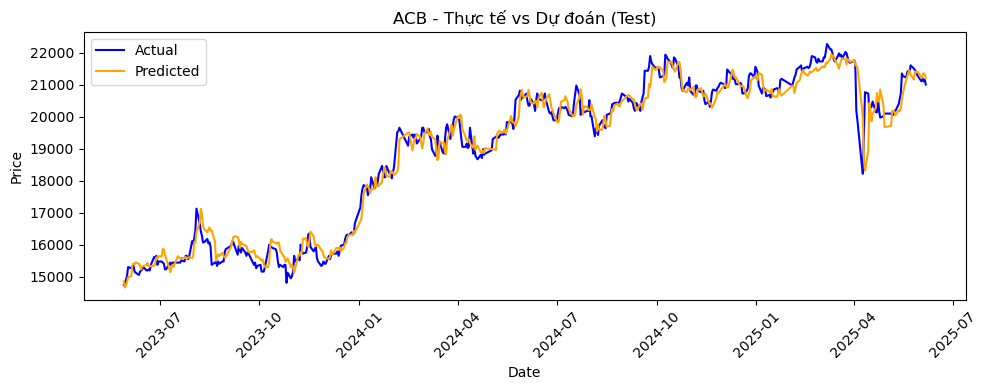

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:269: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast_all_df = pd.concat([forecast_all_df, forecast_df], ignore_index=True)
[I 2025-06-07 12:25:11,781] A new study created in memory with name: no-name-c653d20e-fede-4454-89bf-3abed13ab747



📅 Dự báo 30 phiên tới cho ACB:
2025-06-09: 21,473 VND
2025-06-10: 21,110 VND
2025-06-11: 20,905 VND
2025-06-12: 20,783 VND
2025-06-13: 20,705 VND
2025-06-16: 20,643 VND
2025-06-17: 20,646 VND
2025-06-18: 20,610 VND
2025-06-19: 20,576 VND
2025-06-20: 20,536 VND
2025-06-23: 20,548 VND
2025-06-24: 20,483 VND
2025-06-25: 20,615 VND
2025-06-26: 20,806 VND
2025-06-27: 21,069 VND
2025-06-30: 21,411 VND
2025-07-01: 21,768 VND
2025-07-02: 21,982 VND
2025-07-03: 22,065 VND
2025-07-04: 22,100 VND
2025-07-07: 22,018 VND
2025-07-08: 21,909 VND
2025-07-09: 21,786 VND
2025-07-10: 21,710 VND
2025-07-11: 21,600 VND
2025-07-14: 21,520 VND
2025-07-15: 21,385 VND
2025-07-16: 21,231 VND
2025-07-17: 21,115 VND
2025-07-18: 21,098 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:25:21,575] Trial 0 finished with value: 0.0009673410677351058 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.005555291771012728}. Best is trial 0 with value: 0.0009673410677351058.
[I 2025-06-07 12:25:35,704] Trial 1 finished with value: 0.002913512522354722 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.00021870359075268732}. Best is trial

  ↪ BCM: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.003616048200935784}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🔧 BiGRU+Attention (tuned) - BCM
📊 R²: 0.8551 | RMSE: 2,296.57 | MAE: 1,567.08 | MAPE: 2.44%


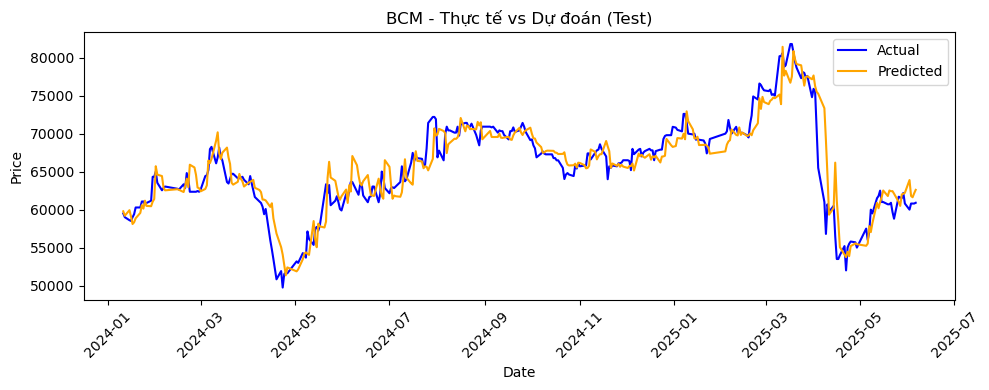

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:28:02,625] A new study created in memory with name: no-name-1d39ade5-9f69-40eb-84d5-3033a0f51c6c



📅 Dự báo 30 phiên tới cho BCM:
2025-06-09: 62,879 VND
2025-06-10: 64,295 VND
2025-06-11: 65,224 VND
2025-06-12: 66,037 VND
2025-06-13: 66,954 VND
2025-06-16: 67,223 VND
2025-06-17: 67,739 VND
2025-06-18: 68,288 VND
2025-06-19: 68,395 VND
2025-06-20: 68,605 VND
2025-06-23: 68,788 VND
2025-06-24: 68,845 VND
2025-06-25: 69,252 VND
2025-06-26: 69,722 VND
2025-06-27: 70,358 VND
2025-06-30: 69,949 VND
2025-07-01: 69,881 VND
2025-07-02: 69,185 VND
2025-07-03: 68,132 VND
2025-07-04: 67,399 VND
2025-07-07: 67,049 VND
2025-07-08: 67,483 VND
2025-07-09: 68,136 VND
2025-07-10: 67,605 VND
2025-07-11: 67,229 VND
2025-07-14: 66,582 VND
2025-07-15: 66,283 VND
2025-07-16: 65,903 VND
2025-07-17: 65,889 VND
2025-07-18: 65,942 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:28:15,585] Trial 0 finished with value: 0.0013209502212703228 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.000320174094713337}. Best is trial 0 with value: 0.0013209502212703228.
[I 2025-06-07 12:28:28,089] Trial 1 finished with value: 0.0007757434505037963 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.001832168092452603}. Best is trial 1 with value: 0.

  ↪ BID: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.001645120217759532}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

🔧 BiGRU+Attention (tuned) - BID
📊 R²: 0.9425 | RMSE: 875.27 | MAE: 628.00 | MAPE: 1.68%


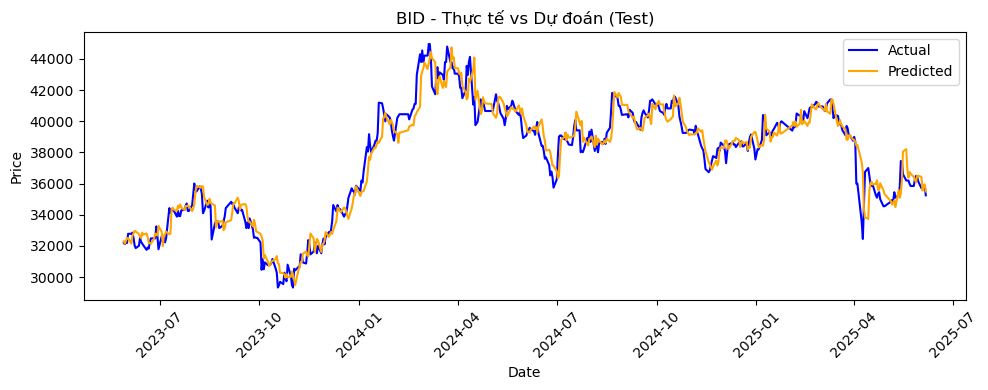

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho BID:
2025-06-09: 35,474 VND
2025-06-10: 35,667 VND
2025-06-11: 35,890 VND
2025-06-12: 35,931 VND
2025-06-13: 35,893 VND
2025-06-16: 35,901 VND
2025-06-17: 35,973 VND
2025-06-18: 35,989 VND
2025-06-19: 36,060 VND
2025-06-20: 36,035 VND
2025-06-23: 36,118 VND
2025-06-24: 36,173 VND
2025-06-25: 36,200 VND
2025-06-26: 36,136 VND
2025-06-27: 36,000 VND
2025-06-30: 35,936 VND
2025-07-01: 35,840 VND
2025-07-02: 35,649 VND
2025-07-03: 35,472 VND
2025-07-04: 35,431 VND
2025-07-07: 35,255 VND
2025-07-08: 35,136 VND
2025-07-09: 35,011 VND
2025-07-10: 35,075 VND
2025-07-11: 35,061 VND
2025-07-14: 34,958 VND
2025-07-15: 34,744 VND
2025-07-16: 34,598 VND
2025-07-17: 34,483 VND
2025-07-18: 34,391 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:31:38,121] A new study created in memory with name: no-name-0b1deddb-b7bb-4a5b-a5bb-050de4cbdb6e
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

  ↪ BVH: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.007316974930646496}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

🔧 BiGRU+Attention (tuned) - BVH
📊 R²: 0.9430 | RMSE: 1,139.86 | MAE: 756.30 | MAPE: 1.69%


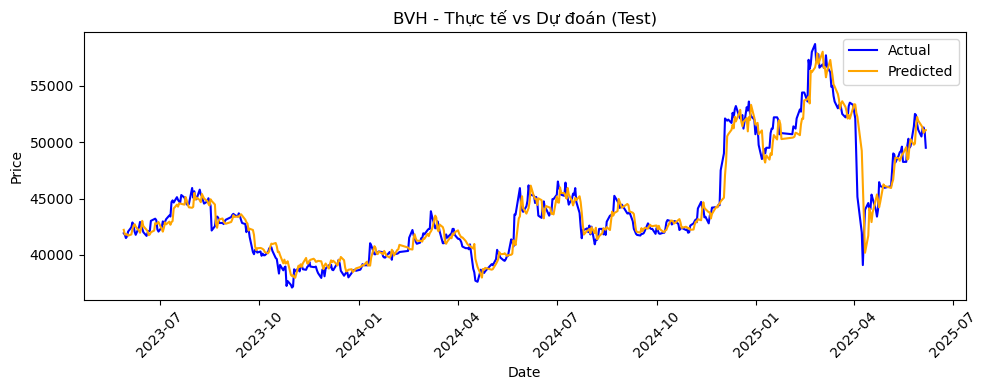

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho BVH:
2025-06-09: 50,423 VND
2025-06-10: 49,418 VND
2025-06-11: 48,378 VND
2025-06-12: 48,143 VND
2025-06-13: 48,545 VND
2025-06-16: 48,769 VND
2025-06-17: 48,859 VND
2025-06-18: 48,665 VND
2025-06-19: 48,507 VND
2025-06-20: 48,469 VND
2025-06-23: 48,621 VND
2025-06-24: 48,574 VND
2025-06-25: 48,709 VND
2025-06-26: 48,904 VND
2025-06-27: 49,124 VND
2025-06-30: 49,309 VND
2025-07-01: 49,563 VND
2025-07-02: 49,656 VND
2025-07-03: 49,609 VND
2025-07-04: 49,313 VND
2025-07-07: 48,957 VND
2025-07-08: 48,564 VND
2025-07-09: 48,442 VND
2025-07-10: 47,977 VND
2025-07-11: 47,584 VND
2025-07-14: 47,171 VND
2025-07-15: 46,747 VND
2025-07-16: 46,372 VND
2025-07-17: 46,144 VND
2025-07-18: 45,997 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:36:21,759] A new study created in memory with name: no-name-07fb744e-5ca1-4563-bd7c-44648da545d7
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

  ↪ CTG: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.0007417493858417392}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

🔧 BiGRU+Attention (tuned) - CTG
📊 R²: 0.9677 | RMSE: 865.67 | MAE: 625.12 | MAPE: 1.88%


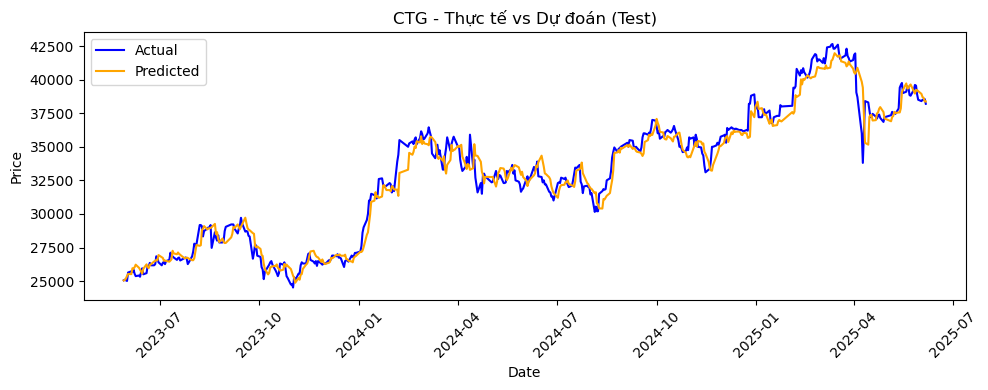

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:39:29,212] A new study created in memory with name: no-name-e3ce3082-6c46-4e48-a2fa-b766048a50b5



📅 Dự báo 30 phiên tới cho CTG:
2025-06-09: 37,511 VND
2025-06-10: 37,149 VND
2025-06-11: 36,841 VND
2025-06-12: 36,629 VND
2025-06-13: 36,468 VND
2025-06-16: 36,433 VND
2025-06-17: 36,491 VND
2025-06-18: 36,479 VND
2025-06-19: 36,409 VND
2025-06-20: 36,293 VND
2025-06-23: 36,189 VND
2025-06-24: 36,215 VND
2025-06-25: 36,219 VND
2025-06-26: 36,181 VND
2025-06-27: 36,114 VND
2025-06-30: 35,960 VND
2025-07-01: 35,897 VND
2025-07-02: 36,124 VND
2025-07-03: 36,300 VND
2025-07-04: 36,293 VND
2025-07-07: 36,251 VND
2025-07-08: 36,007 VND
2025-07-09: 35,805 VND
2025-07-10: 35,594 VND
2025-07-11: 35,508 VND
2025-07-14: 35,488 VND
2025-07-15: 35,418 VND
2025-07-16: 35,302 VND
2025-07-17: 35,211 VND
2025-07-18: 35,065 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:39:57,417] Trial 0 finished with value: 0.0018195636803284287 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0013038389051835797}. Best is trial 0 with value: 0.0018195636803284287.
[I 2025-06-07 12:40:16,389] Trial 1 finished with value: 0.001082347589544952 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.008173726508957277}. Best is trial 

  ↪ FPT: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.008173726508957277}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

🔧 BiGRU+Attention (tuned) - FPT
📊 R²: 0.9664 | RMSE: 5,062.01 | MAE: 3,550.19 | MAPE: 3.25%


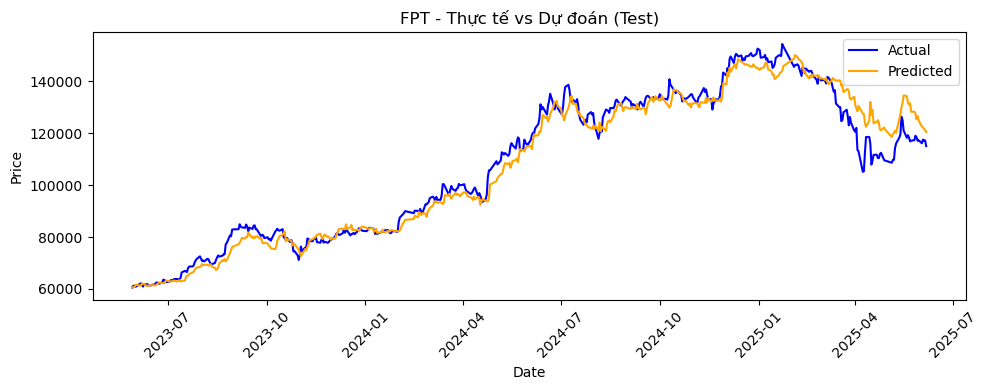

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:43:51,835] A new study created in memory with name: no-name-e1909c7d-b01c-44b0-b667-0081e23b4628



📅 Dự báo 30 phiên tới cho FPT:
2025-06-09: 120,285 VND
2025-06-10: 120,230 VND
2025-06-11: 121,575 VND
2025-06-12: 124,649 VND
2025-06-13: 125,758 VND
2025-06-16: 127,532 VND
2025-06-17: 131,232 VND
2025-06-18: 131,416 VND
2025-06-19: 132,787 VND
2025-06-20: 133,657 VND
2025-06-23: 136,010 VND
2025-06-24: 136,414 VND
2025-06-25: 136,255 VND
2025-06-26: 136,718 VND
2025-06-27: 136,412 VND
2025-06-30: 136,013 VND
2025-07-01: 134,870 VND
2025-07-02: 133,372 VND
2025-07-03: 130,729 VND
2025-07-04: 128,570 VND
2025-07-07: 126,700 VND
2025-07-08: 124,457 VND
2025-07-09: 123,553 VND
2025-07-10: 123,984 VND
2025-07-11: 123,826 VND
2025-07-14: 125,707 VND
2025-07-15: 123,861 VND
2025-07-16: 121,464 VND
2025-07-17: 119,456 VND
2025-07-18: 119,618 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:44:19,299] Trial 0 finished with value: 0.0005279835313558578 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0008541440299846731}. Best is trial 0 with value: 0.0005279835313558578.
[I 2025-06-07 12:44:39,590] Trial 1 finished with value: 0.0007041446515358984 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00018994132249682032}. Best is tri

  ↪ GAS: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.0032174221759576405}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

🔧 BiGRU+Attention (tuned) - GAS
📊 R²: 0.8939 | RMSE: 1,466.23 | MAE: 992.39 | MAPE: 1.43%


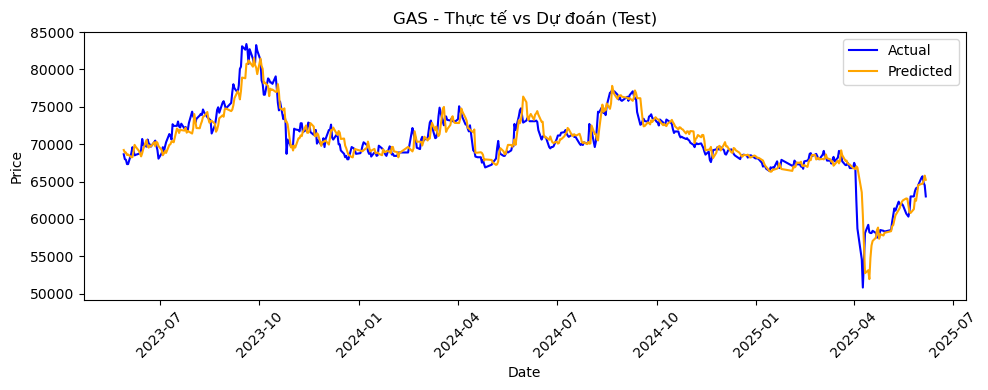

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:48:36,956] A new study created in memory with name: no-name-5010eb47-9b99-4cce-a399-902e6f3165ac
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/


📅 Dự báo 30 phiên tới cho GAS:
2025-06-09: 57,205 VND
2025-06-10: 55,554 VND
2025-06-11: 56,771 VND
2025-06-12: 58,145 VND
2025-06-13: 58,927 VND
2025-06-16: 58,631 VND
2025-06-17: 58,753 VND
2025-06-18: 58,955 VND
2025-06-19: 58,917 VND
2025-06-20: 58,958 VND
2025-06-23: 59,246 VND
2025-06-24: 60,143 VND
2025-06-25: 60,499 VND
2025-06-26: 60,642 VND
2025-06-27: 61,153 VND
2025-06-30: 62,080 VND
2025-07-01: 63,325 VND
2025-07-02: 64,219 VND
2025-07-03: 64,302 VND
2025-07-04: 64,228 VND
2025-07-07: 64,191 VND
2025-07-08: 64,968 VND
2025-07-09: 65,498 VND
2025-07-10: 64,614 VND
2025-07-11: 64,490 VND
2025-07-14: 64,818 VND
2025-07-15: 64,971 VND
2025-07-16: 64,928 VND
2025-07-17: 64,995 VND
2025-07-18: 64,980 VND


[I 2025-06-07 12:48:48,061] Trial 0 finished with value: 0.00378150912001729 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.00010728301811663399}. Best is trial 0 with value: 0.00378150912001729.
[I 2025-06-07 12:49:09,514] Trial 1 finished with value: 0.001224662410095334 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0013570699376037726}. Best is trial 1 with value: 0.001224662410095334.
[I 2025-06-07 12:49:20,069] Trial 2 finished with value: 0.0012916434789076447 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.006509394506134583}. Best is trial 1 with value: 0.001224662410095334.
[I 2025-06-07 12:49:27,814] Trial 3 finished with value: 0.0027755126357078552 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0002907459029149552}. Best is trial 1 with value: 0.001224662410095334.
[I 2025-06-07 12:49:42,412] Trial 4 finished with value: 0.002565056551247835 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0003141339349809375}

  ↪ GVR: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.004865884554609633}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

🔧 BiGRU+Attention (tuned) - GVR
📊 R²: 0.9038 | RMSE: 1,162.39 | MAE: 855.69 | MAPE: 2.82%


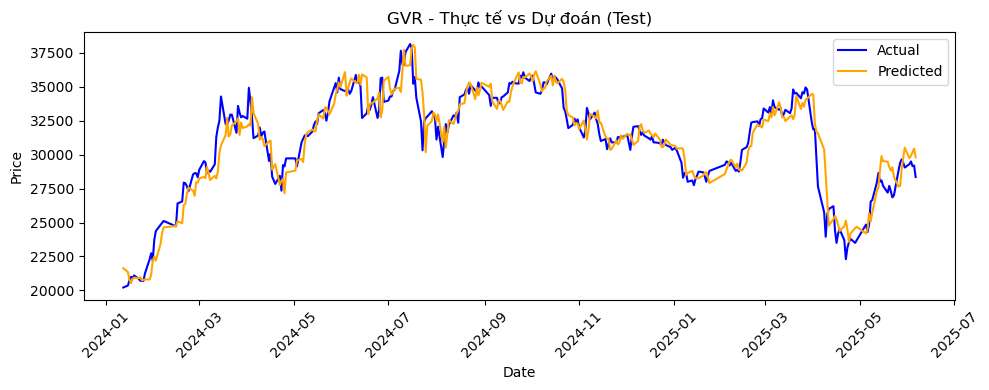

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:51:10,981] A new study created in memory with name: no-name-06b70872-50a9-4bb1-9a49-b1712af31efc



📅 Dự báo 30 phiên tới cho GVR:
2025-06-09: 29,107 VND
2025-06-10: 29,471 VND
2025-06-11: 30,001 VND
2025-06-12: 30,358 VND
2025-06-13: 30,719 VND
2025-06-16: 31,398 VND
2025-06-17: 32,101 VND
2025-06-18: 31,799 VND
2025-06-19: 32,156 VND
2025-06-20: 32,421 VND
2025-06-23: 33,026 VND
2025-06-24: 33,143 VND
2025-06-25: 33,526 VND
2025-06-26: 33,812 VND
2025-06-27: 34,120 VND
2025-06-30: 34,095 VND
2025-07-01: 34,059 VND
2025-07-02: 34,007 VND
2025-07-03: 33,879 VND
2025-07-04: 33,694 VND
2025-07-07: 33,561 VND
2025-07-08: 33,628 VND
2025-07-09: 34,087 VND
2025-07-10: 33,709 VND
2025-07-11: 33,459 VND
2025-07-14: 33,285 VND
2025-07-15: 33,115 VND
2025-07-16: 32,769 VND
2025-07-17: 32,441 VND
2025-07-18: 32,266 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:51:32,416] Trial 0 finished with value: 0.0008905394934117794 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.008994108041292371}. Best is trial 0 with value: 0.0008905394934117794.
[I 2025-06-07 12:51:57,330] Trial 1 finished with value: 0.001058568013831973 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00023629103528096748}. Best is trial

  ↪ HDB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.004102961427196987}
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

🔧 BiGRU+Attention (tuned) - HDB
📊 R²: 0.9236 | RMSE: 585.62 | MAE: 401.65 | MAPE: 1.93%


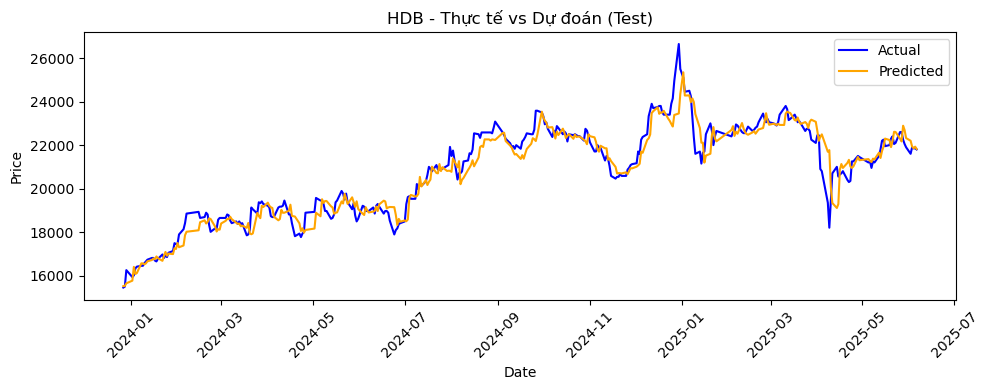

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



📅 Dự báo 30 phiên tới cho HDB:
2025-06-09: 21,548 VND
2025-06-10: 21,589 VND
2025-06-11: 21,696 VND
2025-06-12: 21,822 VND
2025-06-13: 21,898 VND
2025-06-16: 21,944 VND
2025-06-17: 22,019 VND
2025-06-18: 22,042 VND
2025-06-19: 22,107 VND
2025-06-20: 22,228 VND
2025-06-23: 22,357 VND
2025-06-24: 22,438 VND
2025-06-25: 22,472 VND
2025-06-26: 22,533 VND
2025-06-27: 22,663 VND
2025-06-30: 22,782 VND
2025-07-01: 22,965 VND
2025-07-02: 23,172 VND
2025-07-03: 23,151 VND
2025-07-04: 23,187 VND
2025-07-07: 23,267 VND
2025-07-08: 23,538 VND
2025-07-09: 23,839 VND
2025-07-10: 23,709 VND
2025-07-11: 23,578 VND
2025-07-14: 23,522 VND
2025-07-15: 23,540 VND
2025-07-16: 23,518 VND
2025-07-17: 23,451 VND
2025-07-18: 23,184 VND


[I 2025-06-07 12:54:06,736] A new study created in memory with name: no-name-370817dd-98a1-40f0-92a4-695985d65f90
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:54:21,810] Trial 0 finished with value: 0.00048103657900355756 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0016800346191023852}. Best is trial 0 with value: 0.00048103657900355756.
[I 2025-06-07 12:54:30,942] Trial 1 finished with value: 0.00101247

  ↪ HPG: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.0007741047053313445}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 BiGRU+Attention (tuned) - HPG
📊 R²: 0.8748 | RMSE: 684.04 | MAE: 509.84 | MAPE: 2.01%


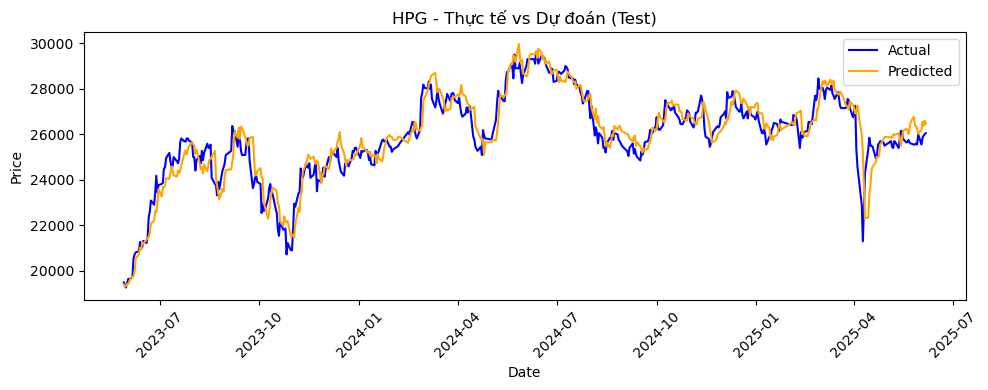

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 12:57:28,811] A new study created in memory with name: no-name-15daa716-0156-493f-8b60-eb8a61122aec



📅 Dự báo 30 phiên tới cho HPG:
2025-06-09: 26,805 VND
2025-06-10: 26,640 VND
2025-06-11: 26,457 VND
2025-06-12: 26,594 VND
2025-06-13: 26,979 VND
2025-06-16: 27,296 VND
2025-06-17: 27,618 VND
2025-06-18: 27,814 VND
2025-06-19: 28,039 VND
2025-06-20: 28,348 VND
2025-06-23: 28,692 VND
2025-06-24: 28,953 VND
2025-06-25: 29,194 VND
2025-06-26: 29,671 VND
2025-06-27: 30,261 VND
2025-06-30: 31,082 VND
2025-07-01: 32,062 VND
2025-07-02: 32,751 VND
2025-07-03: 32,980 VND
2025-07-04: 32,960 VND
2025-07-07: 32,986 VND
2025-07-08: 33,420 VND
2025-07-09: 34,026 VND
2025-07-10: 34,230 VND
2025-07-11: 34,055 VND
2025-07-14: 33,674 VND
2025-07-15: 33,262 VND
2025-07-16: 32,856 VND
2025-07-17: 32,570 VND
2025-07-18: 32,576 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 12:57:50,300] Trial 0 finished with value: 0.0038981607649475336 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.00020795350490285873}. Best is trial 0 with value: 0.0038981607649475336.
[I 2025-06-07 12:58:00,753] Trial 1 finished with value: 0.0005841874517500401 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0039773789245250305}. Best is tri

  ↪ LPB: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.0039773789245250305}
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

🔧 BiGRU+Attention (tuned) - LPB
📊 R²: 0.9733 | RMSE: 1,136.69 | MAE: 822.71 | MAPE: 3.28%


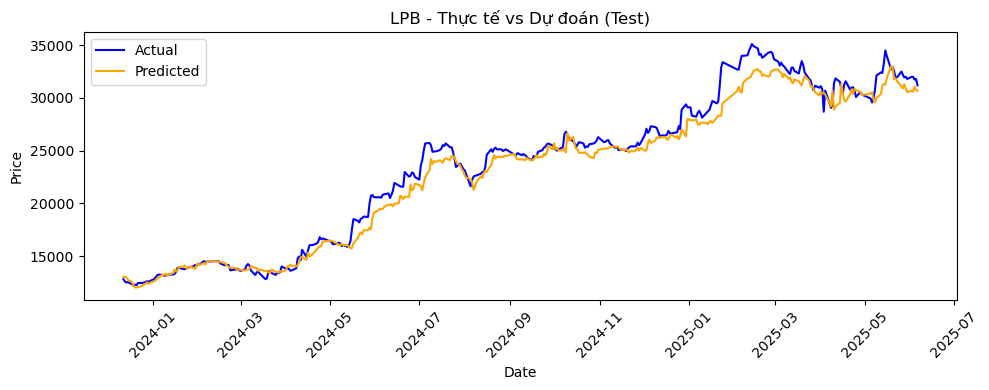

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:00:17,392] A new study created in memory with name: no-name-b8f069da-c668-42b0-8388-84f38e969aa5



📅 Dự báo 30 phiên tới cho LPB:
2025-06-09: 30,785 VND
2025-06-10: 29,756 VND
2025-06-11: 28,686 VND
2025-06-12: 28,047 VND
2025-06-13: 27,723 VND
2025-06-16: 27,699 VND
2025-06-17: 27,311 VND
2025-06-18: 27,159 VND
2025-06-19: 27,261 VND
2025-06-20: 27,122 VND
2025-06-23: 26,892 VND
2025-06-24: 26,676 VND
2025-06-25: 26,449 VND
2025-06-26: 26,325 VND
2025-06-27: 26,236 VND
2025-06-30: 25,900 VND
2025-07-01: 26,116 VND
2025-07-02: 26,873 VND
2025-07-03: 27,927 VND
2025-07-04: 28,000 VND
2025-07-07: 27,752 VND
2025-07-08: 27,175 VND
2025-07-09: 27,528 VND
2025-07-10: 27,027 VND
2025-07-11: 27,078 VND
2025-07-14: 26,913 VND
2025-07-15: 27,141 VND
2025-07-16: 27,196 VND
2025-07-17: 27,242 VND
2025-07-18: 27,912 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:00:31,992] Trial 0 finished with value: 0.0009140887414105237 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0017135039165953243}. Best is trial 0 with value: 0.0009140887414105237.
[I 2025-06-07 13:00:48,031] Trial 1 finished with value: 0.0005839295336045325 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0007844832195018801}. Best is tria

  ↪ MBB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.006222829697205945}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 BiGRU+Attention (tuned) - MBB
📊 R²: 0.9778 | RMSE: 457.15 | MAE: 327.16 | MAPE: 1.66%


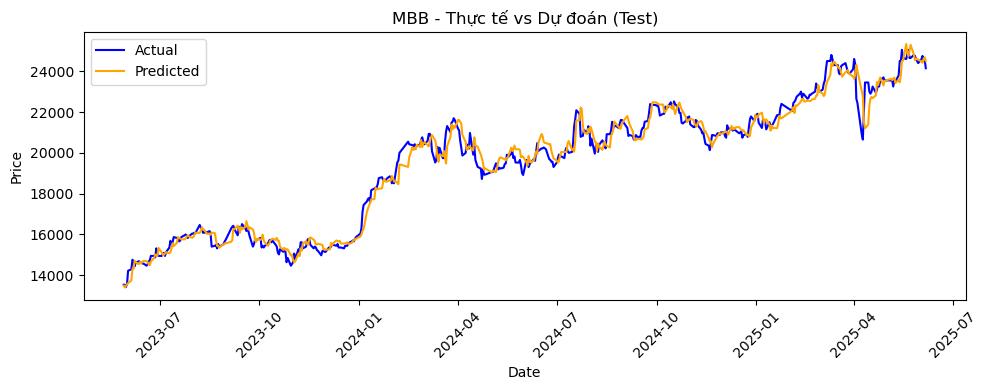

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:03:12,537] A new study created in memory with name: no-name-0d73f5dd-2034-44fc-ab9e-d6cd56041de7



📅 Dự báo 30 phiên tới cho MBB:
2025-06-09: 24,124 VND
2025-06-10: 24,030 VND
2025-06-11: 24,032 VND
2025-06-12: 24,121 VND
2025-06-13: 24,189 VND
2025-06-16: 24,265 VND
2025-06-17: 24,385 VND
2025-06-18: 24,503 VND
2025-06-19: 24,627 VND
2025-06-20: 24,691 VND
2025-06-23: 24,808 VND
2025-06-24: 24,948 VND
2025-06-25: 25,143 VND
2025-06-26: 25,354 VND
2025-06-27: 25,629 VND
2025-06-30: 25,888 VND
2025-07-01: 26,170 VND
2025-07-02: 26,368 VND
2025-07-03: 26,676 VND
2025-07-04: 26,766 VND
2025-07-07: 26,624 VND
2025-07-08: 26,545 VND
2025-07-09: 26,239 VND
2025-07-10: 26,324 VND
2025-07-11: 26,286 VND
2025-07-14: 26,216 VND
2025-07-15: 26,134 VND
2025-07-16: 25,958 VND
2025-07-17: 25,690 VND
2025-07-18: 25,317 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:03:23,310] Trial 0 finished with value: 0.000547669013030827 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.004284906803180773}. Best is trial 0 with value: 0.000547669013030827.
[I 2025-06-07 13:03:38,470] Trial 1 finished with value: 0.0008081947453320026 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0066804934209273}. Best is trial 0 with value: 0.0005

  ↪ MSN: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.005888124595277649}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

🔧 BiGRU+Attention (tuned) - MSN
📊 R²: 0.8318 | RMSE: 2,660.17 | MAE: 1,969.32 | MAPE: 2.77%


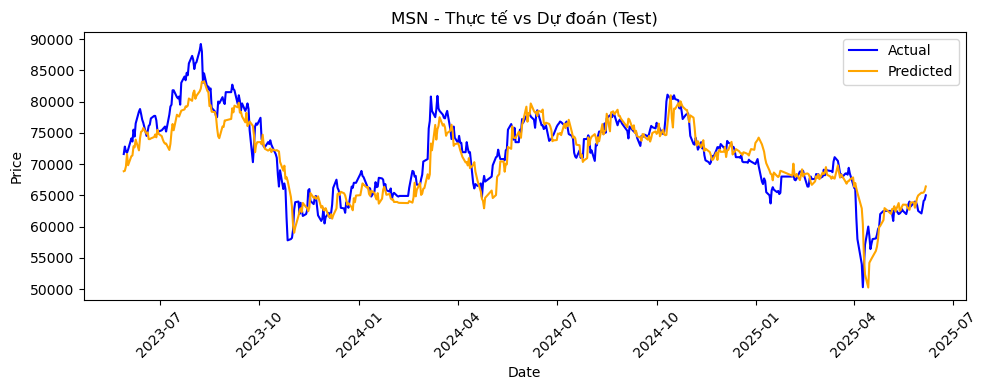

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:05:44,230] A new study created in memory with name: no-name-84a6c32e-447a-48dd-b079-69c987cd946d



📅 Dự báo 30 phiên tới cho MSN:
2025-06-09: 66,100 VND
2025-06-10: 66,452 VND
2025-06-11: 66,679 VND
2025-06-12: 66,836 VND
2025-06-13: 67,082 VND
2025-06-16: 67,346 VND
2025-06-17: 67,433 VND
2025-06-18: 67,502 VND
2025-06-19: 67,810 VND
2025-06-20: 68,481 VND
2025-06-23: 69,352 VND
2025-06-24: 70,388 VND
2025-06-25: 71,375 VND
2025-06-26: 71,813 VND
2025-06-27: 72,281 VND
2025-06-30: 73,367 VND
2025-07-01: 74,846 VND
2025-07-02: 75,859 VND
2025-07-03: 75,382 VND
2025-07-04: 74,765 VND
2025-07-07: 74,742 VND
2025-07-08: 74,719 VND
2025-07-09: 74,134 VND
2025-07-10: 73,913 VND
2025-07-11: 73,133 VND
2025-07-14: 72,337 VND
2025-07-15: 71,809 VND
2025-07-16: 71,304 VND
2025-07-17: 71,193 VND
2025-07-18: 71,380 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:05:56,054] Trial 0 finished with value: 0.002275606384500861 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.001318025991678121}. Best is trial 0 with value: 0.002275606384500861.
[I 2025-06-07 13:06:14,782] Trial 1 finished with value: 0.0014781933277845383 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0005091404540498682}. Best is trial 1

  ↪ MWG: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0005091404540498682}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 BiGRU+Attention (tuned) - MWG
📊 R²: 0.9042 | RMSE: 2,806.09 | MAE: 2,200.33 | MAPE: 4.14%


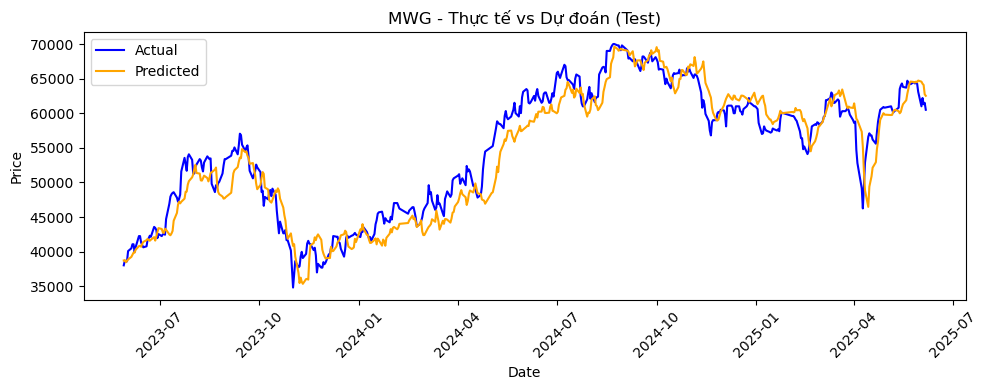

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:08:14,181] A new study created in memory with name: no-name-aa0db6e9-8359-48ff-98ba-16fc59bce4e9



📅 Dự báo 30 phiên tới cho MWG:
2025-06-09: 62,879 VND
2025-06-10: 60,967 VND
2025-06-11: 60,922 VND
2025-06-12: 60,796 VND
2025-06-13: 60,684 VND
2025-06-16: 60,519 VND
2025-06-17: 60,738 VND
2025-06-18: 61,653 VND
2025-06-19: 61,804 VND
2025-06-20: 62,002 VND
2025-06-23: 62,152 VND
2025-06-24: 62,181 VND
2025-06-25: 62,299 VND
2025-06-26: 62,462 VND
2025-06-27: 62,701 VND
2025-06-30: 62,988 VND
2025-07-01: 62,915 VND
2025-07-02: 62,420 VND
2025-07-03: 62,156 VND
2025-07-04: 61,929 VND
2025-07-07: 61,526 VND
2025-07-08: 62,688 VND
2025-07-09: 62,339 VND
2025-07-10: 62,642 VND
2025-07-11: 62,280 VND
2025-07-14: 62,070 VND
2025-07-15: 62,089 VND
2025-07-16: 61,745 VND
2025-07-17: 62,326 VND
2025-07-18: 62,903 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:08:32,133] Trial 0 finished with value: 0.0005866349674761295 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0003495185156083816}. Best is trial 0 with value: 0.0005866349674761295.
[I 2025-06-07 13:08:58,537] Trial 1 finished with value: 0.0006367926253005862 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0007133257890123385}. Best is trial 0 with value: 

  ↪ PLX: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.002072270634473318}
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

🔧 BiGRU+Attention (tuned) - PLX
📊 R²: 0.9522 | RMSE: 1,050.82 | MAE: 728.55 | MAPE: 1.87%


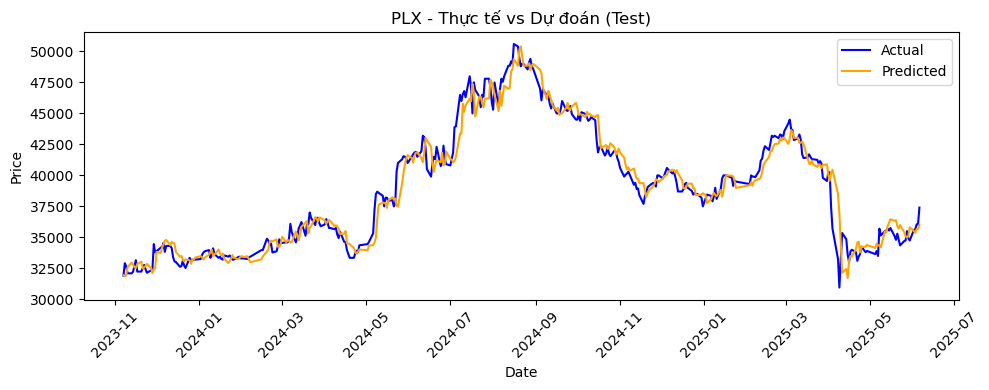

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:12:02,156] A new study created in memory with name: no-name-d04f14a3-c474-4c88-bed0-ab177ae248e1



📅 Dự báo 30 phiên tới cho PLX:
2025-06-09: 36,024 VND
2025-06-10: 35,575 VND
2025-06-11: 35,726 VND
2025-06-12: 35,962 VND
2025-06-13: 36,217 VND
2025-06-16: 36,383 VND
2025-06-17: 36,314 VND
2025-06-18: 36,371 VND
2025-06-19: 36,426 VND
2025-06-20: 36,471 VND
2025-06-23: 36,468 VND
2025-06-24: 36,583 VND
2025-06-25: 36,800 VND
2025-06-26: 36,986 VND
2025-06-27: 37,123 VND
2025-06-30: 37,371 VND
2025-07-01: 37,761 VND
2025-07-02: 38,134 VND
2025-07-03: 38,188 VND
2025-07-04: 38,003 VND
2025-07-07: 38,029 VND
2025-07-08: 38,666 VND
2025-07-09: 40,267 VND
2025-07-10: 39,265 VND
2025-07-11: 38,767 VND
2025-07-14: 38,556 VND
2025-07-15: 38,457 VND
2025-07-16: 38,472 VND
2025-07-17: 38,422 VND
2025-07-18: 38,390 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:12:09,122] Trial 0 finished with value: 0.0015570522518828511 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0013233221600767802}. Best is trial 0 with value: 0.0015570522518828511.
[I 2025-06-07 13:12:32,787] Trial 1 finished with value: 0.0005302787758409977 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0006822798231880575}. Best is trial 1 with value: 

  ↪ SAB: Chọn params từ Optuna: {'units': 32, 'dropout': 0.4, 'lr': 0.00373445968447067}
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

🔧 BiGRU+Attention (tuned) - SAB
📊 R²: 0.5620 | RMSE: 2,244.65 | MAE: 1,561.70 | MAPE: 2.87%


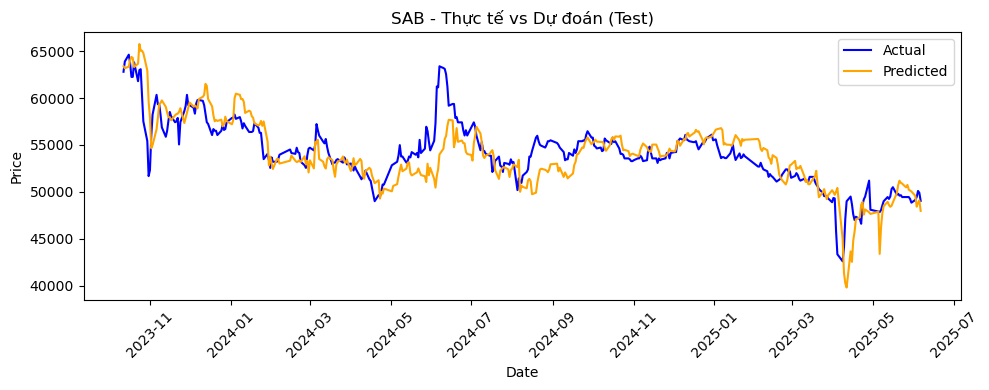

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:14:56,326] A new study created in memory with name: no-name-b25a12a6-5314-4f1d-bdc9-62a0b74366e1



📅 Dự báo 30 phiên tới cho SAB:
2025-06-09: 48,379 VND
2025-06-10: 47,856 VND
2025-06-11: 47,383 VND
2025-06-12: 46,837 VND
2025-06-13: 46,249 VND
2025-06-16: 45,691 VND
2025-06-17: 45,378 VND
2025-06-18: 45,196 VND
2025-06-19: 44,890 VND
2025-06-20: 44,608 VND
2025-06-23: 44,417 VND
2025-06-24: 44,211 VND
2025-06-25: 43,829 VND
2025-06-26: 43,195 VND
2025-06-27: 42,273 VND
2025-06-30: 40,943 VND
2025-07-01: 39,239 VND
2025-07-02: 37,737 VND
2025-07-03: 37,164 VND
2025-07-04: 37,544 VND
2025-07-07: 37,595 VND
2025-07-08: 37,034 VND
2025-07-09: 36,771 VND
2025-07-10: 37,203 VND
2025-07-11: 37,954 VND
2025-07-14: 38,870 VND
2025-07-15: 39,673 VND
2025-07-16: 40,383 VND
2025-07-17: 40,246 VND
2025-07-18: 39,894 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:15:21,137] Trial 0 finished with value: 0.0004108898574486375 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0005900414922156518}. Best is trial 0 with value: 0.0004108898574486375.
[I 2025-06-07 13:15:36,047] Trial 1 finished with value: 0.0004936724435538054 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0017268494099598314}. Best is tria

  ↪ SHB: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.00453519605879304}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

🔧 BiGRU+Attention (tuned) - SHB
📊 R²: 0.9353 | RMSE: 276.96 | MAE: 189.51 | MAPE: 1.81%


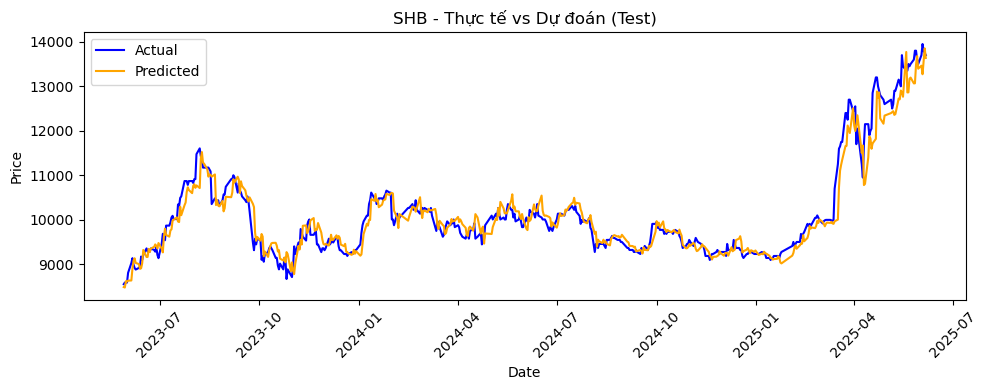

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:18:55,491] A new study created in memory with name: no-name-c327e7f9-2ad7-46c7-9c52-1ec819cc3c84



📅 Dự báo 30 phiên tới cho SHB:
2025-06-09: 12,005 VND
2025-06-10: 12,529 VND
2025-06-11: 12,953 VND
2025-06-12: 13,178 VND
2025-06-13: 13,356 VND
2025-06-16: 13,472 VND
2025-06-17: 13,514 VND
2025-06-18: 13,549 VND
2025-06-19: 13,628 VND
2025-06-20: 13,714 VND
2025-06-23: 13,785 VND
2025-06-24: 13,944 VND
2025-06-25: 13,951 VND
2025-06-26: 13,937 VND
2025-06-27: 13,961 VND
2025-06-30: 13,981 VND
2025-07-01: 14,014 VND
2025-07-02: 14,110 VND
2025-07-03: 14,149 VND
2025-07-04: 14,171 VND
2025-07-07: 14,155 VND
2025-07-08: 14,090 VND
2025-07-09: 14,122 VND
2025-07-10: 14,132 VND
2025-07-11: 14,173 VND
2025-07-14: 14,183 VND
2025-07-15: 14,194 VND
2025-07-16: 14,220 VND
2025-07-17: 14,261 VND
2025-07-18: 14,394 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:19:05,297] Trial 0 finished with value: 0.003528635948896408 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.00011422845415180612}. Best is trial 0 with value: 0.003528635948896408.
[I 2025-06-07 13:19:17,925] Trial 1 finished with value: 0.004245624877512455 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0004345160908158037}. Best is trial 0 with value: 0.

  ↪ SSB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.007591375904670679}
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

🔧 BiGRU+Attention (tuned) - SSB
📊 R²: 0.8185 | RMSE: 522.89 | MAE: 361.90 | MAPE: 2.04%


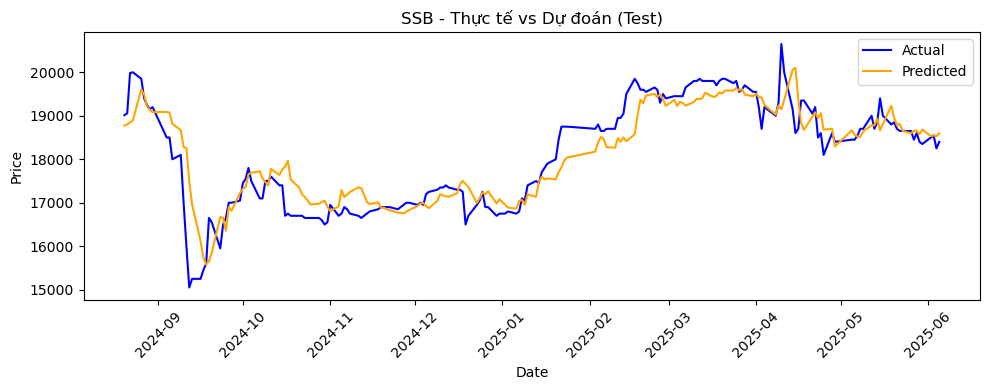

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:21:12,494] A new study created in memory with name: no-name-93b2eb14-8c80-48b4-a2a5-922967141697



📅 Dự báo 30 phiên tới cho SSB:
2025-06-06: 18,519 VND
2025-06-09: 18,783 VND
2025-06-10: 19,160 VND
2025-06-11: 19,537 VND
2025-06-12: 19,852 VND
2025-06-13: 20,126 VND
2025-06-16: 20,358 VND
2025-06-17: 20,525 VND
2025-06-18: 20,638 VND
2025-06-19: 20,780 VND
2025-06-20: 20,943 VND
2025-06-23: 21,083 VND
2025-06-24: 21,179 VND
2025-06-25: 21,244 VND
2025-06-26: 21,272 VND
2025-06-27: 21,280 VND
2025-06-30: 21,283 VND
2025-07-01: 21,304 VND
2025-07-02: 21,374 VND
2025-07-03: 21,480 VND
2025-07-04: 21,577 VND
2025-07-07: 21,626 VND
2025-07-08: 21,771 VND
2025-07-09: 21,899 VND
2025-07-10: 21,952 VND
2025-07-11: 21,964 VND
2025-07-14: 21,949 VND
2025-07-15: 21,994 VND
2025-07-16: 22,005 VND
2025-07-17: 22,036 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:21:41,103] Trial 0 finished with value: 0.0008210731903091073 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.00046831891072157255}. Best is trial 0 with value: 0.0008210731903091073.
[I 2025-06-07 13:21:49,666] Trial 1 finished with value: 0.0008087836904451251 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.004286329028786022}. Best is tria

  ↪ SSI: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.0003918755263301649}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 BiGRU+Attention (tuned) - SSI
📊 R²: 0.8722 | RMSE: 858.18 | MAE: 660.84 | MAPE: 2.64%


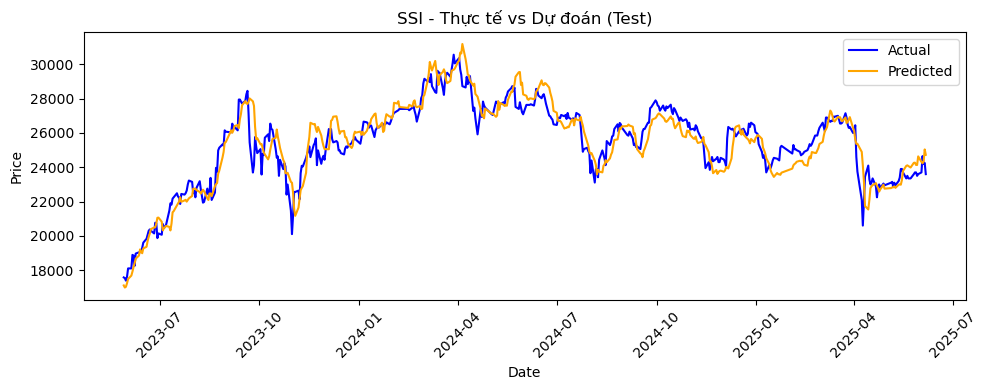

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

📅 Dự báo 30 phiên tới cho SSI:
2025-06-09: 21,753 VND
2025-06-10: 22,741 VND
2025-06-11: 23,527 VND
2025-06-12: 23,385 VND
2025-06-13: 23,402 VND
2025-06-16: 23,878 VND
2025-06-17: 24,071 VND
2025-06-18: 24,217 VND
2025-06-19: 24,450 VND
2025-06-20: 24,690 VND
2025-06-23: 24,927 VND
2025-06-24: 25,303 VND
2025-06-25: 25,407 VND
2025-06-26: 25,663 VND
2025-06-27: 25,932 VND
2025-06-30: 26,056 VND
2025-07-01: 26,151 VND
2025-07-02: 26,897 VND
2025-07-03: 27,412 VND
2025-07-04: 27,055 VND
2025-07-07: 27,764 VND
2025-07-08: 27,056 VND
2025-07-09: 27,668 VND
2025-07-10: 27,834 VND
2025-07-11: 27,687 VND
2025-07-14: 27,669 VND
2025-07-15: 27,714 VND
2025-07-16: 27,748 VND
2025-07-17: 27,593 VND
2025-07-18: 27,942 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:24:53,441] A new study created in memory with name: no-name-3c770ee9-9f92-4ef3-b05f-38c9a5ce6b2b
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the firs

  ↪ STB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0008839976087960268}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

🔧 BiGRU+Attention (tuned) - STB
📊 R²: 0.9035 | RMSE: 1,217.02 | MAE: 897.89 | MAPE: 2.86%


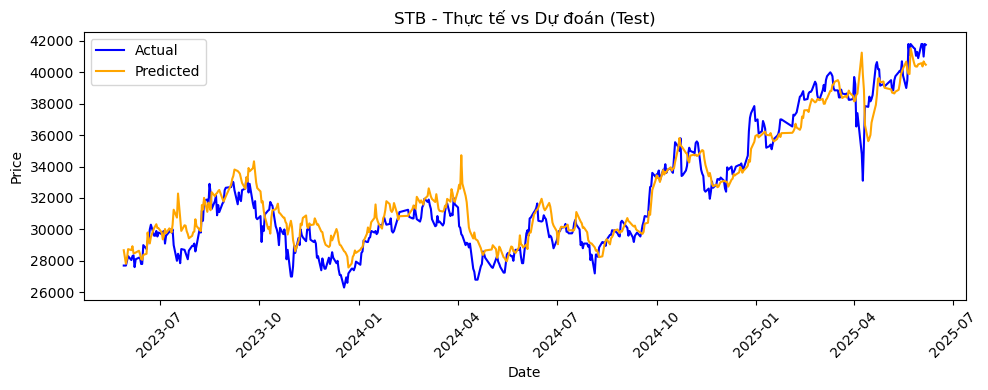

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:28:31,943] A new study created in memory with name: no-name-5e92a62b-0123-42c9-8b27-00168c2d7110



📅 Dự báo 30 phiên tới cho STB:
2025-06-09: 40,970 VND
2025-06-10: 41,027 VND
2025-06-11: 41,430 VND
2025-06-12: 41,868 VND
2025-06-13: 42,200 VND
2025-06-16: 42,482 VND
2025-06-17: 42,600 VND
2025-06-18: 42,697 VND
2025-06-19: 42,885 VND
2025-06-20: 43,106 VND
2025-06-23: 43,442 VND
2025-06-24: 43,962 VND
2025-06-25: 44,186 VND
2025-06-26: 44,591 VND
2025-06-27: 44,834 VND
2025-06-30: 44,888 VND
2025-07-01: 44,618 VND
2025-07-02: 44,102 VND
2025-07-03: 44,698 VND
2025-07-04: 44,397 VND
2025-07-07: 45,176 VND
2025-07-08: 45,145 VND
2025-07-09: 45,554 VND
2025-07-10: 45,039 VND
2025-07-11: 45,060 VND
2025-07-14: 45,296 VND
2025-07-15: 45,409 VND
2025-07-16: 45,471 VND
2025-07-17: 45,527 VND
2025-07-18: 45,416 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:28:43,051] Trial 0 finished with value: 0.005092979874461889 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0001191550184314906}. Best is trial 0 with value: 0.005092979874461889.
[I 2025-06-07 13:28:53,248] Trial 1 finished with value: 0.0017477745423093438 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0016768707406763267}. Best is trial 1 with value: 0.

  ↪ TCB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.003776466333231523}
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

🔧 BiGRU+Attention (tuned) - TCB
📊 R²: 0.9063 | RMSE: 834.19 | MAE: 628.13 | MAPE: 2.62%


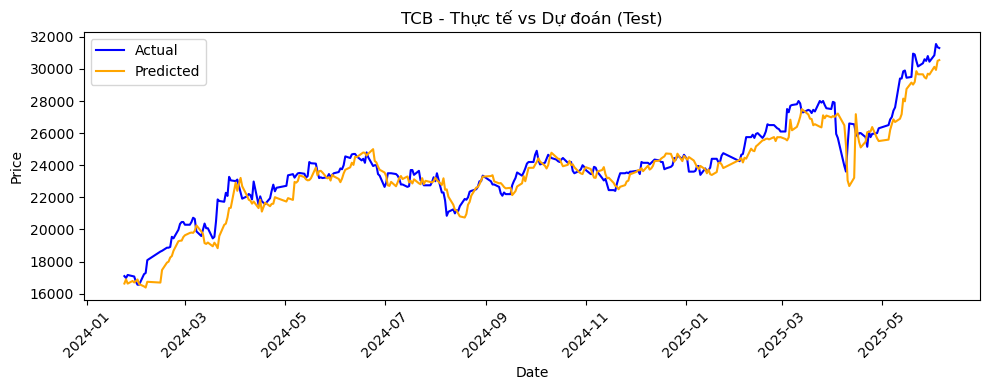

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:30:31,979] A new study created in memory with name: no-name-7a0aa602-471f-47d3-9622-97544e02404d



📅 Dự báo 30 phiên tới cho TCB:
2025-06-06: 30,280 VND
2025-06-09: 29,913 VND
2025-06-10: 29,789 VND
2025-06-11: 29,431 VND
2025-06-12: 28,899 VND
2025-06-13: 28,400 VND
2025-06-16: 28,125 VND
2025-06-17: 27,671 VND
2025-06-18: 26,983 VND
2025-06-19: 26,563 VND
2025-06-20: 26,068 VND
2025-06-23: 25,817 VND
2025-06-24: 25,435 VND
2025-06-25: 25,116 VND
2025-06-26: 24,854 VND
2025-06-27: 24,741 VND
2025-06-30: 24,866 VND
2025-07-01: 25,146 VND
2025-07-02: 25,130 VND
2025-07-03: 24,799 VND
2025-07-04: 24,899 VND
2025-07-07: 24,928 VND
2025-07-08: 25,084 VND
2025-07-09: 25,291 VND
2025-07-10: 25,068 VND
2025-07-11: 24,965 VND
2025-07-14: 24,969 VND
2025-07-15: 24,889 VND
2025-07-16: 24,733 VND
2025-07-17: 24,690 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:30:47,692] Trial 0 finished with value: 0.0017927376320585608 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0004239733665738407}. Best is trial 0 with value: 0.0017927376320585608.
[I 2025-06-07 13:30:57,801] Trial 1 finished with value: 0.0012808480532839894 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.001776311852547391}. Best is trial

  ↪ TPB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.005469131709654826}
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

🔧 BiGRU+Attention (tuned) - TPB
📊 R²: 0.8436 | RMSE: 409.16 | MAE: 305.74 | MAPE: 2.18%


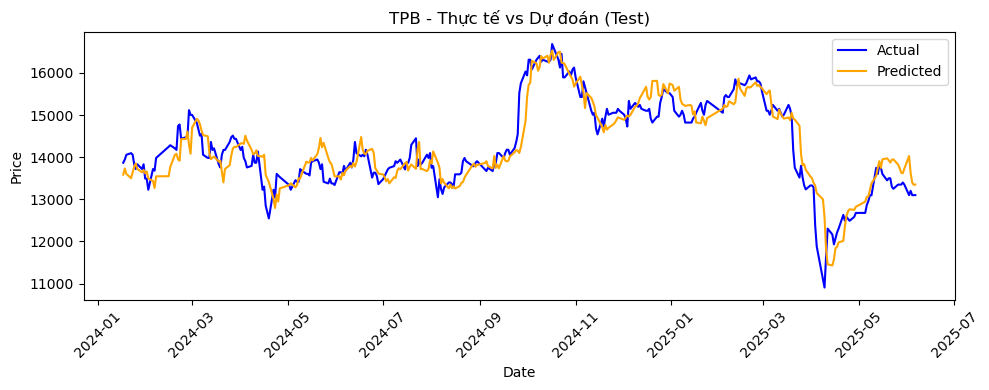

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho TPB:
2025-06-09: 13,200 VND
2025-06-10: 13,292 VND
2025-06-11: 13,400 VND
2025-06-12: 13,501 VND
2025-06-13: 13,590 VND
2025-06-16: 13,607 VND
2025-06-17: 13,800 VND
2025-06-18: 14,377 VND
2025-06-19: 14,311 VND
2025-06-20: 14,288 VND
2025-06-23: 14,260 VND
2025-06-24: 14,321 VND
2025-06-25: 14,396 VND
2025-06-26: 14,392 VND
2025-06-27: 14,417 VND
2025-06-30: 14,411 VND
2025-07-01: 14,419 VND
2025-07-02: 14,722 VND
2025-07-03: 14,762 VND
2025-07-04: 14,681 VND
2025-07-07: 14,504 VND
2025-07-08: 14,108 VND
2025-07-09: 13,860 VND
2025-07-10: 13,978 VND
2025-07-11: 13,949 VND
2025-07-14: 13,870 VND
2025-07-15: 13,789 VND
2025-07-16: 13,798 VND
2025-07-17: 13,779 VND
2025-07-18: 13,778 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:33:38,783] A new study created in memory with name: no-name-45edfab1-407b-442a-bbc8-9f6bb9bbf8ab
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:34:12,803] Trial 0 finished with value: 0.0008166726911440492 and parameters: {'units': 64,

  ↪ VCB: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.0077173039024339635}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

🔧 BiGRU+Attention (tuned) - VCB
📊 R²: 0.8102 | RMSE: 1,114.87 | MAE: 771.67 | MAPE: 1.29%


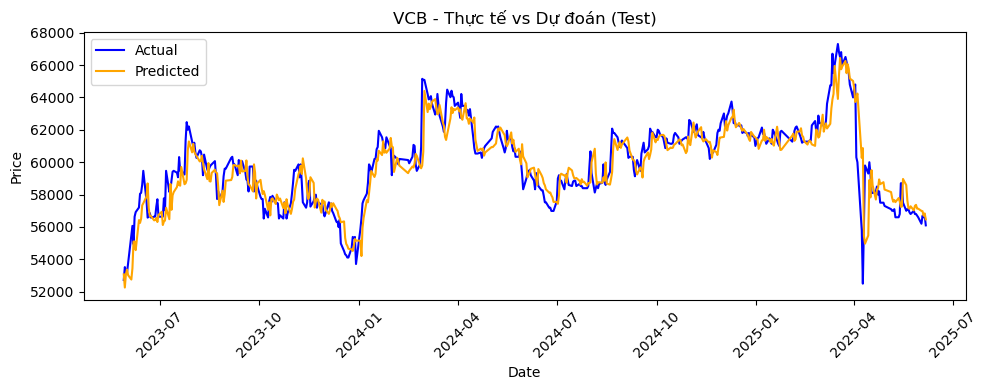

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:37:05,476] A new study created in memory with name: no-name-9fba492f-3b6c-427e-acc3-115678b2e99a



📅 Dự báo 30 phiên tới cho VCB:
2025-06-09: 56,461 VND
2025-06-10: 56,398 VND
2025-06-11: 56,830 VND
2025-06-12: 56,997 VND
2025-06-13: 57,101 VND
2025-06-16: 57,596 VND
2025-06-17: 58,077 VND
2025-06-18: 58,492 VND
2025-06-19: 58,945 VND
2025-06-20: 59,211 VND
2025-06-23: 59,572 VND
2025-06-24: 60,018 VND
2025-06-25: 60,425 VND
2025-06-26: 60,754 VND
2025-06-27: 60,878 VND
2025-06-30: 60,826 VND
2025-07-01: 60,465 VND
2025-07-02: 59,631 VND
2025-07-03: 58,043 VND
2025-07-04: 57,862 VND
2025-07-07: 57,391 VND
2025-07-08: 57,725 VND
2025-07-09: 58,602 VND
2025-07-10: 58,228 VND
2025-07-11: 57,505 VND
2025-07-14: 57,301 VND
2025-07-15: 57,235 VND
2025-07-16: 57,244 VND
2025-07-17: 57,240 VND
2025-07-18: 57,279 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:37:18,308] Trial 0 finished with value: 0.0013071802677586675 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0038719262172745815}. Best is trial 0 with value: 0.0013071802677586675.
[I 2025-06-07 13:37:32,457] Trial 1 finished with value: 0.002449470805004239 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0005190303458046247}. Best is trial

  ↪ VHM: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.0038719262172745815}
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

🔧 BiGRU+Attention (tuned) - VHM
📊 R²: 0.9396 | RMSE: 2,020.60 | MAE: 1,534.52 | MAPE: 3.41%


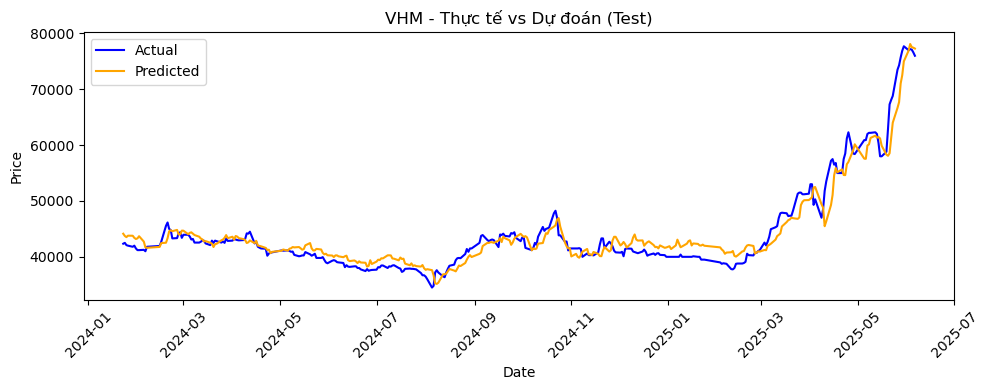

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho VHM:
2025-06-09: 73,815 VND
2025-06-10: 74,157 VND
2025-06-11: 74,968 VND
2025-06-12: 75,049 VND
2025-06-13: 74,848 VND
2025-06-16: 74,891 VND
2025-06-17: 75,252 VND
2025-06-18: 75,577 VND
2025-06-19: 76,082 VND
2025-06-20: 76,652 VND
2025-06-23: 76,620 VND
2025-06-24: 76,860 VND
2025-06-25: 76,989 VND
2025-06-26: 77,189 VND
2025-06-27: 77,544 VND
2025-06-30: 78,122 VND
2025-07-01: 78,442 VND
2025-07-02: 79,034 VND
2025-07-03: 79,774 VND
2025-07-04: 79,800 VND
2025-07-07: 80,022 VND
2025-07-08: 79,865 VND
2025-07-09: 80,696 VND
2025-07-10: 81,212 VND
2025-07-11: 81,180 VND
2025-07-14: 80,923 VND
2025-07-15: 80,647 VND
2025-07-16: 80,501 VND
2025-07-17: 80,508 VND
2025-07-18: 80,494 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:40:37,570] A new study created in memory with name: no-name-8bb2deed-6f59-4b5f-ab69-78a6dbe3d01d
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the firs

  ↪ VIB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.001171161023932969}
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

🔧 BiGRU+Attention (tuned) - VIB
📊 R²: 0.9150 | RMSE: 418.67 | MAE: 301.83 | MAPE: 1.72%


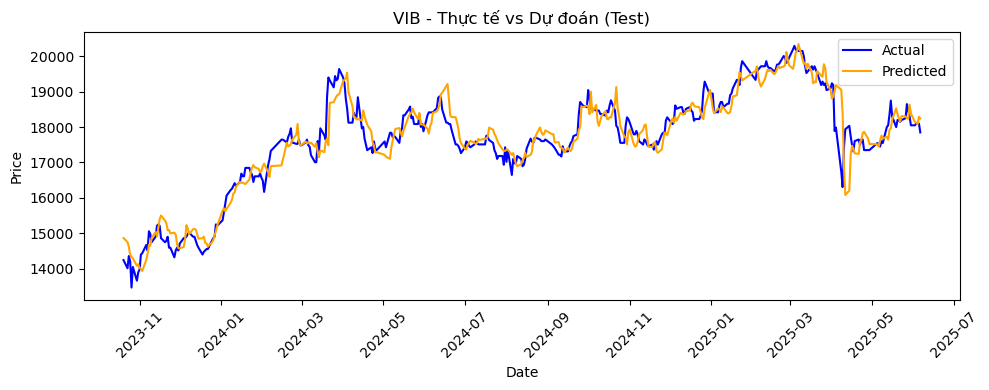

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:43:42,252] A new study created in memory with name: no-name-6b5e9b55-7fa8-4ee2-aa57-5d628cd91a89



📅 Dự báo 30 phiên tới cho VIB:
2025-06-09: 18,035 VND
2025-06-10: 18,069 VND
2025-06-11: 18,085 VND
2025-06-12: 18,159 VND
2025-06-13: 18,219 VND
2025-06-16: 18,306 VND
2025-06-17: 18,309 VND
2025-06-18: 18,411 VND
2025-06-19: 18,529 VND
2025-06-20: 18,541 VND
2025-06-23: 18,545 VND
2025-06-24: 18,568 VND
2025-06-25: 18,616 VND
2025-06-26: 18,683 VND
2025-06-27: 18,660 VND
2025-06-30: 18,608 VND
2025-07-01: 18,616 VND
2025-07-02: 18,751 VND
2025-07-03: 18,901 VND
2025-07-04: 18,947 VND
2025-07-07: 19,186 VND
2025-07-08: 19,004 VND
2025-07-09: 18,955 VND
2025-07-10: 18,914 VND
2025-07-11: 18,974 VND
2025-07-14: 19,119 VND
2025-07-15: 19,282 VND
2025-07-16: 19,310 VND
2025-07-17: 19,315 VND
2025-07-18: 19,396 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:43:53,990] Trial 0 finished with value: 0.0006685470580123365 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0019366067245014259}. Best is trial 0 with value: 0.0006685470580123365.
[I 2025-06-07 13:44:16,726] Trial 1 finished with value: 0.0006310283206403255 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0006216282134780184}. Best is trial 1 with value: 

  ↪ VIC: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.003489373640217854}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

🔧 BiGRU+Attention (tuned) - VIC
📊 R²: 0.9552 | RMSE: 2,460.57 | MAE: 1,527.59 | MAPE: 2.85%


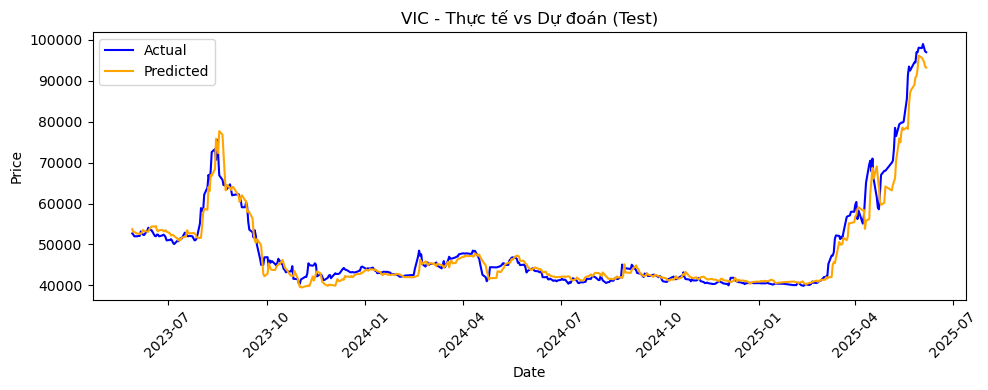

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:47:39,507] A new study created in memory with name: no-name-3ba0a5b6-a329-4767-a518-6ab548da59d0



📅 Dự báo 30 phiên tới cho VIC:
2025-06-09: 92,237 VND
2025-06-10: 87,389 VND
2025-06-11: 83,560 VND
2025-06-12: 80,471 VND
2025-06-13: 78,074 VND
2025-06-16: 75,754 VND
2025-06-17: 73,391 VND
2025-06-18: 70,775 VND
2025-06-19: 68,436 VND
2025-06-20: 66,334 VND
2025-06-23: 63,636 VND
2025-06-24: 61,537 VND
2025-06-25: 60,033 VND
2025-06-26: 58,919 VND
2025-06-27: 57,715 VND
2025-06-30: 56,680 VND
2025-07-01: 55,345 VND
2025-07-02: 53,809 VND
2025-07-03: 52,859 VND
2025-07-04: 52,303 VND
2025-07-07: 52,175 VND
2025-07-08: 52,869 VND
2025-07-09: 53,488 VND
2025-07-10: 54,295 VND
2025-07-11: 54,637 VND
2025-07-14: 54,876 VND
2025-07-15: 55,389 VND
2025-07-16: 54,967 VND
2025-07-17: 55,037 VND
2025-07-18: 55,466 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:47:54,364] Trial 0 finished with value: 0.00022196106147021055 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0017100670439253649}. Best is trial 0 with value: 0.00022196106147021055.
[I 2025-06-07 13:48:05,443] Trial 1 finished with value: 0.00038065569242462516 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0008372473085475727}. Best is trial 0 with valu

  ↪ VJC: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0014792287989078437}
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

🔧 BiGRU+Attention (tuned) - VJC
📊 R²: 0.8071 | RMSE: 2,785.66 | MAE: 2,076.52 | MAPE: 2.06%


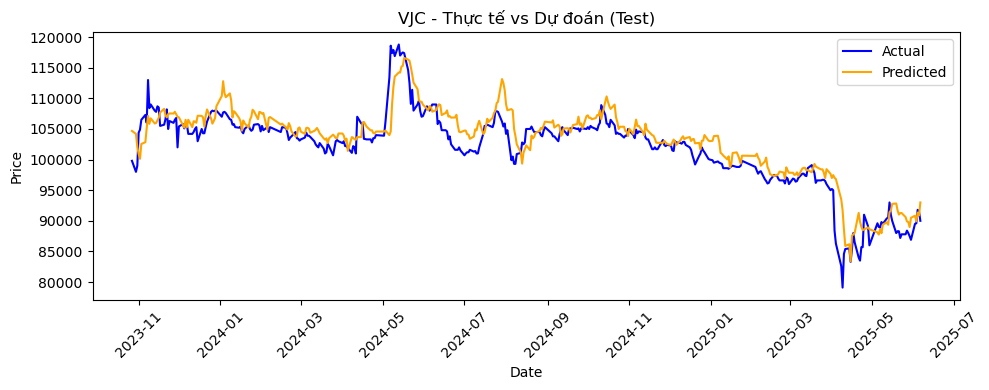

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:50:21,775] A new study created in memory with name: no-name-942f9f91-c2bb-41e4-a1ad-b9876728d160



📅 Dự báo 30 phiên tới cho VJC:
2025-06-09: 91,692 VND
2025-06-10: 92,773 VND
2025-06-11: 94,141 VND
2025-06-12: 95,393 VND
2025-06-13: 95,380 VND
2025-06-16: 95,674 VND
2025-06-17: 96,236 VND
2025-06-18: 96,810 VND
2025-06-19: 97,995 VND
2025-06-20: 98,379 VND
2025-06-23: 99,182 VND
2025-06-24: 99,392 VND
2025-06-25: 99,661 VND
2025-06-26: 100,110 VND
2025-06-27: 99,592 VND
2025-06-30: 99,554 VND
2025-07-01: 99,090 VND
2025-07-02: 98,456 VND
2025-07-03: 99,942 VND
2025-07-04: 97,376 VND
2025-07-07: 97,510 VND
2025-07-08: 98,191 VND
2025-07-09: 102,943 VND
2025-07-10: 100,474 VND
2025-07-11: 101,067 VND
2025-07-14: 102,339 VND
2025-07-15: 102,172 VND
2025-07-16: 100,600 VND
2025-07-17: 100,241 VND
2025-07-18: 101,674 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:50:54,552] Trial 0 finished with value: 0.00025089867995120585 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0023849754249721743}. Best is trial 0 with value: 0.00025089867995120585.
[I 2025-06-07 13:51:16,939] Trial 1 finished with value: 0.00029275062843225896 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0016804780675770208}. Best is t

  ↪ VNM: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.006757396808803924}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 BiGRU+Attention (tuned) - VNM
📊 R²: 0.9012 | RMSE: 1,159.11 | MAE: 833.84 | MAPE: 1.37%


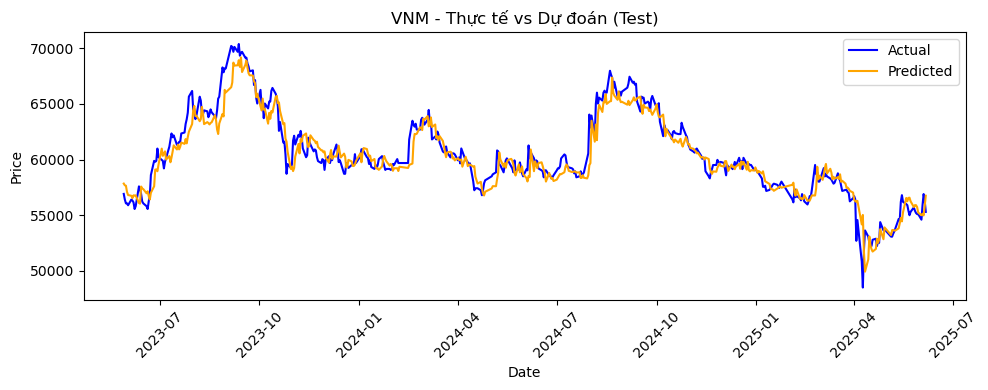

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:55:02,620] A new study created in memory with name: no-name-babdabae-23c2-42f9-b15f-3cf0a3a59e92



📅 Dự báo 30 phiên tới cho VNM:
2025-06-09: 55,217 VND
2025-06-10: 55,290 VND
2025-06-11: 55,326 VND
2025-06-12: 55,200 VND
2025-06-13: 55,009 VND
2025-06-16: 54,688 VND
2025-06-17: 54,534 VND
2025-06-18: 54,005 VND
2025-06-19: 53,203 VND
2025-06-20: 52,764 VND
2025-06-23: 52,611 VND
2025-06-24: 52,181 VND
2025-06-25: 51,497 VND
2025-06-26: 50,600 VND
2025-06-27: 49,801 VND
2025-06-30: 49,147 VND
2025-07-01: 48,639 VND
2025-07-02: 48,163 VND
2025-07-03: 47,802 VND
2025-07-04: 47,186 VND
2025-07-07: 46,947 VND
2025-07-08: 46,815 VND
2025-07-09: 46,629 VND
2025-07-10: 46,118 VND
2025-07-11: 45,966 VND
2025-07-14: 45,954 VND
2025-07-15: 45,872 VND
2025-07-16: 45,765 VND
2025-07-17: 45,706 VND
2025-07-18: 45,774 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-07 13:55:24,390] Trial 0 finished with value: 0.0006254904437810183 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.00036775999037692457}. Best is trial 0 with value: 0.0006254904437810183.
[I 2025-06-07 13:55:45,188] Trial 1 finished with value: 0.0006516433204524219 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0014338667412527309}. Best is tri

  ↪ VPB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.002657815785805987}
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

🔧 BiGRU+Attention (tuned) - VPB
📊 R²: 0.7607 | RMSE: 389.15 | MAE: 278.01 | MAPE: 1.59%


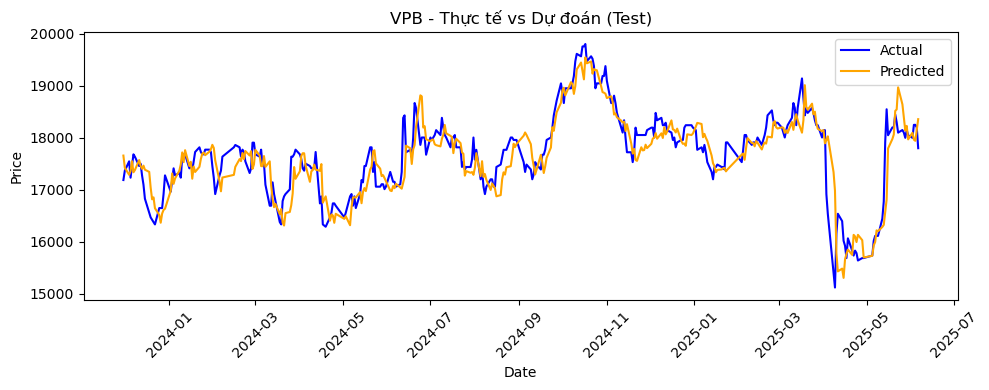

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho VPB:
2025-06-09: 16,899 VND
2025-06-10: 16,658 VND
2025-06-11: 16,945 VND
2025-06-12: 17,344 VND
2025-06-13: 17,496 VND
2025-06-16: 17,360 VND
2025-06-17: 17,316 VND
2025-06-18: 17,343 VND
2025-06-19: 17,399 VND
2025-06-20: 17,507 VND
2025-06-23: 17,541 VND
2025-06-24: 17,660 VND
2025-06-25: 17,732 VND
2025-06-26: 17,729 VND
2025-06-27: 17,653 VND
2025-06-30: 17,553 VND
2025-07-01: 17,531 VND
2025-07-02: 17,578 VND
2025-07-03: 17,586 VND
2025-07-04: 17,546 VND
2025-07-07: 17,779 VND
2025-07-08: 17,857 VND
2025-07-09: 18,424 VND
2025-07-10: 17,852 VND
2025-07-11: 17,396 VND
2025-07-14: 17,281 VND
2025-07-15: 17,398 VND
2025-07-16: 17,496 VND
2025-07-17: 17,428 VND
2025-07-18: 17,399 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-07 13:59:57,956] A new study created in memory with name: no-name-97bf4be0-ec2c-4356-8c98-a5fb81989695
C:\Users\Admin\AppData\Local\Temp\ipykernel_7648\3646421706.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\bidirecti

  ↪ VRE: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.00518556255110183}
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

🔧 BiGRU+Attention (tuned) - VRE
📊 R²: 0.9321 | RMSE: 806.11 | MAE: 616.42 | MAPE: 2.96%


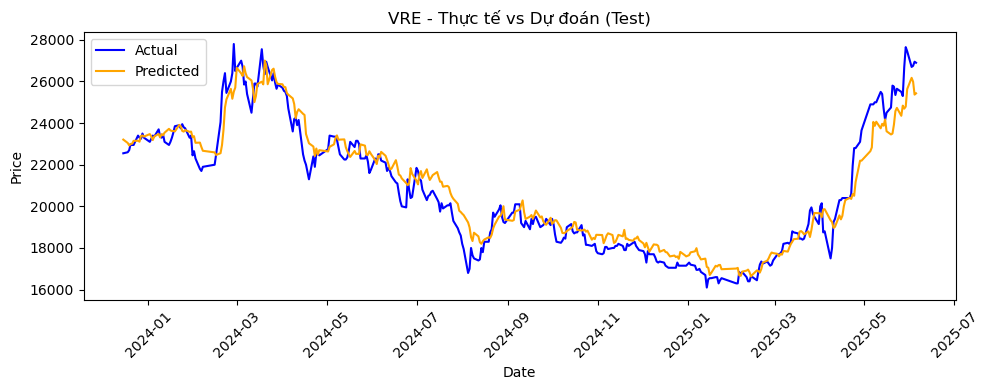

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho VRE:
2025-06-06: 25,736 VND
2025-06-09: 24,881 VND
2025-06-10: 24,017 VND
2025-06-11: 23,626 VND
2025-06-12: 23,078 VND
2025-06-13: 22,909 VND
2025-06-16: 22,837 VND
2025-06-17: 22,792 VND
2025-06-18: 22,683 VND
2025-06-19: 22,574 VND
2025-06-20: 22,324 VND
2025-06-23: 22,292 VND
2025-06-24: 22,190 VND
2025-06-25: 22,158 VND
2025-06-26: 22,121 VND
2025-06-27: 22,051 VND
2025-06-30: 21,939 VND
2025-07-01: 21,647 VND
2025-07-02: 21,522 VND
2025-07-03: 21,553 VND
2025-07-04: 21,588 VND
2025-07-07: 21,863 VND
2025-07-08: 21,906 VND
2025-07-09: 22,193 VND
2025-07-10: 21,638 VND
2025-07-11: 21,451 VND
2025-07-14: 21,289 VND
2025-07-15: 21,230 VND
2025-07-16: 21,385 VND
2025-07-17: 21,321 VND

✅ Đã lưu dự báo 30 phiên vào 'vn30_biGRU_tuned_forecast.csv'
✅ Đã lưu đánh giá mô hình vào 'vn30_biGRU_tuned_evaluation.csv'


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
# Chuẩn bị DataFrame chung để lưu kết quả forecast và evaluation
forecast_all_df = pd.DataFrame(columns=["Date", "Symbol", "Forecasted_Price"])
evaluation_df   = pd.DataFrame(columns=["Symbol", "R2", "RMSE", "MAE", "MAPE"])

# === Lấy danh sách mã VN30 ===
def get_vn30_symbols(access_token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IndexComponents"
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"indexCode": "VN30", "pageIndex": 1, "pageSize": 50}
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return [item['StockSymbol'] for item in response.json()['data'][0]['IndexComponent']]

# === Hàm train BiGRU + Optuna + plot + forecast động ===
def train_and_forecast_biGRU(symbol, data_folder="vn30_data"):
    global forecast_all_df, evaluation_df

    file_path = os.path.join(data_folder, f"{symbol}_data.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Không có dữ liệu cho {symbol}")
        return

    df = pd.read_csv(file_path)
    df["TradingDate"] = pd.to_datetime(df["TradingDate"])
    df.sort_values("TradingDate", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # === 1. Feature engineering ===
    df["PriceChange"]     = df["Close"] - df["Open"]
    df["High_Low_Spread"] = df["High"] - df["Low"]
    df["RollingMean_5"]   = df["Close"].rolling(5).mean()
    df["Momentum_10"]     = df["Close"] - df["Close"].shift(10)
    df["VolumeChange"]    = df["Volume"].pct_change()

    features = [
        "Open", "High", "Low", "Close", "Volume", "Value", "AvgSentimentScore",
        "PriceChange", "High_Low_Spread", "RollingMean_5", "Momentum_10", "VolumeChange"
    ]
    df_features = df[features].dropna().copy()
    df_dates    = df.loc[df_features.index, "TradingDate"].reset_index(drop=True)

    if len(df_features) < 200:
        print(f"⏭️ {symbol}: không đủ dữ liệu")
        return

    # === 2. Normalize ===
    standard_scaler = StandardScaler()
    minmax_scaler   = MinMaxScaler()
    scaled          = minmax_scaler.fit_transform(standard_scaler.fit_transform(df_features))
    close_index     = df_features.columns.get_loc("Close")

    def inverse_target(scaled_values):
        padded = np.zeros((scaled_values.shape[0], scaled.shape[1]))
        padded[:, close_index] = scaled_values.flatten()
        return standard_scaler.inverse_transform(minmax_scaler.inverse_transform(padded))[:, close_index]

    # === 3. Sequence Builder ===
    SEQ_LEN = 60
    HORIZON = 1
    X, y = [], []
    for i in range(SEQ_LEN, len(scaled) - HORIZON):
        X.append(scaled[i - SEQ_LEN:i])
        y.append(scaled[i + HORIZON, close_index])
    X = np.array(X)
    y = np.array(y)

    if len(X) < 200:
        print(f"⏭️ {symbol}: không đủ mẫu để train")
        return

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    test_dates      = df_dates[-len(y_test):].reset_index(drop=True)

    # === 4. Optuna tuning ===
    def objective(trial):
        units = trial.suggest_categorical("units", [32, 64])
        drop  = trial.suggest_float("dropout", 0.2, 0.4, step=0.1)
        lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)

        model = Sequential([
            Bidirectional(GRU(units), input_shape=(SEQ_LEN, X.shape[2])),
            Dropout(drop),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss="mse")

        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0)
        ]
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30, batch_size=32,
            callbacks=callbacks,
            verbose=0
        )
        return min(hist.history["val_loss"])

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, show_progress_bar=False)
    best_params = study.best_params
    print(f"  ↪ {symbol}: Chọn params từ Optuna: {best_params}")

    # === 5. Xây dựng model với best_params ===
    model = Sequential([
        Bidirectional(GRU(best_params["units"]), input_shape=(SEQ_LEN, X.shape[2])),
        Dropout(best_params["dropout"]),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["lr"])
    model.compile(optimizer=optimizer, loss="mse")

    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=0)
    ]
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50, batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    # === 6. Evaluate trên tập test ===
    y_pred_scaled = model.predict(X_test)
    y_pred        = inverse_target(y_pred_scaled)
    y_true        = inverse_target(y_test.reshape(-1, 1))

    mask_nonzero = y_true != 0
    if np.any(~mask_nonzero):
        print(f"⚠️ {symbol}: có giá thực = 0, bỏ để tính MAPE.")

    r2   = r2_score(y_true[mask_nonzero], y_pred[mask_nonzero])
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100

    print(f"\n🔧 BiGRU+Attention (tuned) - {symbol}")
    print(f"📊 R²: {r2:.4f} | RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | MAPE: {mape:.2f}%")

    evaluation_df.loc[len(evaluation_df)] = {
        "Symbol": symbol,
        "R2": round(r2, 4),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "MAPE": round(mape, 2) if not np.isinf(mape) and not np.isnan(mape) else None
    }

    # === 6.1. Vẽ biểu đồ Actual vs Predicted trên tập test ===
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_true, label="Actual", color="blue")
    plt.plot(test_dates, y_pred, label="Predicted", color="orange")
    plt.title(f"{symbol} - Thực tế vs Dự đoán (Test)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # === 7. Forecast 30 phiên với feature động ===
    last_seq   = scaled[-SEQ_LEN:].copy().reshape((1, SEQ_LEN, scaled.shape[1]))
    df_dynamic = df_features.copy().reset_index(drop=True)

    forecast_prices = []
    forecast_dates  = pd.bdate_range(
        start=df["TradingDate"].max() + timedelta(days=1),
        periods=30
    )

    for dt in forecast_dates:
        # 7.1. Dự đoán scaled close mới
        pred_scaled = model.predict(last_seq)[0][0]
        pred_real   = float(inverse_target(np.array([[pred_scaled]]))[0])
        forecast_prices.append(pred_real)

        # 7.2. Tính lại mọi feature liên quan đến 'pred_real'
        prev_row = df_dynamic.iloc[-1]

        open_new  = prev_row["Close"]
        # Volume biến động ±2%
        vol_prev   = prev_row["Volume"]
        noise      = np.random.uniform(0.98, 1.02)
        volume_new = vol_prev * noise

        value_new     = prev_row["Value"]
        sentiment_new = prev_row["AvgSentimentScore"]

        high_new  = max(open_new, pred_real)
        low_new   = min(open_new, pred_real)
        close_new = pred_real

        price_change_new    = close_new - open_new
        high_low_spread_new = high_new - low_new

        last_4 = df_dynamic["Close"].iloc[-4:].tolist()
        rolling_mean_5_new = (sum(last_4) + close_new) / 5.0

        if len(df_dynamic) >= 10:
            momentum_10_new = close_new - df_dynamic["Close"].iloc[-10]
        else:
            momentum_10_new = close_new - df_dynamic["Close"].iloc[0]

        volume_change_new = 0.0
        if vol_prev != 0:
            volume_change_new = (volume_new - vol_prev) / vol_prev

        # 7.3. Append vào df_dynamic
        new_row = pd.DataFrame([{
            "Open": open_new,
            "High": high_new,
            "Low": low_new,
            "Close": close_new,
            "Volume": volume_new,
            "Value": value_new,
            "AvgSentimentScore": sentiment_new,
            "PriceChange": price_change_new,
            "High_Low_Spread": high_low_spread_new,
            "RollingMean_5": rolling_mean_5_new,
            "Momentum_10": momentum_10_new,
            "VolumeChange": volume_change_new
        }])
        df_dynamic = pd.concat([df_dynamic, new_row], ignore_index=True)

        # 7.4. Chuẩn hóa và update last_seq
        new_features_array = np.array([
            open_new, high_new, low_new, close_new,
            volume_new, value_new, sentiment_new,
            price_change_new, high_low_spread_new,
            rolling_mean_5_new, momentum_10_new, volume_change_new
        ]).reshape(1, -1)

        std_feat   = standard_scaler.transform(new_features_array)
        new_scaled = minmax_scaler.transform(std_feat)

        last_seq = np.concatenate([last_seq[:, 1:, :], new_scaled.reshape(1, 1, -1)], axis=1)

    # 7.5. In log forecast
    print(f"\n📅 Dự báo 30 phiên tới cho {symbol}:")
    for date, price in zip(forecast_dates, forecast_prices):
        print(f"{date.strftime('%Y-%m-%d')}: {round(price):,} VND")

    forecast_df = pd.DataFrame({
        "Date": forecast_dates,
        "Symbol": symbol,
        "Forecasted_Price": forecast_prices
    })
    forecast_all_df = pd.concat([forecast_all_df, forecast_df], ignore_index=True)


# === Chạy cho tất cả mã VN30 ===
symbols = get_vn30_symbols(access_token)
for symbol in symbols:
    train_and_forecast_biGRU(symbol)

# === Lưu kết quả ===
forecast_all_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_biGRU_tuned_forecast.csv", index=False)
evaluation_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_biGRU_tuned_evaluation.csv", index=False)

print("\n✅ Đã lưu dự báo 30 phiên vào 'vn30_biGRU_tuned_forecast.csv'")
print("✅ Đã lưu đánh giá mô hình vào 'vn30_biGRU_tuned_evaluation.csv'")


## LSTM

[I 2025-06-06 21:56:30,567] A new study created in memory with name: no-name-9e63c8fc-dbcf-4967-a517-609eb2af842b
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 21:56:41,385] Trial 0 finished with value: 0.0006625399109907448 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.005317393450236808}. Best is trial 0 with value: 0.0006625399109907448.
[I 2025-06-06 21:56:49,886] Trial 1 finished with value: 0.0009036218980327249 

  ↪ ACB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.005317393450236808}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔧 LSTM Basic (tuned) - ACB
📊 R²: 0.9668 | RMSE: 428.91 | MAE: 312.96 | MAPE: 1.70%


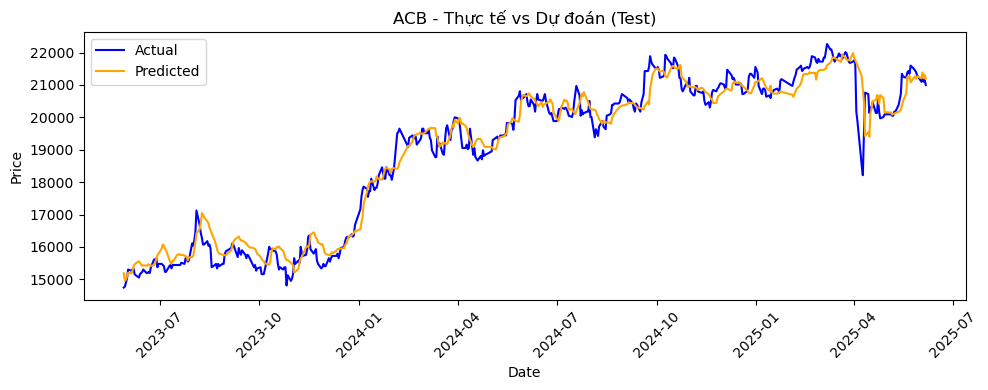

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho ACB:
2025-06-09: 20,508 VND
2025-06-10: 20,886 VND
2025-06-11: 20,784 VND
2025-06-12: 20,853 VND
2025-06-13: 20,833 VND
2025-06-16: 20,828 VND
2025-06-17: 20,814 VND
2025-06-18: 20,786 VND
2025-06-19: 20,762 VND
2025-06-20: 20,735 VND
2025-06-23: 20,716 VND
2025-06-24: 20,719 VND
2025-06-25: 20,688 VND
2025-06-26: 20,662 VND
2025-06-27: 20,634 VND
2025-06-30: 20,609 VND
2025-07-01: 20,586 VND
2025-07-02: 20,564 VND
2025-07-03: 20,543 VND
2025-07-04: 20,524 VND
2025-07-07: 20,505 VND
2025-07-08: 20,486 VND
2025-07-09: 20,467 VND
2025-07-10: 20,450 VND
2025-07-11: 20,433 VND
2025-07-14: 20,417 VND
2025-07-15: 20,402 VND
2025-07-16: 20,387 VND
2025-07-17: 20,372 VND
2025-07-18: 20,357 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:269: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast_all_df = pd.concat([forecast_all_df, forecast_df], ignore_index=True)
[I 2025-06-06 21:58:20,469] A new study created in memo

  ↪ BCM: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.0030680464720135095}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔧 LSTM Basic (tuned) - BCM
📊 R²: 0.7990 | RMSE: 2,705.40 | MAE: 1,780.76 | MAPE: 2.82%


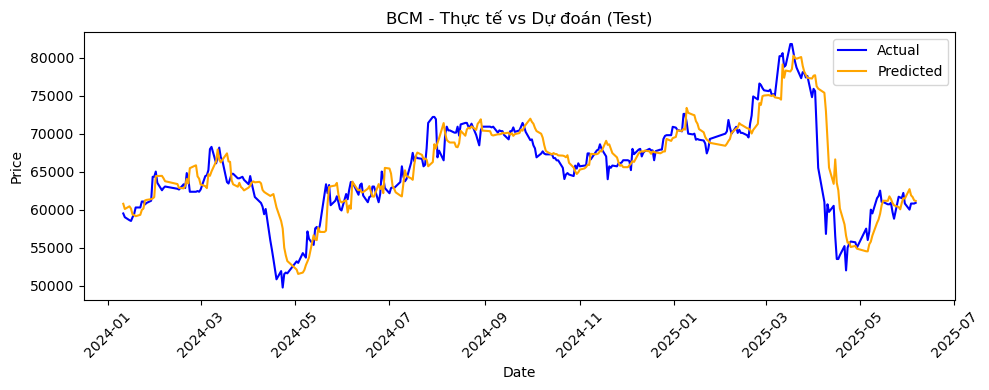

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:00:08,279] A new study created in memory with name: no-name-43275928-93ba-42ed-a47b-37027f526517



📅 Dự báo 30 phiên tới cho BCM:
2025-06-09: 61,651 VND
2025-06-10: 61,926 VND
2025-06-11: 62,142 VND
2025-06-12: 62,317 VND
2025-06-13: 62,458 VND
2025-06-16: 62,625 VND
2025-06-17: 62,793 VND
2025-06-18: 62,919 VND
2025-06-19: 63,040 VND
2025-06-20: 63,167 VND
2025-06-23: 63,294 VND
2025-06-24: 63,391 VND
2025-06-25: 63,487 VND
2025-06-26: 63,598 VND
2025-06-27: 63,690 VND
2025-06-30: 63,783 VND
2025-07-01: 63,884 VND
2025-07-02: 63,991 VND
2025-07-03: 64,084 VND
2025-07-04: 64,173 VND
2025-07-07: 64,260 VND
2025-07-08: 64,343 VND
2025-07-09: 64,440 VND
2025-07-10: 64,546 VND
2025-07-11: 64,657 VND
2025-07-14: 64,751 VND
2025-07-15: 64,843 VND
2025-07-16: 64,942 VND
2025-07-17: 65,034 VND
2025-07-18: 65,131 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:00:14,826] Trial 0 finished with value: 0.000925008615013212 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.003345689810033419}. Best is trial 0 with value: 0.000925008615013212.
[I 2025-06-06 22:00:28,600] Trial 1 finished with value: 0.0007347469218075275 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.002992320010214983}. Best is trial 1 with valu

  ↪ BID: Chọn params từ Optuna: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.007871751751295696}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔧 LSTM Basic (tuned) - BID
📊 R²: 0.9357 | RMSE: 925.29 | MAE: 677.73 | MAPE: 1.80%


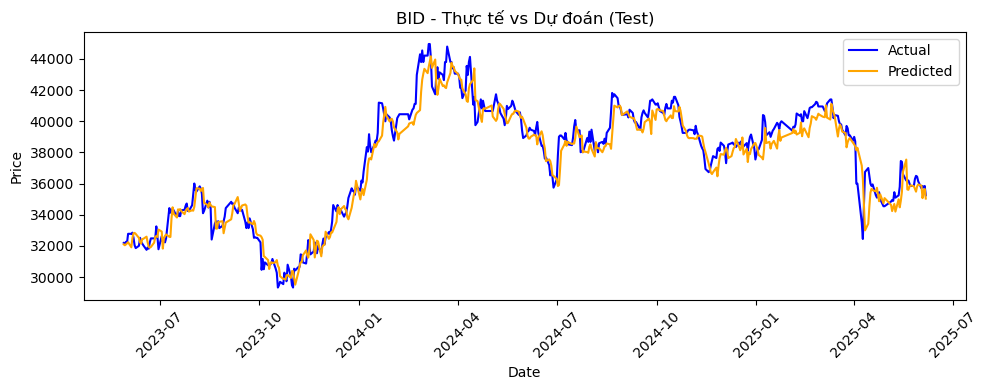

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

📅 Dự báo 30 phiên tới cho BID:
2025-06-09: 34,852 VND
2025-06-10: 35,007 VND
2025-06-11: 34,865 VND
2025-06-12: 34,677 VND
2025-06-13: 34,420 VND
2025-06-16: 34,172 VND
2025-06-17: 33,973 VND
2025-06-18: 33,780 VND
2025-06-19: 33,583 VND
2025-06-20: 33,375 VND
2025-06-23: 33,196 VND
2025-06-24: 33,052 VND
2025-06-25: 32,890 VND
2025-06-26: 32,716 VND
2025-06-27: 32,543 VND
2025-06-30: 32,382 VND
2025-07-01: 32,235 VND
2025-07-02: 32,094 VND
2025-07-03: 31,956 VND
2025-07-04: 31,823 VND
2025-07-07: 31,692 VND
2025-07-08: 31,564 VND
2025-07-09: 31,435 VND
2025-07-10: 31,310 VND
2025-07-11: 31,189 VND
2025-07-14: 31,075 VND
2025-07-15: 30,964 VND
2025-07-16: 30,855 VND
2025-07-17: 30,751 VND
2025-07-18: 30,650 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:02:25,228] A new study created in memory with name: no-name-51b29594-13b6-465a-8e4f-ffd770501036
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:2

  ↪ BVH: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.008607289533456802}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🔧 LSTM Basic (tuned) - BVH
📊 R²: 0.9397 | RMSE: 1,172.65 | MAE: 760.96 | MAPE: 1.70%


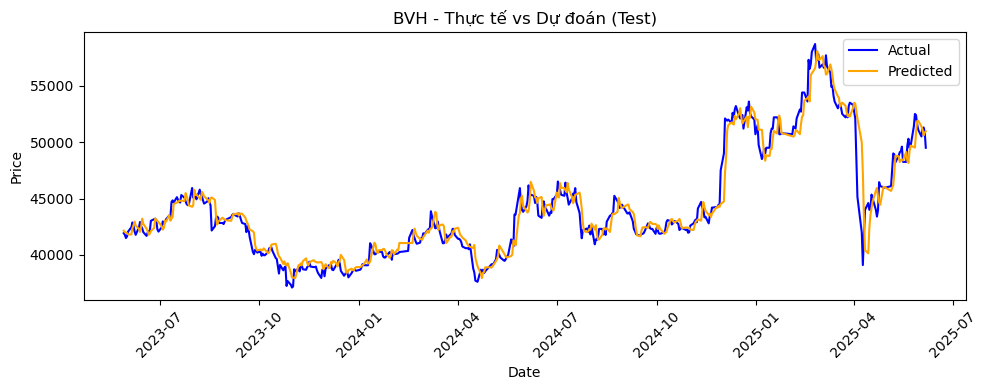

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:06:20,457] A new study created in memory with name: no-name-bfa1ad96-96ad-4385-b69c-3a588c1a58d7



📅 Dự báo 30 phiên tới cho BVH:
2025-06-09: 50,197 VND
2025-06-10: 49,904 VND
2025-06-11: 49,677 VND
2025-06-12: 49,653 VND
2025-06-13: 49,768 VND
2025-06-16: 49,900 VND
2025-06-17: 50,002 VND
2025-06-18: 49,938 VND
2025-06-19: 49,805 VND
2025-06-20: 49,678 VND
2025-06-23: 49,660 VND
2025-06-24: 49,535 VND
2025-06-25: 49,409 VND
2025-06-26: 49,289 VND
2025-06-27: 49,162 VND
2025-06-30: 49,019 VND
2025-07-01: 48,865 VND
2025-07-02: 48,708 VND
2025-07-03: 48,564 VND
2025-07-04: 48,439 VND
2025-07-07: 48,328 VND
2025-07-08: 48,214 VND
2025-07-09: 48,108 VND
2025-07-10: 48,005 VND
2025-07-11: 47,905 VND
2025-07-14: 47,806 VND
2025-07-15: 47,710 VND
2025-07-16: 47,617 VND
2025-07-17: 47,528 VND
2025-07-18: 47,441 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:06:29,496] Trial 0 finished with value: 0.0012763832928612828 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.008025669639936794}. Best is trial 0 with value: 0.0012763832928612828.
[I 2025-06-06 22:06:34,908] Trial 1 finished with value: 0.0012233061715960503 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0009523089078115452}. Best i

  ↪ CTG: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.00061924163558315}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔧 LSTM Basic (tuned) - CTG
📊 R²: 0.9035 | RMSE: 1,495.77 | MAE: 1,174.95 | MAPE: 3.37%


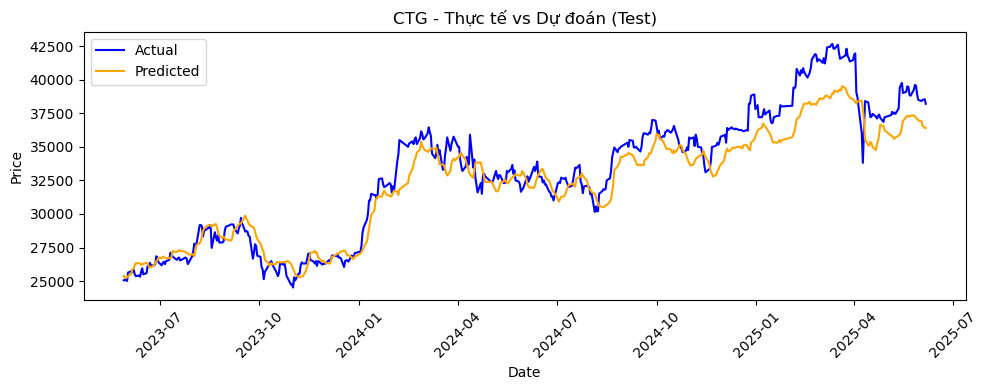

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

📅 Dự báo 30 phiên tới cho CTG:
2025-06-09: 35,950 VND
2025-06-10: 35,870 VND
2025-06-11: 35,687 VND
2025-06-12: 35,330 VND
2025-06-13: 35,041 VND
2025-06-16: 34,780 VND
2025-06-17: 34,495 VND
2025-06-18: 34,163 VND
2025-06-19: 33,813 VND
2025-06-20: 33,445 VND
2025-06-23: 33,123 VND
2025-06-24: 33,133 VND
2025-06-25: 33,065 VND
2025-06-26: 32,953 VND
2025-06-27: 32,851 VND
2025-06-30: 32,750 VND
2025-07-01: 32,650 VND
2025-07-02: 32,557 VND
2025-07-03: 32,482 VND
2025-07-04: 32,426 VND
2025-07-07: 32,392 VND
2025-07-08: 32,370 VND
2025-07-09: 32,311 VND
2025-07-10: 32,239 VND
2025-07-11: 32,168 VND
2025-07-14: 32,097 VND
2025-07-15: 32,028 VND
2025-07-16: 31,960 VND
2025-07-17: 31,894 VND
2025-07-18: 31,827 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:08:30,924] A new study created in memory with name: no-name-e68fa8ad-cafb-46b7-8b4a-44f9e0a58bda
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:2

  ↪ FPT: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00128270317425797}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔧 LSTM Basic (tuned) - FPT
📊 R²: 0.9231 | RMSE: 7,655.80 | MAE: 5,863.72 | MAPE: 4.80%


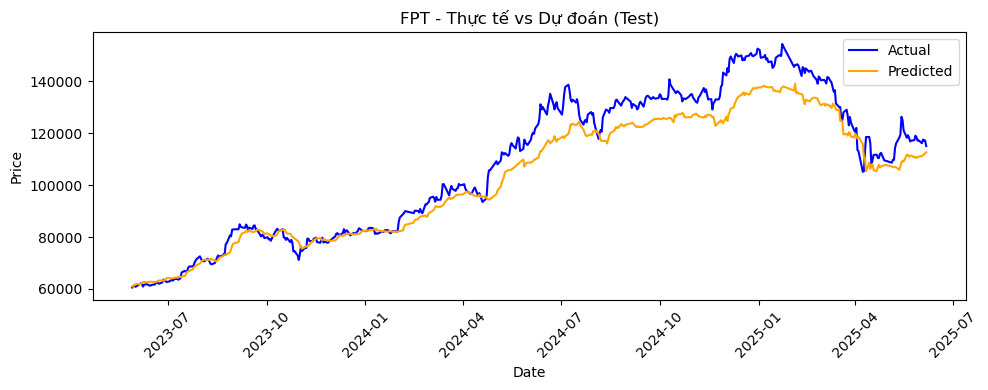

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:10:06,029] A new study created in memory with name: no-name-37e6aa2f-8b90-4fc1-a61a-30a29742eec9



📅 Dự báo 30 phiên tới cho FPT:
2025-06-09: 111,595 VND
2025-06-10: 110,000 VND
2025-06-11: 109,131 VND
2025-06-12: 108,331 VND
2025-06-13: 107,592 VND
2025-06-16: 106,816 VND
2025-06-17: 106,110 VND
2025-06-18: 105,326 VND
2025-06-19: 104,584 VND
2025-06-20: 103,889 VND
2025-06-23: 103,374 VND
2025-06-24: 103,055 VND
2025-06-25: 102,729 VND
2025-06-26: 102,323 VND
2025-06-27: 101,877 VND
2025-06-30: 101,414 VND
2025-07-01: 100,946 VND
2025-07-02: 100,441 VND
2025-07-03: 99,927 VND
2025-07-04: 99,427 VND
2025-07-07: 98,923 VND
2025-07-08: 98,422 VND
2025-07-09: 97,895 VND
2025-07-10: 97,375 VND
2025-07-11: 96,862 VND
2025-07-14: 96,365 VND
2025-07-15: 95,885 VND
2025-07-16: 95,430 VND
2025-07-17: 95,003 VND
2025-07-18: 94,579 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:10:16,294] Trial 0 finished with value: 0.0004963254905305803 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0022171898197307126}. Best is trial 0 with value: 0.0004963254905305803.
[I 2025-06-06 22:10:37,051] Trial 1 finished with value: 0.00041955962660722435 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.000908758383632023}. Best is trial 1 with value: 0.0004195

  ↪ GAS: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.000908758383632023}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔧 LSTM Basic (tuned) - GAS
📊 R²: 0.8724 | RMSE: 1,608.20 | MAE: 1,040.30 | MAPE: 1.51%


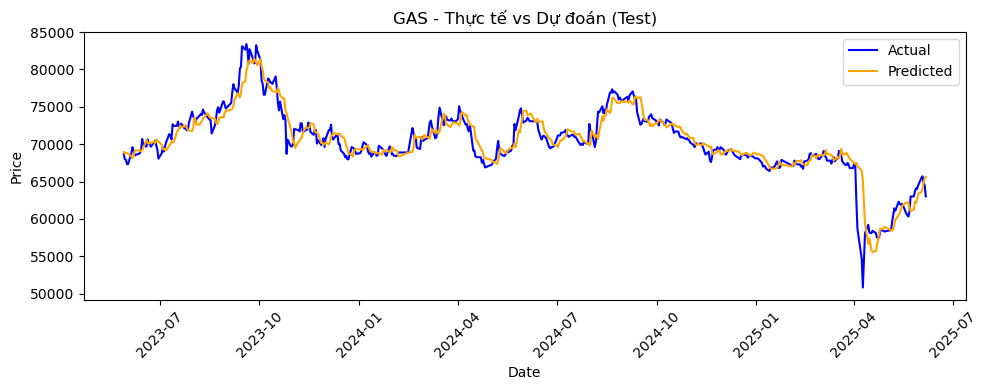

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

📅 Dự báo 30 phiên tới cho GAS:
2025-06-09: 65,548 VND
2025-06-10: 66,116 VND
2025-06-11: 66,027 VND
2025-06-12: 65,871 VND
2025-06-13: 65,802 VND
2025-06-16: 65,771 VND
2025-06-17: 65,702 VND
2025-06-18: 65,660 VND
2025-06-19: 65,754 VND
2025-06-20: 65,914 VND
2025-06-23: 66,219 VND
2025-06-24: 66,278 VND
2025-06-25: 66,262 VND
2025-06-26: 66,289 VND
2025-06-27: 66,373 VND
2025-06-30: 66,480 VND
2025-07-01: 66,605 VND
2025-07-02: 66,741 VND
2025-07-03: 66,886 VND
2025-07-04: 67,029 VND
2025-07-07: 67,152 VND
2025-07-08: 67,252 VND
2025-07-09: 67,359 VND
2025-07-10: 67,479 VND
2025-07-11: 67,599 VND
2025-07-14: 67,724 VND
2025-07-15: 67,845 VND
2025-07-16: 67,954 VND
2025-07-17: 68,056 VND
2025-07-18: 68,151 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:12:48,898] A new study created in memory with name: no-name-41c61f13-56df-478e-95cc-43592fcc59de
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer i

  ↪ GVR: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.006061203468355603}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

🔧 LSTM Basic (tuned) - GVR
📊 R²: 0.8894 | RMSE: 1,246.40 | MAE: 909.75 | MAPE: 3.01%


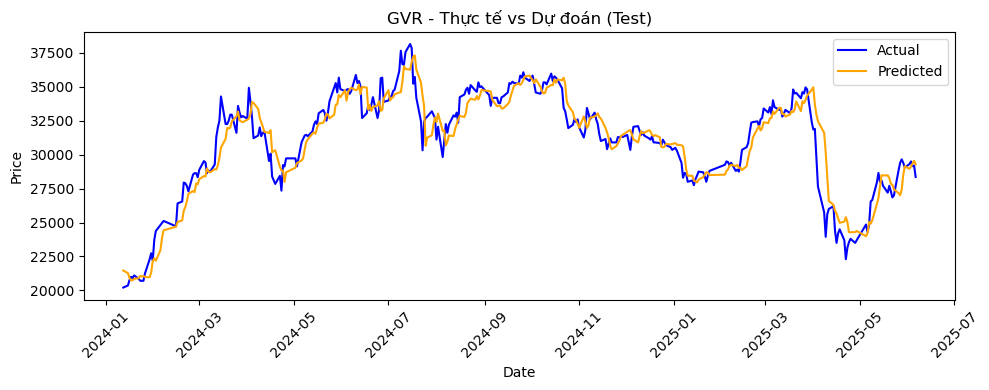

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:15:38,708] A new study created in memory with name: no-name-542c8efd-f701-4148-862f-83239e6fb145



📅 Dự báo 30 phiên tới cho GVR:
2025-06-09: 28,716 VND
2025-06-10: 28,886 VND
2025-06-11: 29,048 VND
2025-06-12: 29,258 VND
2025-06-13: 29,504 VND
2025-06-16: 29,770 VND
2025-06-17: 29,991 VND
2025-06-18: 30,208 VND
2025-06-19: 30,446 VND
2025-06-20: 30,651 VND
2025-06-23: 30,908 VND
2025-06-24: 31,070 VND
2025-06-25: 31,250 VND
2025-06-26: 31,406 VND
2025-06-27: 31,562 VND
2025-06-30: 31,709 VND
2025-07-01: 31,855 VND
2025-07-02: 32,001 VND
2025-07-03: 32,146 VND
2025-07-04: 32,289 VND
2025-07-07: 32,434 VND
2025-07-08: 32,575 VND
2025-07-09: 32,722 VND
2025-07-10: 32,865 VND
2025-07-11: 33,010 VND
2025-07-14: 33,154 VND
2025-07-15: 33,297 VND
2025-07-16: 33,438 VND
2025-07-17: 33,578 VND
2025-07-18: 33,716 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:15:45,086] Trial 0 finished with value: 0.0032153127249330282 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0005349946934095554}. Best is trial 0 with value: 0.0032153127249330282.
[I 2025-06-06 22:15:57,706] Trial 1 finished with value: 0.0020318469032645226 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.00023896250016820306}. Best is trial 1 with value: 0.002031

  ↪ HDB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.008001897517809019}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔧 LSTM Basic (tuned) - HDB
📊 R²: 0.6709 | RMSE: 1,215.24 | MAE: 1,020.43 | MAPE: 4.72%


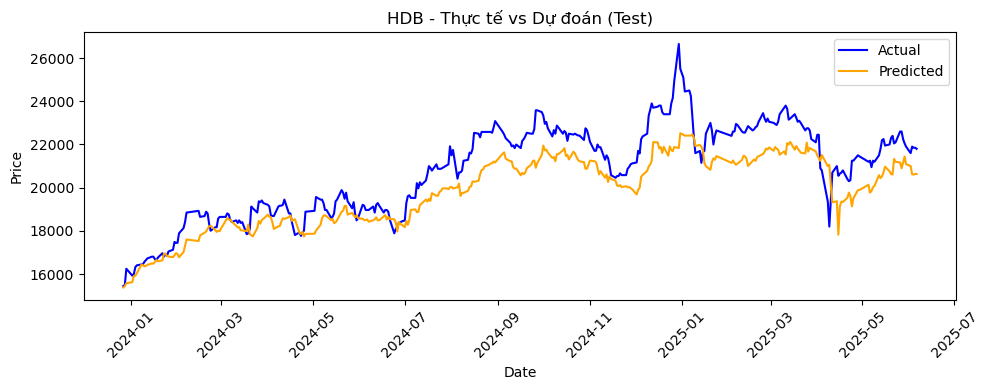

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:17:34,749] A new study created in memory with name: no-name-27410b96-4562-460e-b8ef-f3b6b7b0c686



📅 Dự báo 30 phiên tới cho HDB:
2025-06-09: 20,168 VND
2025-06-10: 19,347 VND
2025-06-11: 19,251 VND
2025-06-12: 19,483 VND
2025-06-13: 19,515 VND
2025-06-16: 19,531 VND
2025-06-17: 19,481 VND
2025-06-18: 19,398 VND
2025-06-19: 19,302 VND
2025-06-20: 19,221 VND
2025-06-23: 19,162 VND
2025-06-24: 19,096 VND
2025-06-25: 19,033 VND
2025-06-26: 18,968 VND
2025-06-27: 18,895 VND
2025-06-30: 18,814 VND
2025-07-01: 18,738 VND
2025-07-02: 18,674 VND
2025-07-03: 18,624 VND
2025-07-04: 18,584 VND
2025-07-07: 18,552 VND
2025-07-08: 18,524 VND
2025-07-09: 18,495 VND
2025-07-10: 18,463 VND
2025-07-11: 18,432 VND
2025-07-14: 18,403 VND
2025-07-15: 18,377 VND
2025-07-16: 18,353 VND
2025-07-17: 18,328 VND
2025-07-18: 18,304 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:17:43,495] Trial 0 finished with value: 0.0006290495512075722 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.000462742080089299}. Best is trial 0 with value: 0.0006290495512075722.
[I 2025-06-06 22:17:59,879] Trial 1 finished with value: 0.00040661540697328746 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0026795451338642706}. Best is trial 1 with 

  ↪ HPG: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.00038144516697343194}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔧 LSTM Basic (tuned) - HPG
📊 R²: 0.8360 | RMSE: 782.83 | MAE: 587.24 | MAPE: 2.32%


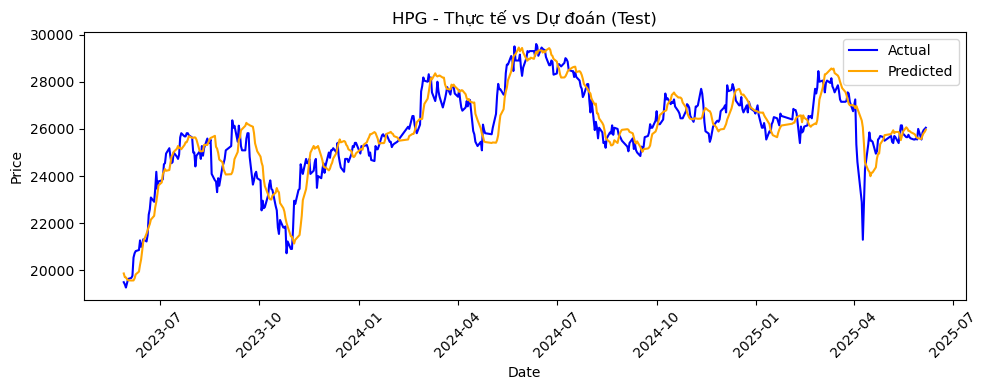

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:20:57,786] A new study created in memory with name: no-name-5d4af8b2-e6a1-4c48-af0a-a77a56901f83



📅 Dự báo 30 phiên tới cho HPG:
2025-06-09: 26,132 VND
2025-06-10: 26,129 VND
2025-06-11: 26,232 VND
2025-06-12: 26,346 VND
2025-06-13: 26,459 VND
2025-06-16: 26,552 VND
2025-06-17: 26,691 VND
2025-06-18: 26,818 VND
2025-06-19: 26,939 VND
2025-06-20: 27,068 VND
2025-06-23: 27,201 VND
2025-06-24: 27,331 VND
2025-06-25: 27,467 VND
2025-06-26: 27,616 VND
2025-06-27: 27,768 VND
2025-06-30: 27,921 VND
2025-07-01: 28,072 VND
2025-07-02: 28,228 VND
2025-07-03: 28,387 VND
2025-07-04: 28,545 VND
2025-07-07: 28,705 VND
2025-07-08: 28,873 VND
2025-07-09: 29,038 VND
2025-07-10: 29,203 VND
2025-07-11: 29,360 VND
2025-07-14: 29,509 VND
2025-07-15: 29,657 VND
2025-07-16: 29,812 VND
2025-07-17: 29,955 VND
2025-07-18: 30,091 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:21:07,388] Trial 0 finished with value: 0.002475079847499728 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0014633127937881954}. Best is trial 0 with value: 0.002475079847499728.
[I 2025-06-06 22:21:22,515] Trial 1 finished with value: 0.01102893054485321 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.00012489438412679633}. Best is trial 0 with value: 0.0024750798

  ↪ LPB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.008069725798958073}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

🔧 LSTM Basic (tuned) - LPB
📊 R²: 0.9022 | RMSE: 2,173.91 | MAE: 1,701.98 | MAPE: 6.34%


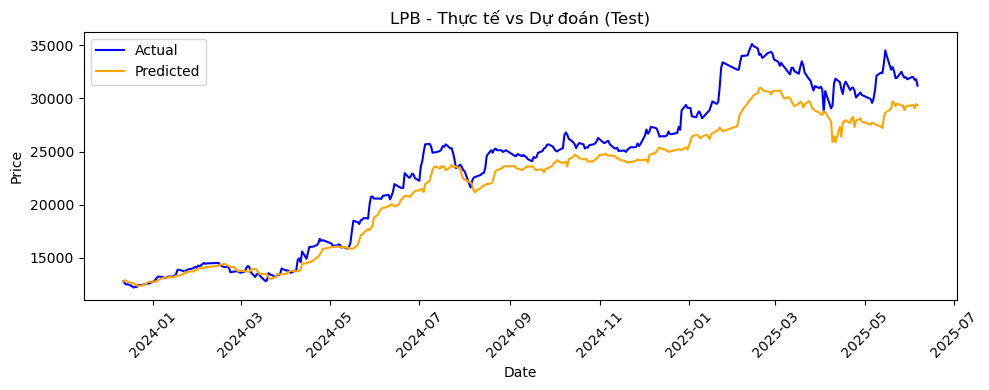

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:23:30,429] A new study created in memory with name: no-name-df2f48b5-d14b-4d76-9e7c-8cd21a11f7fd



📅 Dự báo 30 phiên tới cho LPB:
2025-06-09: 27,380 VND
2025-06-10: 26,721 VND
2025-06-11: 26,158 VND
2025-06-12: 25,677 VND
2025-06-13: 25,242 VND
2025-06-16: 24,826 VND
2025-06-17: 24,434 VND
2025-06-18: 24,071 VND
2025-06-19: 23,742 VND
2025-06-20: 23,435 VND
2025-06-23: 23,163 VND
2025-06-24: 22,984 VND
2025-06-25: 22,786 VND
2025-06-26: 22,550 VND
2025-06-27: 22,294 VND
2025-06-30: 22,032 VND
2025-07-01: 21,774 VND
2025-07-02: 21,525 VND
2025-07-03: 21,284 VND
2025-07-04: 21,052 VND
2025-07-07: 20,833 VND
2025-07-08: 20,624 VND
2025-07-09: 20,425 VND
2025-07-10: 20,236 VND
2025-07-11: 20,058 VND
2025-07-14: 19,891 VND
2025-07-15: 19,734 VND
2025-07-16: 19,583 VND
2025-07-17: 19,438 VND
2025-07-18: 19,301 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:23:57,277] Trial 0 finished with value: 0.0005372625309973955 and parameters: {'units': 64, 'dropout': 0.2, 'lr': 0.0014581927758741922}. Best is trial 0 with value: 0.0005372625309973955.
[I 2025-06-06 22:24:14,043] Trial 1 finished with value: 0.0006390855996869504 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0026414311138395407}. Best is trial 0 with value: 0.0005372

  ↪ MBB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.004302223283314795}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔧 LSTM Basic (tuned) - MBB
📊 R²: 0.9722 | RMSE: 511.91 | MAE: 367.91 | MAPE: 1.84%


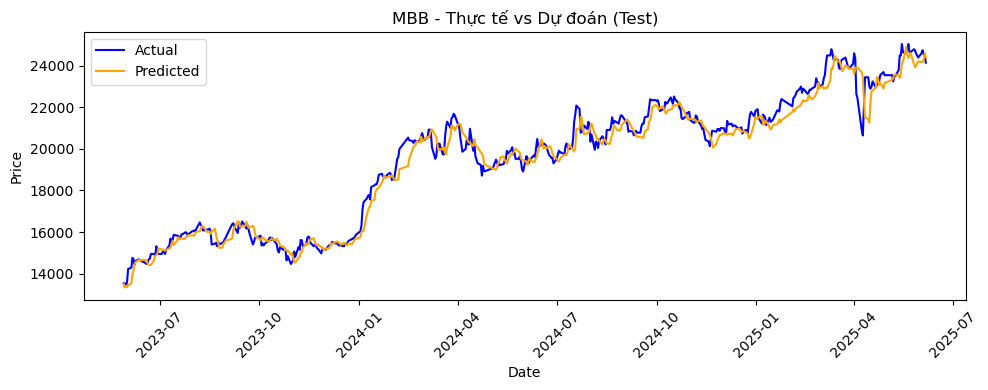

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:26:08,886] A new study created in memory with name: no-name-28190a6f-c856-4254-94a0-8faad90315f8



📅 Dự báo 30 phiên tới cho MBB:
2025-06-09: 24,063 VND
2025-06-10: 24,129 VND
2025-06-11: 24,185 VND
2025-06-12: 24,240 VND
2025-06-13: 24,271 VND
2025-06-16: 24,291 VND
2025-06-17: 24,272 VND
2025-06-18: 24,243 VND
2025-06-19: 24,245 VND
2025-06-20: 24,243 VND
2025-06-23: 24,276 VND
2025-06-24: 24,272 VND
2025-06-25: 24,251 VND
2025-06-26: 24,216 VND
2025-06-27: 24,178 VND
2025-06-30: 24,145 VND
2025-07-01: 24,120 VND
2025-07-02: 24,108 VND
2025-07-03: 24,105 VND
2025-07-04: 24,107 VND
2025-07-07: 24,107 VND
2025-07-08: 24,104 VND
2025-07-09: 24,101 VND
2025-07-10: 24,101 VND
2025-07-11: 24,103 VND
2025-07-14: 24,103 VND
2025-07-15: 24,104 VND
2025-07-16: 24,103 VND
2025-07-17: 24,100 VND
2025-07-18: 24,095 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:26:17,335] Trial 0 finished with value: 0.0006234007305465639 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0013354489713926364}. Best is trial 0 with value: 0.0006234007305465639.
[I 2025-06-06 22:26:41,016] Trial 1 finished with value: 0.0003786795714404434 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0069997590461292015}. Best is trial 1 with 

  ↪ MSN: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0069997590461292015}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔧 LSTM Basic (tuned) - MSN
📊 R²: 0.8795 | RMSE: 2,250.93 | MAE: 1,600.79 | MAPE: 2.29%


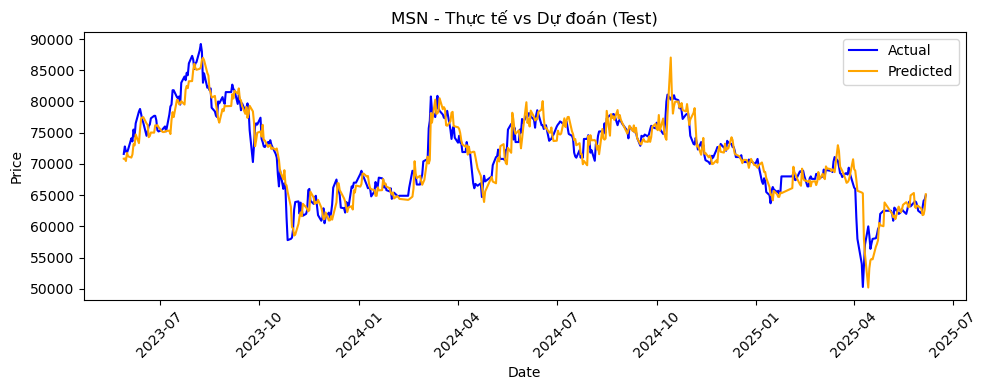

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:29:10,925] A new study created in memory with name: no-name-6c1fc2d6-2595-4dd3-a717-f6696e986152



📅 Dự báo 30 phiên tới cho MSN:
2025-06-09: 62,921 VND
2025-06-10: 61,371 VND
2025-06-11: 60,936 VND
2025-06-12: 61,163 VND
2025-06-13: 61,645 VND
2025-06-16: 62,140 VND
2025-06-17: 62,538 VND
2025-06-18: 62,814 VND
2025-06-19: 62,994 VND
2025-06-20: 63,134 VND
2025-06-23: 63,263 VND
2025-06-24: 63,406 VND
2025-06-25: 63,575 VND
2025-06-26: 63,738 VND
2025-06-27: 63,862 VND
2025-06-30: 63,938 VND
2025-07-01: 63,977 VND
2025-07-02: 63,996 VND
2025-07-03: 64,013 VND
2025-07-04: 64,033 VND
2025-07-07: 64,062 VND
2025-07-08: 64,094 VND
2025-07-09: 64,124 VND
2025-07-10: 64,148 VND
2025-07-11: 64,164 VND
2025-07-14: 64,172 VND
2025-07-15: 64,184 VND
2025-07-16: 64,195 VND
2025-07-17: 64,205 VND
2025-07-18: 64,216 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:29:18,810] Trial 0 finished with value: 0.0008149523637257516 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.004468906188930373}. Best is trial 0 with value: 0.0008149523637257516.
[I 2025-06-06 22:29:24,902] Trial 1 finished with value: 0.0011139698326587677 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0020494155937754747}. Best is trial 0 with value: 0.00081495

  ↪ MWG: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.004468906188930373}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔧 LSTM Basic (tuned) - MWG
📊 R²: 0.9442 | RMSE: 2,142.06 | MAE: 1,579.73 | MAPE: 3.00%


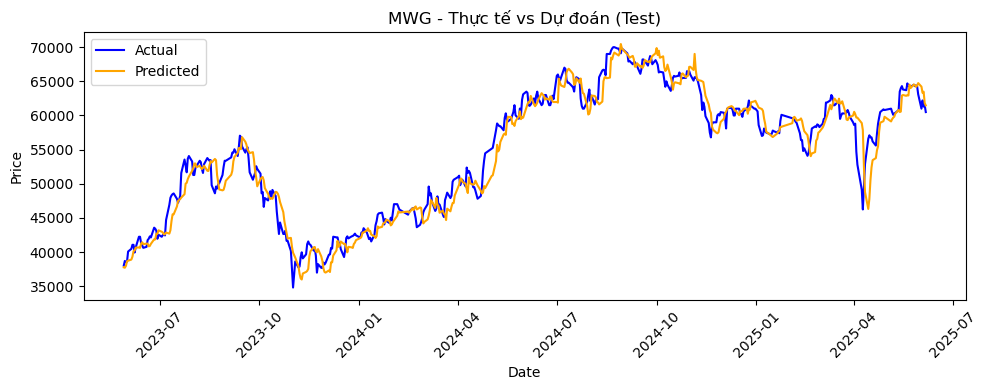

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:31:05,641] A new study created in memory with name: no-name-41bb706c-9aa4-473a-b4a1-4a5d2e8906d6



📅 Dự báo 30 phiên tới cho MWG:
2025-06-09: 60,890 VND
2025-06-10: 60,695 VND
2025-06-11: 60,930 VND
2025-06-12: 61,086 VND
2025-06-13: 61,258 VND
2025-06-16: 61,593 VND
2025-06-17: 62,141 VND
2025-06-18: 62,430 VND
2025-06-19: 62,874 VND
2025-06-20: 63,215 VND
2025-06-23: 63,708 VND
2025-06-24: 64,083 VND
2025-06-25: 64,503 VND
2025-06-26: 64,862 VND
2025-06-27: 65,228 VND
2025-06-30: 65,581 VND
2025-07-01: 65,910 VND
2025-07-02: 66,206 VND
2025-07-03: 66,502 VND
2025-07-04: 66,784 VND
2025-07-07: 67,075 VND
2025-07-08: 67,343 VND
2025-07-09: 67,610 VND
2025-07-10: 67,861 VND
2025-07-11: 68,110 VND
2025-07-14: 68,352 VND
2025-07-15: 68,595 VND
2025-07-16: 68,841 VND
2025-07-17: 69,091 VND
2025-07-18: 69,342 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:31:15,610] Trial 0 finished with value: 0.000542373105417937 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.0032473732957750316}. Best is trial 0 with value: 0.000542373105417937.
[I 2025-06-06 22:31:25,103] Trial 1 finished with value: 0.0005028490559197962 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0029817083166255964}. Best is trial 1 with va

  ↪ PLX: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.003209646259574511}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔧 LSTM Basic (tuned) - PLX
📊 R²: 0.9521 | RMSE: 1,051.91 | MAE: 710.42 | MAPE: 1.83%


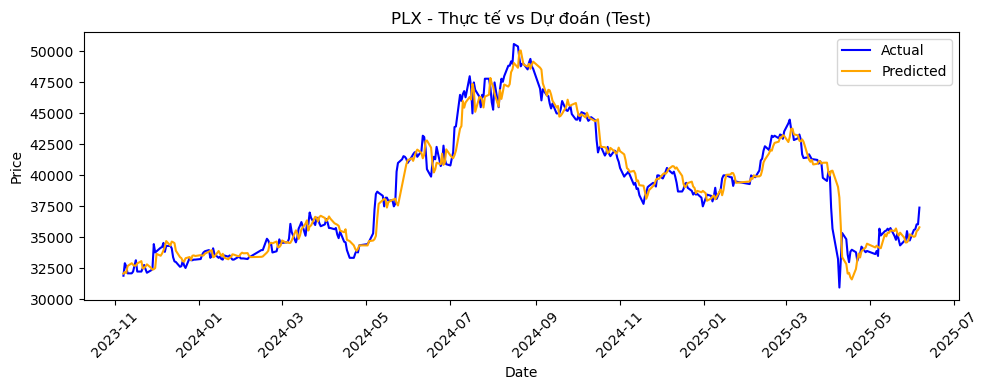

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho PLX:
2025-06-09: 36,283 VND
2025-06-10: 35,758 VND
2025-06-11: 35,394 VND
2025-06-12: 35,079 VND
2025-06-13: 34,868 VND
2025-06-16: 34,709 VND
2025-06-17: 34,507 VND
2025-06-18: 34,278 VND
2025-06-19: 34,010 VND
2025-06-20: 33,712 VND
2025-06-23: 33,287 VND
2025-06-24: 32,902 VND
2025-06-25: 32,583 VND
2025-06-26: 32,316 VND
2025-06-27: 32,097 VND
2025-06-30: 31,909 VND
2025-07-01: 31,723 VND
2025-07-02: 31,516 VND
2025-07-03: 31,269 VND
2025-07-04: 30,992 VND
2025-07-07: 30,685 VND
2025-07-08: 30,377 VND
2025-07-09: 30,072 VND
2025-07-10: 29,765 VND
2025-07-11: 29,469 VND
2025-07-14: 29,192 VND
2025-07-15: 28,940 VND
2025-07-16: 28,718 VND
2025-07-17: 28,520 VND
2025-07-18: 28,345 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:33:48,170] A new study created in memory with name: no-name-c1364f7d-8fc8-4b83-a4b4-3929b7f9fac6
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:2

  ↪ SAB: Chọn params từ Optuna: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.002153434114253431}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔧 LSTM Basic (tuned) - SAB
📊 R²: 0.7019 | RMSE: 1,851.68 | MAE: 1,328.10 | MAPE: 2.46%


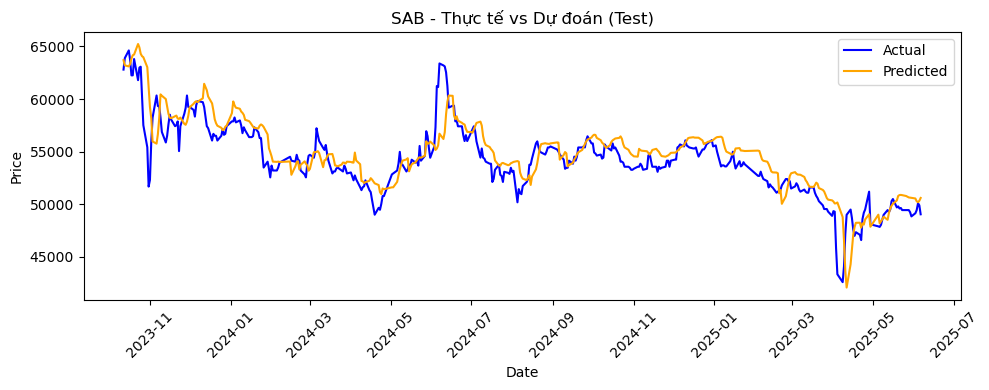

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

📅 Dự báo 30 phiên tới cho SAB:
2025-06-09: 50,836 VND
2025-06-10: 50,958 VND
2025-06-11: 51,339 VND
2025-06-12: 51,751 VND
2025-06-13: 52,166 VND
2025-06-16: 52,568 VND
2025-06-17: 52,958 VND
2025-06-18: 53,328 VND
2025-06-19: 53,679 VND
2025-06-20: 54,019 VND
2025-06-23: 54,353 VND
2025-06-24: 54,657 VND
2025-06-25: 54,945 VND
2025-06-26: 55,224 VND
2025-06-27: 55,490 VND
2025-06-30: 55,746 VND
2025-07-01: 55,992 VND
2025-07-02: 56,229 VND
2025-07-03: 56,458 VND
2025-07-04: 56,680 VND
2025-07-07: 56,895 VND
2025-07-08: 57,106 VND
2025-07-09: 57,312 VND
2025-07-10: 57,514 VND
2025-07-11: 57,712 VND
2025-07-14: 57,907 VND
2025-07-15: 58,099 VND
2025-07-16: 58,287 VND
2025-07-17: 58,471 VND
2025-07-18: 58,651 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:35:06,990] A new study created in memory with name: no-name-786206ad-54d7-40ff-8fcb-0036b8485679
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer i

  ↪ SHB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0017178868473017275}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔧 LSTM Basic (tuned) - SHB
📊 R²: 0.9173 | RMSE: 313.08 | MAE: 228.87 | MAPE: 2.22%


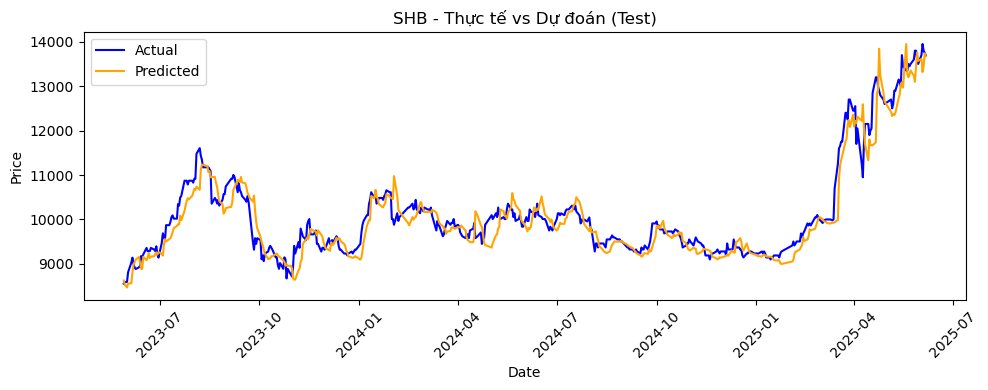

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:37:15,144] A new study created in memory with name: no-name-d9b0dd2e-0cc4-4c9e-93ca-d10ebf4aa706



📅 Dự báo 30 phiên tới cho SHB:
2025-06-09: 13,792 VND
2025-06-10: 13,612 VND
2025-06-11: 13,512 VND
2025-06-12: 13,469 VND
2025-06-13: 13,457 VND
2025-06-16: 13,457 VND
2025-06-17: 13,443 VND
2025-06-18: 13,419 VND
2025-06-19: 13,402 VND
2025-06-20: 13,388 VND
2025-06-23: 13,371 VND
2025-06-24: 13,349 VND
2025-06-25: 13,333 VND
2025-06-26: 13,319 VND
2025-06-27: 13,304 VND
2025-06-30: 13,285 VND
2025-07-01: 13,265 VND
2025-07-02: 13,245 VND
2025-07-03: 13,227 VND
2025-07-04: 13,210 VND
2025-07-07: 13,192 VND
2025-07-08: 13,176 VND
2025-07-09: 13,158 VND
2025-07-10: 13,140 VND
2025-07-11: 13,124 VND
2025-07-14: 13,107 VND
2025-07-15: 13,090 VND
2025-07-16: 13,074 VND
2025-07-17: 13,059 VND
2025-07-18: 13,045 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:37:21,306] Trial 0 finished with value: 0.002643515821546316 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0011716711464821376}. Best is trial 0 with value: 0.002643515821546316.
[I 2025-06-06 22:37:27,824] Trial 1 finished with value: 0.001919013331644237 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0011354444428771765}. Best is trial 1 with val

  ↪ SSB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.008224250791250717}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

🔧 LSTM Basic (tuned) - SSB
📊 R²: 0.7986 | RMSE: 550.78 | MAE: 358.88 | MAPE: 2.02%


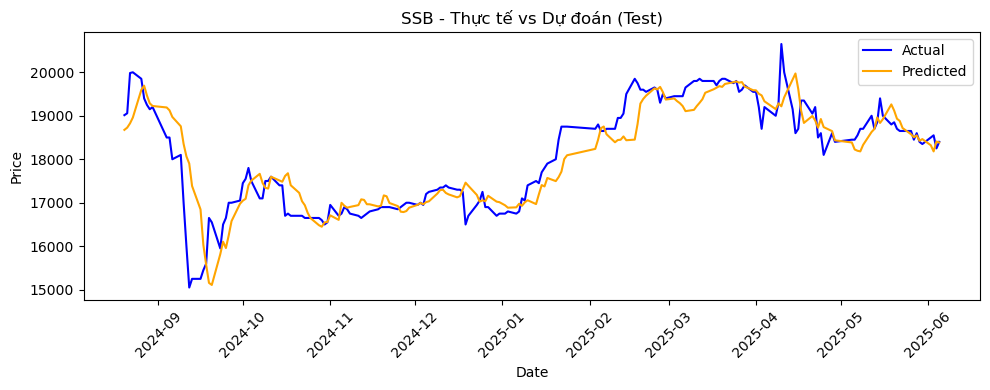

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:38:27,448] A new study created in memory with name: no-name-168527bb-9cbd-4e50-bac4-63109233ba86



📅 Dự báo 30 phiên tới cho SSB:
2025-06-06: 18,182 VND
2025-06-09: 18,273 VND
2025-06-10: 18,533 VND
2025-06-11: 18,914 VND
2025-06-12: 19,325 VND
2025-06-13: 19,737 VND
2025-06-16: 20,115 VND
2025-06-17: 20,438 VND
2025-06-18: 20,721 VND
2025-06-19: 21,012 VND
2025-06-20: 21,280 VND
2025-06-23: 21,553 VND
2025-06-24: 21,808 VND
2025-06-25: 22,031 VND
2025-06-26: 22,218 VND
2025-06-27: 22,378 VND
2025-06-30: 22,523 VND
2025-07-01: 22,663 VND
2025-07-02: 22,807 VND
2025-07-03: 22,956 VND
2025-07-04: 23,102 VND
2025-07-07: 23,244 VND
2025-07-08: 23,379 VND
2025-07-09: 23,507 VND
2025-07-10: 23,630 VND
2025-07-11: 23,750 VND
2025-07-14: 23,869 VND
2025-07-15: 23,984 VND
2025-07-16: 24,095 VND
2025-07-17: 24,200 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:38:34,541] Trial 0 finished with value: 0.002725584665313363 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.00021201567490626802}. Best is trial 0 with value: 0.002725584665313363.
[I 2025-06-06 22:38:48,849] Trial 1 finished with value: 0.0009311886969953775 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.00024154160547300632}. Best is trial 1 with value: 0.0009311

  ↪ SSI: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.004334167103576737}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔧 LSTM Basic (tuned) - SSI
📊 R²: 0.8778 | RMSE: 839.23 | MAE: 588.19 | MAPE: 2.35%


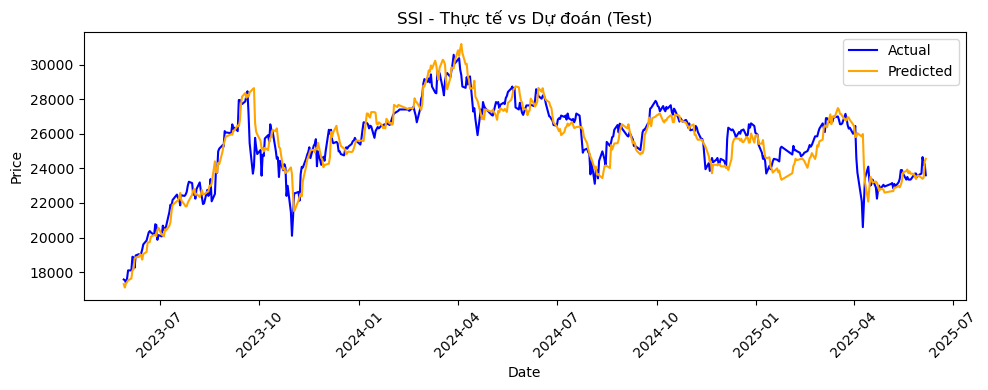

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:41:45,286] A new study created in memory with name: no-name-67de3006-80e9-4780-8b46-0b8ce988e4bf



📅 Dự báo 30 phiên tới cho SSI:
2025-06-09: 22,346 VND
2025-06-10: 22,117 VND
2025-06-11: 22,244 VND
2025-06-12: 22,452 VND
2025-06-13: 22,656 VND
2025-06-16: 22,860 VND
2025-06-17: 23,091 VND
2025-06-18: 23,313 VND
2025-06-19: 23,576 VND
2025-06-20: 23,832 VND
2025-06-23: 24,103 VND
2025-06-24: 24,362 VND
2025-06-25: 24,567 VND
2025-06-26: 24,743 VND
2025-06-27: 24,909 VND
2025-06-30: 25,078 VND
2025-07-01: 25,242 VND
2025-07-02: 25,397 VND
2025-07-03: 25,556 VND
2025-07-04: 25,720 VND
2025-07-07: 25,874 VND
2025-07-08: 26,018 VND
2025-07-09: 26,170 VND
2025-07-10: 26,327 VND
2025-07-11: 26,479 VND
2025-07-14: 26,639 VND
2025-07-15: 26,784 VND
2025-07-16: 26,936 VND
2025-07-17: 27,083 VND
2025-07-18: 27,224 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:42:00,574] Trial 0 finished with value: 0.0038225525058805943 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.00047391583094732624}. Best is trial 0 with value: 0.0038225525058805943.
[I 2025-06-06 22:42:12,684] Trial 1 finished with value: 0.0008230820531025529 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00220810448413934}. Best is trial 1 with v

  ↪ STB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.004423072924108307}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔧 LSTM Basic (tuned) - STB
📊 R²: 0.9441 | RMSE: 926.44 | MAE: 697.40 | MAPE: 2.18%


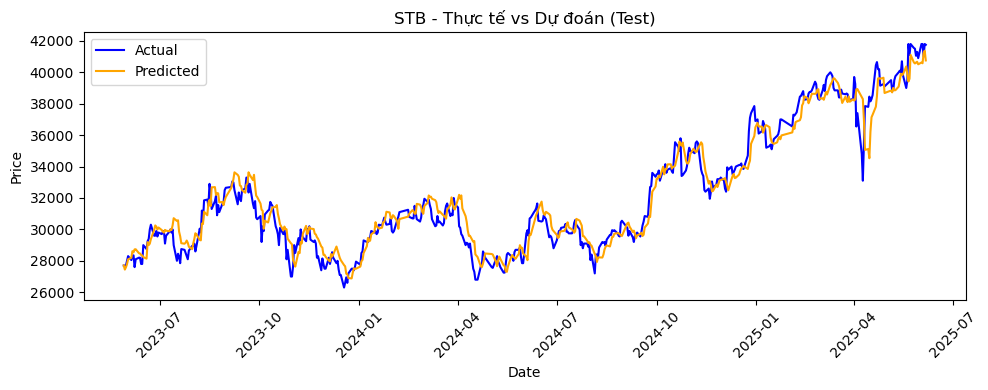

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

📅 Dự báo 30 phiên tới cho STB:
2025-06-09: 41,299 VND
2025-06-10: 41,336 VND
2025-06-11: 41,436 VND
2025-06-12: 41,571 VND
2025-06-13: 41,668 VND
2025-06-16: 41,795 VND
2025-06-17: 41,812 VND
2025-06-18: 41,860 VND
2025-06-19: 41,982 VND
2025-06-20: 42,011 VND
2025-06-23: 42,072 VND
2025-06-24: 42,172 VND
2025-06-25: 42,254 VND
2025-06-26: 42,324 VND
2025-06-27: 42,378 VND
2025-06-30: 42,430 VND
2025-07-01: 42,477 VND
2025-07-02: 42,533 VND
2025-07-03: 42,590 VND
2025-07-04: 42,643 VND
2025-07-07: 42,699 VND
2025-07-08: 42,753 VND
2025-07-09: 42,802 VND
2025-07-10: 42,849 VND
2025-07-11: 42,896 VND
2025-07-14: 42,943 VND
2025-07-15: 42,990 VND
2025-07-16: 43,036 VND
2025-07-17: 43,081 VND
2025-07-18: 43,124 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:44:38,449] A new study created in memory with name: no-name-82d30773-5cc2-4183-817e-f7d25f7f0462
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer i

  ↪ TCB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.008360939091844374}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔧 LSTM Basic (tuned) - TCB
📊 R²: 0.9396 | RMSE: 669.80 | MAE: 492.18 | MAPE: 2.07%


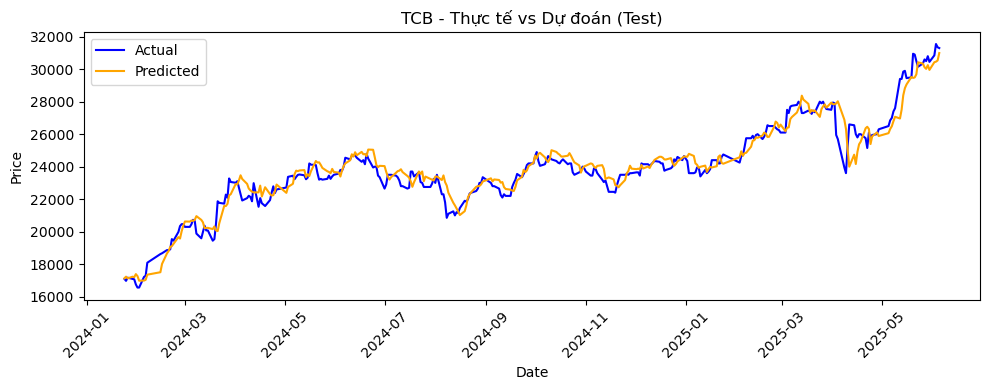

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:45:54,524] A new study created in memory with name: no-name-8d5bd468-ded3-4ea6-89e2-73aedf6928c9



📅 Dự báo 30 phiên tới cho TCB:
2025-06-06: 30,896 VND
2025-06-09: 30,550 VND
2025-06-10: 30,405 VND
2025-06-11: 30,327 VND
2025-06-12: 30,233 VND
2025-06-13: 30,094 VND
2025-06-16: 29,962 VND
2025-06-17: 29,813 VND
2025-06-18: 29,621 VND
2025-06-19: 29,454 VND
2025-06-20: 29,321 VND
2025-06-23: 29,224 VND
2025-06-24: 29,143 VND
2025-06-25: 29,053 VND
2025-06-26: 28,944 VND
2025-06-27: 28,829 VND
2025-06-30: 28,717 VND
2025-07-01: 28,608 VND
2025-07-02: 28,503 VND
2025-07-03: 28,402 VND
2025-07-04: 28,303 VND
2025-07-07: 28,205 VND
2025-07-08: 28,104 VND
2025-07-09: 28,001 VND
2025-07-10: 27,899 VND
2025-07-11: 27,802 VND
2025-07-14: 27,710 VND
2025-07-15: 27,622 VND
2025-07-16: 27,537 VND
2025-07-17: 27,454 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:46:06,377] Trial 0 finished with value: 0.0007460478809662163 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.004410282296181229}. Best is trial 0 with value: 0.0007460478809662163.
[I 2025-06-06 22:46:11,931] Trial 1 finished with value: 0.0011074257781729102 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0006880721427576751}. Best is trial 0 with v

  ↪ TPB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.004400887224088497}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

🔧 LSTM Basic (tuned) - TPB
📊 R²: 0.8305 | RMSE: 425.93 | MAE: 299.13 | MAPE: 2.14%


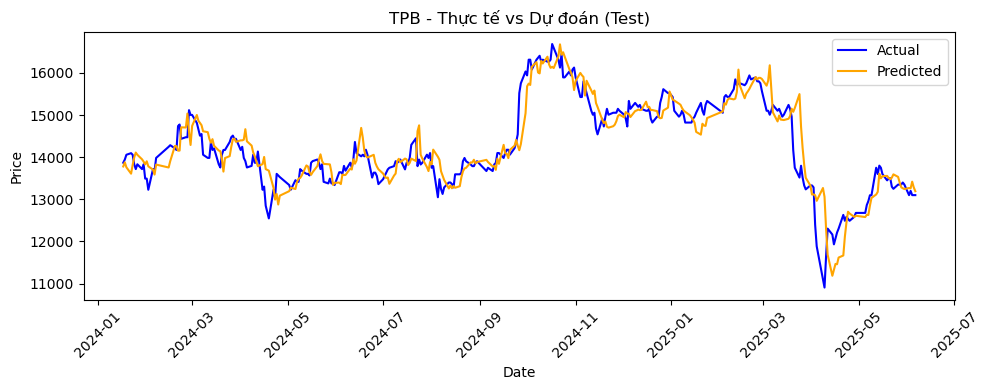

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:47:44,469] A new study created in memory with name: no-name-8ca496fa-23c3-4610-a8ea-2cb5ce3ae410



📅 Dự báo 30 phiên tới cho TPB:
2025-06-09: 13,144 VND
2025-06-10: 13,178 VND
2025-06-11: 13,198 VND
2025-06-12: 13,224 VND
2025-06-13: 13,251 VND
2025-06-16: 13,284 VND
2025-06-17: 13,331 VND
2025-06-18: 13,365 VND
2025-06-19: 13,401 VND
2025-06-20: 13,432 VND
2025-06-23: 13,460 VND
2025-06-24: 13,486 VND
2025-06-25: 13,509 VND
2025-06-26: 13,533 VND
2025-06-27: 13,557 VND
2025-06-30: 13,581 VND
2025-07-01: 13,604 VND
2025-07-02: 13,626 VND
2025-07-03: 13,648 VND
2025-07-04: 13,668 VND
2025-07-07: 13,688 VND
2025-07-08: 13,708 VND
2025-07-09: 13,728 VND
2025-07-10: 13,748 VND
2025-07-11: 13,768 VND
2025-07-14: 13,787 VND
2025-07-15: 13,806 VND
2025-07-16: 13,824 VND
2025-07-17: 13,840 VND
2025-07-18: 13,857 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:47:58,364] Trial 0 finished with value: 0.0006803194992244244 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0030533451357551773}. Best is trial 0 with value: 0.0006803194992244244.
[I 2025-06-06 22:48:10,104] Trial 1 finished with value: 0.001227132510393858 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00012082211226701069}. Best is trial 0 with 

  ↪ VCB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.4, 'lr': 0.0027868123254719056}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔧 LSTM Basic (tuned) - VCB
📊 R²: 0.6914 | RMSE: 1,421.50 | MAE: 986.00 | MAPE: 1.64%


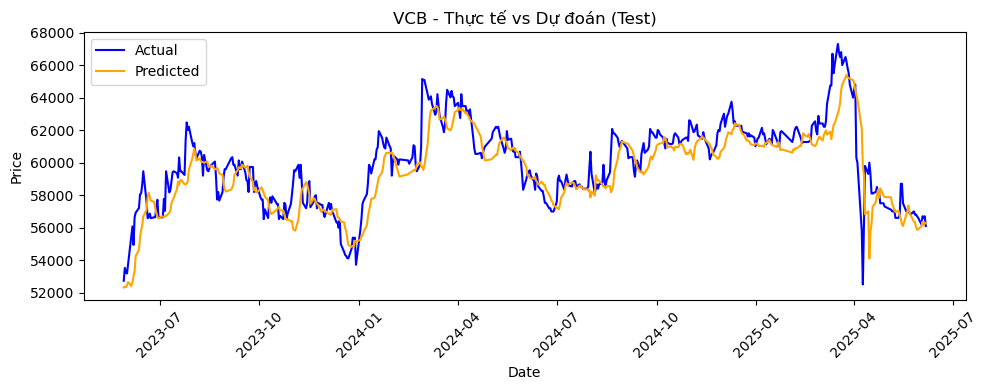

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:50:12,694] A new study created in memory with name: no-name-bc1468f2-0df1-4f25-9c03-49a1c5eb11a4



📅 Dự báo 30 phiên tới cho VCB:
2025-06-09: 55,221 VND
2025-06-10: 55,373 VND
2025-06-11: 55,140 VND
2025-06-12: 55,021 VND
2025-06-13: 54,878 VND
2025-06-16: 54,758 VND
2025-06-17: 54,667 VND
2025-06-18: 54,560 VND
2025-06-19: 54,457 VND
2025-06-20: 54,354 VND
2025-06-23: 54,284 VND
2025-06-24: 54,241 VND
2025-06-25: 54,187 VND
2025-06-26: 54,136 VND
2025-06-27: 54,084 VND
2025-06-30: 54,035 VND
2025-07-01: 53,980 VND
2025-07-02: 53,919 VND
2025-07-03: 53,864 VND
2025-07-04: 53,815 VND
2025-07-07: 53,760 VND
2025-07-08: 53,711 VND
2025-07-09: 53,658 VND
2025-07-10: 53,608 VND
2025-07-11: 53,551 VND
2025-07-14: 53,502 VND
2025-07-15: 53,459 VND
2025-07-16: 53,403 VND
2025-07-17: 53,349 VND
2025-07-18: 53,304 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:50:34,627] Trial 0 finished with value: 0.0024362311232835054 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.00016457239985991252}. Best is trial 0 with value: 0.0024362311232835054.
[I 2025-06-06 22:50:49,704] Trial 1 finished with value: 0.0013021975755691528 and parameters: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00219337188453582}. Best is trial 1 with v

  ↪ VHM: Chọn params từ Optuna: {'units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00219337188453582}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔧 LSTM Basic (tuned) - VHM
📊 R²: 0.9400 | RMSE: 2,015.03 | MAE: 1,396.19 | MAPE: 3.00%


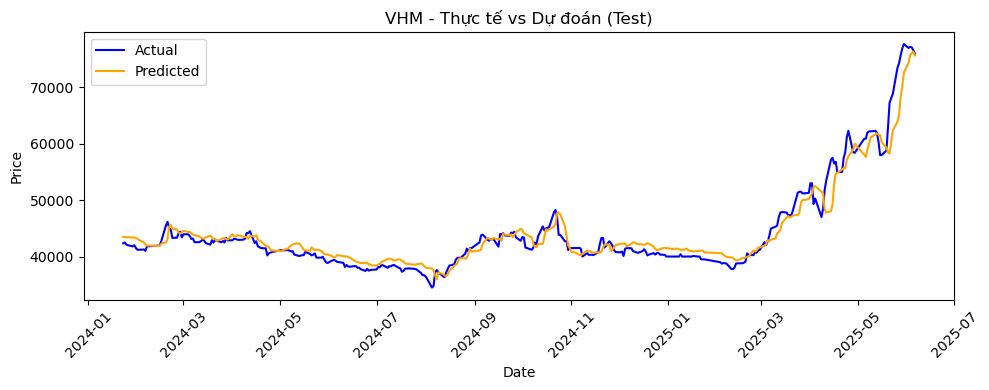

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:52:34,820] A new study created in memory with name: no-name-ec63922a-3dd3-42f5-acb0-910a8ab29a4d



📅 Dự báo 30 phiên tới cho VHM:
2025-06-09: 69,676 VND
2025-06-10: 68,446 VND
2025-06-11: 68,075 VND
2025-06-12: 67,784 VND
2025-06-13: 67,463 VND
2025-06-16: 67,058 VND
2025-06-17: 66,740 VND
2025-06-18: 66,401 VND
2025-06-19: 66,047 VND
2025-06-20: 65,715 VND
2025-06-23: 65,410 VND
2025-06-24: 65,736 VND
2025-06-25: 66,035 VND
2025-06-26: 66,137 VND
2025-06-27: 66,073 VND
2025-06-30: 65,896 VND
2025-07-01: 65,659 VND
2025-07-02: 65,383 VND
2025-07-03: 65,088 VND
2025-07-04: 64,785 VND
2025-07-07: 64,480 VND
2025-07-08: 64,173 VND
2025-07-09: 63,803 VND
2025-07-10: 63,382 VND
2025-07-11: 62,948 VND
2025-07-14: 62,533 VND
2025-07-15: 62,153 VND
2025-07-16: 61,809 VND
2025-07-17: 61,496 VND
2025-07-18: 61,212 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:52:43,306] Trial 0 finished with value: 0.00034173394669778645 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.007907833457169035}. Best is trial 0 with value: 0.00034173394669778645.
[I 2025-06-06 22:52:54,209] Trial 1 finished with value: 0.00033671242999844253 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0004903981425163128}. Best is trial 1 wit

  ↪ VIB: Chọn params từ Optuna: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0004903981425163128}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔧 LSTM Basic (tuned) - VIB
📊 R²: 0.8354 | RMSE: 582.56 | MAE: 437.01 | MAPE: 2.50%


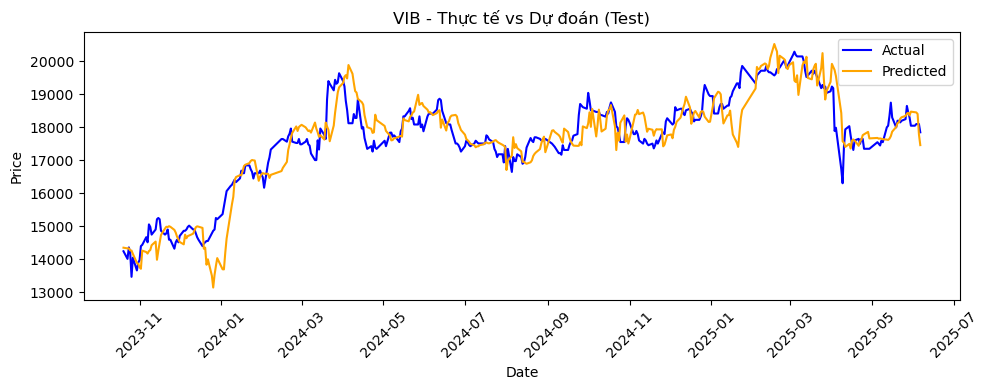

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

📅 Dự báo 30 phiên tới cho VIB:
2025-06-09: 17,723 VND
2025-06-10: 17,701 VND
2025-06-11: 17,665 VND
2025-06-12: 17,657 VND
2025-06-13: 17,650 VND
2025-06-16: 17,660 VND
2025-06-17: 17,666 VND
2025-06-18: 17,665 VND
2025-06-19: 17,662 VND
2025-06-20: 17,658 VND
2025-06-23: 17,669 VND
2025-06-24: 17,689 VND
2025-06-25: 17,709 VND
2025-06-26: 17,729 VND
2025-06-27: 17,751 VND
2025-06-30: 17,774 VND
2025-07-01: 17,796 VND
2025-07-02: 17,819 VND
2025-07-03: 17,842 VND
2025-07-04: 17,866 VND
2025-07-07: 17,892 VND
2025-07-08: 17,920 VND
2025-07-09: 17,947 VND
2025-07-10: 17,974 VND
2025-07-11: 18,003 VND
2025-07-14: 18,031 VND
2025-07-15: 18,059 VND
2025-07-16: 18,086 VND
2025-07-17: 18,113 VND
2025-07-18: 18,139 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:54:18,272] A new study created in memory with name: no-name-16e9a851-2572-4dff-9b53-76e38728f502
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:2

  ↪ VIC: Chọn params từ Optuna: {'units': 32, 'dropout': 0.2, 'lr': 0.0016122360465923304}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔧 LSTM Basic (tuned) - VIC
📊 R²: 0.9291 | RMSE: 3,094.91 | MAE: 2,036.61 | MAPE: 3.88%


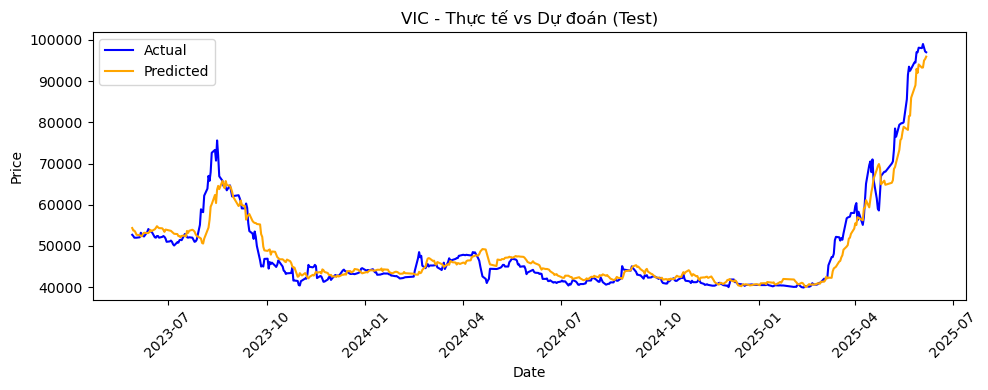

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:56:23,807] A new study created in memory with name: no-name-ca5126da-a86f-4567-b7aa-9fe62cdfb918



📅 Dự báo 30 phiên tới cho VIC:
2025-06-09: 94,763 VND
2025-06-10: 95,293 VND
2025-06-11: 94,503 VND
2025-06-12: 93,831 VND
2025-06-13: 93,242 VND
2025-06-16: 92,766 VND
2025-06-17: 92,317 VND
2025-06-18: 91,957 VND
2025-06-19: 91,579 VND
2025-06-20: 91,325 VND
2025-06-23: 91,074 VND
2025-06-24: 90,868 VND
2025-06-25: 90,735 VND
2025-06-26: 90,547 VND
2025-06-27: 90,413 VND
2025-06-30: 90,292 VND
2025-07-01: 90,171 VND
2025-07-02: 90,071 VND
2025-07-03: 89,955 VND
2025-07-04: 89,869 VND
2025-07-07: 89,768 VND
2025-07-08: 89,667 VND
2025-07-09: 89,572 VND
2025-07-10: 89,488 VND
2025-07-11: 89,378 VND
2025-07-14: 89,299 VND
2025-07-15: 89,196 VND
2025-07-16: 89,105 VND
2025-07-17: 89,019 VND
2025-07-18: 88,941 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 22:56:31,857] Trial 0 finished with value: 0.0002605349291115999 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0003744722252344357}. Best is trial 0 with value: 0.0002605349291115999.
[I 2025-06-06 22:56:39,457] Trial 1 finished with value: 0.00016369936929550022 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0012551894760975532}. Best

  ↪ VJC: Chọn params từ Optuna: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0012551894760975532}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔧 LSTM Basic (tuned) - VJC
📊 R²: 0.8592 | RMSE: 2,379.41 | MAE: 1,528.19 | MAPE: 1.52%


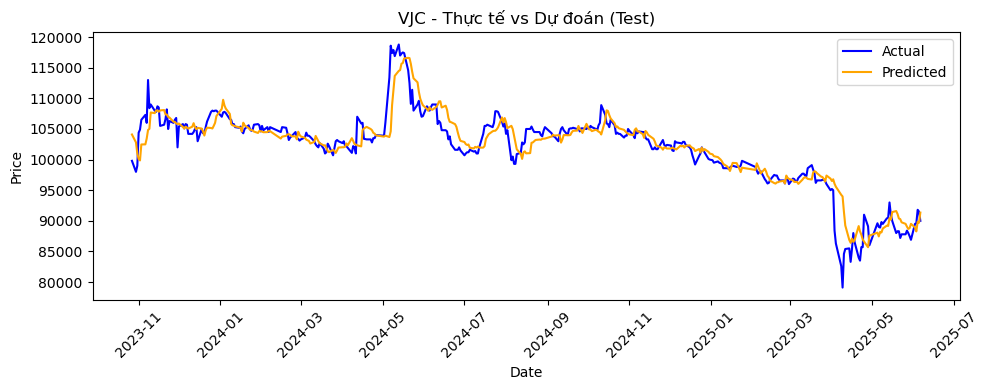

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho VJC:
2025-06-09: 91,038 VND
2025-06-10: 91,487 VND
2025-06-11: 91,829 VND
2025-06-12: 92,113 VND
2025-06-13: 92,376 VND
2025-06-16: 92,654 VND
2025-06-17: 92,871 VND
2025-06-18: 93,091 VND
2025-06-19: 93,281 VND
2025-06-20: 93,501 VND
2025-06-23: 93,768 VND
2025-06-24: 94,011 VND
2025-06-25: 94,241 VND
2025-06-26: 94,462 VND
2025-06-27: 94,677 VND
2025-06-30: 94,889 VND
2025-07-01: 95,097 VND
2025-07-02: 95,303 VND
2025-07-03: 95,503 VND
2025-07-04: 95,694 VND
2025-07-07: 95,875 VND
2025-07-08: 96,051 VND
2025-07-09: 96,227 VND
2025-07-10: 96,403 VND
2025-07-11: 96,578 VND
2025-07-14: 96,752 VND
2025-07-15: 96,923 VND
2025-07-16: 97,086 VND
2025-07-17: 97,248 VND
2025-07-18: 97,406 VND


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 22:58:06,593] A new study created in memory with name: no-name-b4ed0214-2628-455d-a50f-5aa4f3eaa21d
C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:2

  ↪ VNM: Chọn params từ Optuna: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.008936734534043379}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🔧 LSTM Basic (tuned) - VNM
📊 R²: 0.9096 | RMSE: 1,108.66 | MAE: 774.11 | MAPE: 1.29%


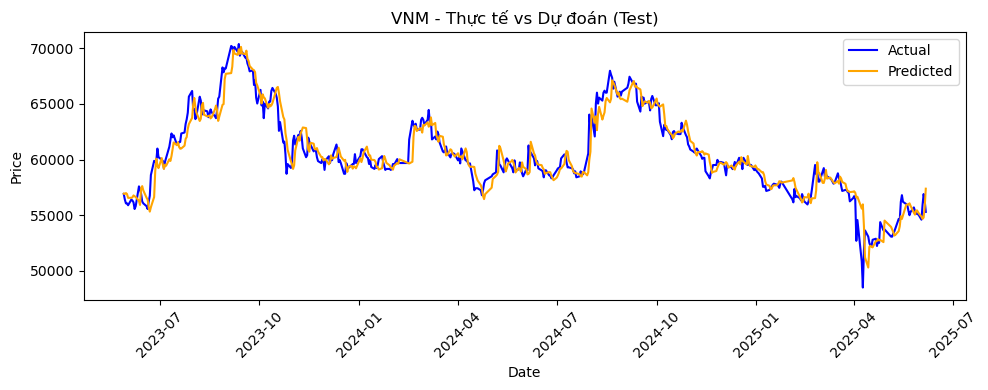

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 23:01:10,245] A new study created in memory with name: no-name-819a3f3d-e38b-4bf1-9827-19146ce21364



📅 Dự báo 30 phiên tới cho VNM:
2025-06-09: 55,861 VND
2025-06-10: 56,006 VND
2025-06-11: 56,047 VND
2025-06-12: 56,017 VND
2025-06-13: 55,969 VND
2025-06-16: 55,921 VND
2025-06-17: 55,867 VND
2025-06-18: 55,807 VND
2025-06-19: 55,681 VND
2025-06-20: 55,500 VND
2025-06-23: 55,337 VND
2025-06-24: 55,226 VND
2025-06-25: 55,113 VND
2025-06-26: 54,994 VND
2025-06-27: 54,879 VND
2025-06-30: 54,775 VND
2025-07-01: 54,685 VND
2025-07-02: 54,606 VND
2025-07-03: 54,536 VND
2025-07-04: 54,472 VND
2025-07-07: 54,414 VND
2025-07-08: 54,362 VND
2025-07-09: 54,314 VND
2025-07-10: 54,264 VND
2025-07-11: 54,212 VND
2025-07-14: 54,157 VND
2025-07-15: 54,095 VND
2025-07-16: 54,029 VND
2025-07-17: 53,963 VND
2025-07-18: 53,896 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 23:01:18,617] Trial 0 finished with value: 0.000628146342933178 and parameters: {'units': 32, 'dropout': 0.4, 'lr': 0.0008006542940850492}. Best is trial 0 with value: 0.000628146342933178.
[I 2025-06-06 23:01:31,160] Trial 1 finished with value: 0.0008137791883200407 and parameters: {'units': 64, 'dropout': 0.4, 'lr': 0.0002676943389186123}. Best is trial 0 with value: 0.000628146

  ↪ VPB: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.0020583210271965086}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔧 LSTM Basic (tuned) - VPB
📊 R²: 0.7531 | RMSE: 395.24 | MAE: 271.29 | MAPE: 1.55%


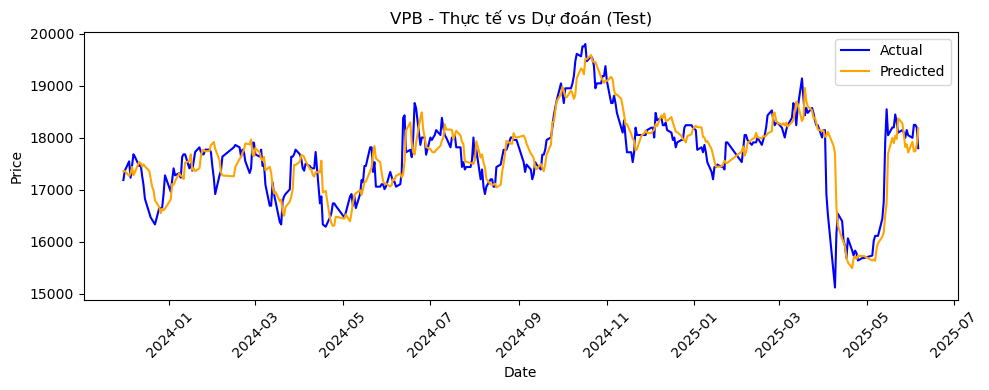

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2025-06-06 23:02:53,399] A new study created in memory with name: no-name-649d6af9-8fbf-4f61-8ed3-c9f4f66a485e



📅 Dự báo 30 phiên tới cho VPB:
2025-06-09: 17,484 VND
2025-06-10: 17,337 VND
2025-06-11: 17,303 VND
2025-06-12: 17,365 VND
2025-06-13: 17,446 VND
2025-06-16: 17,548 VND
2025-06-17: 17,657 VND
2025-06-18: 17,750 VND
2025-06-19: 17,853 VND
2025-06-20: 17,961 VND
2025-06-23: 18,094 VND
2025-06-24: 18,233 VND
2025-06-25: 18,369 VND
2025-06-26: 18,495 VND
2025-06-27: 18,610 VND
2025-06-30: 18,715 VND
2025-07-01: 18,813 VND
2025-07-02: 18,902 VND
2025-07-03: 18,988 VND
2025-07-04: 19,070 VND
2025-07-07: 19,150 VND
2025-07-08: 19,227 VND
2025-07-09: 19,304 VND
2025-07-10: 19,376 VND
2025-07-11: 19,447 VND
2025-07-14: 19,518 VND
2025-07-15: 19,588 VND
2025-07-16: 19,656 VND
2025-07-17: 19,724 VND
2025-07-18: 19,793 VND


C:\Users\Admin\AppData\Local\Temp\ipykernel_15548\3942859903.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-06 23:03:00,404] Trial 0 finished with value: 0.000419033836806193 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0012800636553721904}. Best is trial 0 with value: 0.000419033836806193.
[I 2025-06-06 23:03:04,749] Trial 1 finished with value: 0.000783153809607029 and parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.008547165232146376}. Best is trial 0 with valu

  ↪ VRE: Chọn params từ Optuna: {'units': 64, 'dropout': 0.2, 'lr': 0.008456283411443624}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔧 LSTM Basic (tuned) - VRE
📊 R²: 0.9253 | RMSE: 845.23 | MAE: 647.85 | MAPE: 3.16%


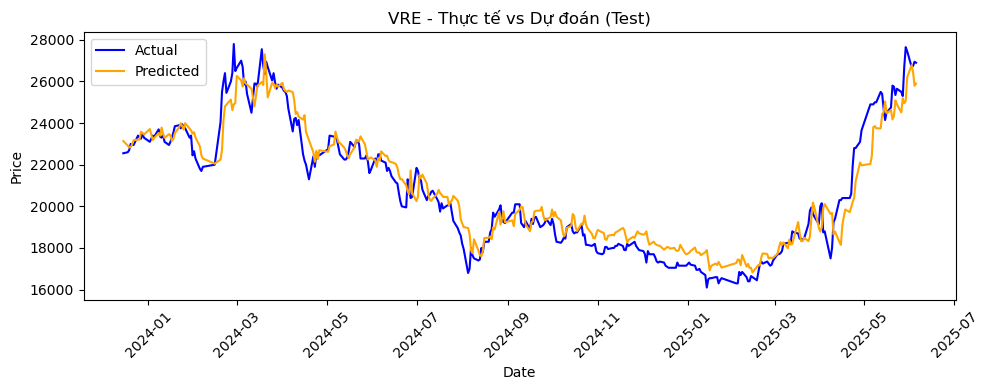

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📅 Dự báo 30 phiên tới cho VRE:
2025-06-06: 26,303 VND
2025-06-09: 25,859 VND
2025-06-10: 25,673 VND
2025-06-11: 25,705 VND
2025-06-12: 25,867 VND
2025-06-13: 26,085 VND
2025-06-16: 26,277 VND
2025-06-17: 26,393 VND
2025-06-18: 26,425 VND
2025-06-19: 26,413 VND
2025-06-20: 26,397 VND
2025-06-23: 26,401 VND
2025-06-24: 26,413 VND
2025-06-25: 26,422 VND
2025-06-26: 26,422 VND
2025-06-27: 26,412 VND
2025-06-30: 26,394 VND
2025-07-01: 26,374 VND
2025-07-02: 26,361 VND
2025-07-03: 26,351 VND
2025-07-04: 26,346 VND
2025-07-07: 26,343 VND
2025-07-08: 26,344 VND
2025-07-09: 26,347 VND
2025-07-10: 26,351 VND
2025-07-11: 26,353 VND
2025-07-14: 26,351 VND
2025-07-15: 26,347 VND
2025-07-16: 26,345 VND
2025-07-17: 26,341 VND

✅ Đã lưu dự báo 30 phiên vào 'vn30_lstm_tuned_forecast.csv'
✅ Đã lưu đánh giá mô hình vào 'vn30_lstm_tuned_evaluation.csv'


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
forecast_all_df = pd.DataFrame(columns=["Date", "Symbol", "Forecasted_Price"])
evaluation_df   = pd.DataFrame(columns=["Symbol", "R2", "RMSE", "MAE", "MAPE"])

# === Lấy danh sách mã VN30 ===
def get_vn30_symbols(access_token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IndexComponents"
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"indexCode": "VN30", "pageIndex": 1, "pageSize": 50}
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return [item['StockSymbol'] for item in response.json()['data'][0]['IndexComponent']]


# === Hàm train LSTM + Optuna + plot + forecast động ===
def train_and_forecast_lstm(symbol, data_folder="vn30_data"):
    global forecast_all_df, evaluation_df

    file_path = os.path.join(data_folder, f"{symbol}_data.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Không có dữ liệu cho {symbol}")
        return

    df = pd.read_csv(file_path)
    df["TradingDate"] = pd.to_datetime(df["TradingDate"])
    df.sort_values("TradingDate", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # === 1. Feature engineering ===
    df["PriceChange"]     = df["Close"] - df["Open"]
    df["High_Low_Spread"] = df["High"] - df["Low"]
    df["RollingMean_5"]   = df["Close"].rolling(5).mean()
    df["Momentum_10"]     = df["Close"] - df["Close"].shift(10)
    df["VolumeChange"]    = df["Volume"].pct_change()

    features = [
        "Open", "High", "Low", "Close", "Volume", "Value", "AvgSentimentScore",
        "PriceChange", "High_Low_Spread", "RollingMean_5", "Momentum_10", "VolumeChange"
    ]
    df_features = df[features].dropna().copy()
    df_dates    = df.loc[df_features.index, "TradingDate"].reset_index(drop=True)

    if len(df_features) < 200:
        print(f"⏭️ {symbol}: không đủ dữ liệu")
        return

    # === 2. Normalize ===
    standard_scaler = StandardScaler()
    minmax_scaler   = MinMaxScaler()
    scaled          = minmax_scaler.fit_transform(standard_scaler.fit_transform(df_features))
    close_index     = df_features.columns.get_loc("Close")

    def inverse_target(scaled_values):
        padded = np.zeros((scaled_values.shape[0], scaled.shape[1]))
        padded[:, close_index] = scaled_values.flatten()
        return standard_scaler.inverse_transform(minmax_scaler.inverse_transform(padded))[:, close_index]

    # === 3. Sequence Builder ===
    SEQ_LEN = 60
    HORIZON = 1
    X, y = [], []
    for i in range(SEQ_LEN, len(scaled) - HORIZON):
        X.append(scaled[i - SEQ_LEN:i])
        y.append(scaled[i + HORIZON, close_index])
    X = np.array(X)
    y = np.array(y)

    if len(X) < 200:
        print(f"⏭️ {symbol}: không đủ mẫu để train")
        return

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    test_dates      = df_dates[-len(y_test):].reset_index(drop=True)

    # === 4. Optuna tuning ===
    def objective(trial):
        units = trial.suggest_categorical("units", [32, 64])
        drop  = trial.suggest_float("dropout", 0.2, 0.4, step=0.1)
        lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)

        model = Sequential([
            LSTM(units, input_shape=(SEQ_LEN, X.shape[2])),
            Dropout(drop),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss="mse")

        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0)
        ]
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30, batch_size=32,
            callbacks=callbacks,
            verbose=0
        )
        return min(hist.history["val_loss"])

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, show_progress_bar=False)
    best_params = study.best_params
    print(f"  ↪ {symbol}: Chọn params từ Optuna: {best_params}")

    # === 5. Xây dựng model với best_params ===
    model = Sequential([
        LSTM(best_params["units"], input_shape=(SEQ_LEN, X.shape[2])),
        Dropout(best_params["dropout"]),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["lr"])
    model.compile(optimizer=optimizer, loss="mse")

    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=0)
    ]
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50, batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    # === 6. Evaluate trên tập test ===
    y_pred_scaled = model.predict(X_test)
    y_pred        = inverse_target(y_pred_scaled)
    y_true        = inverse_target(y_test.reshape(-1, 1))

    mask_nonzero = y_true != 0
    if np.any(~mask_nonzero):
        print(f"⚠️ {symbol}: có giá thực = 0, bỏ để tính MAPE.")

    r2   = r2_score(y_true[mask_nonzero], y_pred[mask_nonzero])
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100

    print(f"\n🔧 LSTM Basic (tuned) - {symbol}")
    print(f"📊 R²: {r2:.4f} | RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | MAPE: {mape:.2f}%")

    evaluation_df.loc[len(evaluation_df)] = {
        "Symbol": symbol,
        "R2": round(r2, 4),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "MAPE": round(mape, 2) if not np.isinf(mape) and not np.isnan(mape) else None
    }

    # === 6.1. Vẽ biểu đồ Actual vs Predicted trên tập test ===
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_true, label="Actual", color="blue")
    plt.plot(test_dates, y_pred, label="Predicted", color="orange")
    plt.title(f"{symbol} - Thực tế vs Dự đoán (Test)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # === 7. Forecast 30 phiên ===
    last_seq   = scaled[-SEQ_LEN:].copy().reshape((1, SEQ_LEN, scaled.shape[1]))
    df_dynamic = df_features.copy().reset_index(drop=True)

    forecast_prices = []
    forecast_dates  = pd.bdate_range(
        start=df["TradingDate"].max() + timedelta(days=1),
        periods=30
    )

    for dt in forecast_dates:
        # 7.1. Dự đoán giá close mới
        pred_scaled = model.predict(last_seq)[0][0]
        pred_real   = float(inverse_target(np.array([[pred_scaled]]))[0])
        forecast_prices.append(pred_real)

        #
        prev_row = df_dynamic.iloc[-1]

        open_new  = prev_row["Close"]
        #
        vol_prev   = prev_row["Volume"]
        noise      = np.random.uniform(0.98, 1.02)
        volume_new = vol_prev * noise

        value_new     = prev_row["Value"]
        sentiment_new = prev_row["AvgSentimentScore"]

        high_new  = max(open_new, pred_real)
        low_new   = min(open_new, pred_real)
        close_new = pred_real

        price_change_new    = close_new - open_new
        high_low_spread_new = high_new - low_new

        last_4 = df_dynamic["Close"].iloc[-4:].tolist()
        rolling_mean_5_new = (sum(last_4) + close_new) / 5.0

        if len(df_dynamic) >= 10:
            momentum_10_new = close_new - df_dynamic["Close"].iloc[-10]
        else:
            momentum_10_new = close_new - df_dynamic["Close"].iloc[0]

        volume_change_new = 0.0
        if vol_prev != 0:
            volume_change_new = (volume_new - vol_prev) / vol_prev

        # 7.3. Append vào df_dynamic
        new_row = pd.DataFrame([{
            "Open": open_new,
            "High": high_new,
            "Low": low_new,
            "Close": close_new,
            "Volume": volume_new,
            "Value": value_new,
            "AvgSentimentScore": sentiment_new,
            "PriceChange": price_change_new,
            "High_Low_Spread": high_low_spread_new,
            "RollingMean_5": rolling_mean_5_new,
            "Momentum_10": momentum_10_new,
            "VolumeChange": volume_change_new
        }])
        df_dynamic = pd.concat([df_dynamic, new_row], ignore_index=True)

        # 7.4. Chuẩn hóa và update last_seq
        new_features_array = np.array([
            open_new, high_new, low_new, close_new,
            volume_new, value_new, sentiment_new,
            price_change_new, high_low_spread_new,
            rolling_mean_5_new, momentum_10_new, volume_change_new
        ]).reshape(1, -1)

        std_feat   = standard_scaler.transform(new_features_array)
        new_scaled = minmax_scaler.transform(std_feat)

        last_seq = np.concatenate([last_seq[:, 1:, :], new_scaled.reshape(1, 1, -1)], axis=1)

    # 7.5. In log forecast
    print(f"\n📅 Dự báo 30 phiên tới cho {symbol}:")
    for date, price in zip(forecast_dates, forecast_prices):
        print(f"{date.strftime('%Y-%m-%d')}: {round(price):,} VND")

    forecast_df = pd.DataFrame({
        "Date": forecast_dates,
        "Symbol": symbol,
        "Forecasted_Price": forecast_prices
    })
    forecast_all_df = pd.concat([forecast_all_df, forecast_df], ignore_index=True)


# === Chạy cho tất cả mã VN30 ===
symbols = get_vn30_symbols(access_token)
for symbol in symbols:
    train_and_forecast_lstm(symbol)

# === Lưu kết quả ===
forecast_all_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_lstm_tuned_forecast.csv", index=False)
evaluation_df.to_csv(r"C:\Users\Admin\OneDrive - vnu.edu.vn\vn30_lstm_tuned_evaluation.csv", index=False)
print("\n✅ Đã lưu dự báo 30 phiên vào 'vn30_lstm_tuned_forecast.csv'")
print("✅ Đã lưu đánh giá mô hình vào 'vn30_lstm_tuned_evaluation.csv'")
